In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import time
from xgboost.sklearn import XGBClassifier

In [2]:
train_features1 = pd.read_csv('../myFeatures/train_features.csv')
test_features1 = pd.read_csv('../myFeatures/test_features.csv')
train_features2 = pd.read_csv('../myFeatures/train_features_2.csv')
test_features2 = pd.read_csv('../myFeatures/test_features_2.csv')
train_features3 = pd.read_csv('../myFeatures/train_features3.csv')
test_features3 = pd.read_csv('../myFeatures/test_features3.csv')

In [3]:
train_features3.columns

Index(['label', 'uid', 'wa_up_flow_per_visit_median',
       'wa_down_flow_per_visit_median', 'wa_dura_per_visit_median'],
      dtype='object')

In [4]:
train_features = pd.merge(train_features1, train_features2.drop(['label'], axis=1), how='left', on='uid')
test_features = pd.merge(test_features1, test_features2.drop(['label'], axis=1), how='left', on='uid')

train_features = pd.merge(train_features, train_features3.drop(['label'], axis=1), how='left', on='uid')
test_features = pd.merge(test_features, test_features3.drop(['label'], axis=1), how='left', on='uid')
# train_features = train_features1
# test_features = test_features1

In [5]:
train_y = train_features['label']
train_X = train_features.drop(['uid','label'], axis=1)

test_uids = test_features['uid']
test_X = test_features.drop(['uid', 'label'], axis=1)

In [6]:
train_X.shape

(4999, 637)

In [7]:
# load data
dtrain = xgb.DMatrix(train_X, label = train_y)
dtest = xgb.DMatrix(test_X)

In [8]:
train_features.isnull().any().any()

True

In [9]:
def metric_xgb(preds, dtrain):
    
    label = dtrain.get_label()
    
    pre = pd.DataFrame({'preds':preds, 'label':label})
    pre = pre.sort_values(by='preds', ascending=False)
    
    auc = metrics.roc_auc_score(pre.label, pre.preds)

    pre.preds = pre.preds.map(lambda x: 1 if x>=0.5 else 0)

    f1 = metrics.f1_score(pre.label, pre.preds) 
    
    res = 0.6*auc +0.4*f1
    
    return 'metric_xgb', res


def metric_gridSearch(y, y_pred):

    pre = pd.DataFrame({'preds':y_pred[:,1], 'label':y})
    pre = pre.sort_values(by='preds', ascending=False)
    
    auc = metrics.roc_auc_score(pre.label, pre.preds)

    pre.preds = pre.preds.map(lambda x: 1 if x>=0.5 else 0)

    f1 = metrics.f1_score(pre.label, pre.preds) 
    
    res = 0.6*auc +0.4*f1
    
    return res

gridSearch_scorer = make_scorer(metric_gridSearch, greater_is_better=True, needs_proba=True)

**Define a function for modeling and cross-validation**
This function will do the following:

+ fit the model
+ determine training accuracy
+ determine training score
+ update n_estimators with cv function of xgboost package
+ plot Feature Importance

In [10]:
feature_importances_list = pd.DataFrame({'feature_name': train_X.columns.values})


In [11]:
def modelfit(alg, train_X, train_y, useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_X, label=train_y)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            feval=metric_xgb, maximize=True, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        
        print('best-score', cvresult.tail(1)['test-metric_xgb-mean'])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Fit the algorithm on the data
    alg.fit(train_X, train_y, eval_metric=metric_xgb)
        
    # Predict training set:
    dtrain_predictions = alg.predict(train_X)
    dtrain_predprob = alg.predict_proba(train_X)[:,1]
        
    # Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(train_y, dtrain_predictions))
    print ("AUC+F1 Score (Train): %f" % metric_xgb(dtrain_predprob, xgtrain)[1])
    
    feature_importances_list['importances'] = alg.feature_importances_

    xgb.plot_importance(alg, max_num_features = 10)
#     feat_imp = pd.Series(xgb.booster(alg).get_fscore())
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

## Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

[0]	train-error:0.130526+0.00471027	train-metric_xgb:0.791622+0.021171	test-error:0.144831+0.00531654	test-metric_xgb:0.758284+0.0161615
[1]	train-error:0.102521+0.00529637	train-metric_xgb:0.834592+0.0130146	test-error:0.122625+0.00628987	test-metric_xgb:0.79294+0.0135468
[2]	train-error:0.09947+0.00176114	train-metric_xgb:0.840977+0.00481494	test-error:0.119026+0.00820821	test-metric_xgb:0.800615+0.022044
[3]	train-error:0.0977694+0.00270438	train-metric_xgb:0.848624+0.00437773	test-error:0.111025+0.0099779	test-metric_xgb:0.817706+0.0251189
[4]	train-error:0.096019+0.00368409	train-metric_xgb:0.851566+0.00798334	test-error:0.111824+0.00604194	test-metric_xgb:0.817386+0.0195706
[5]	train-error:0.095169+0.00362264	train-metric_xgb:0.854193+0.0074201	test-error:0.113025+0.0100555	test-metric_xgb:0.817119+0.0249664
[6]	train-error:0.0941688+0.00222228	train-metric_xgb:0.856265+0.00647673	test-error:0.113025+0.00895254	test-metric_xgb:0.818526+0.0215868
[7]	train-error:0.0927684+0.002491

[59]	train-error:0.0703142+0.00188913	train-metric_xgb:0.902853+0.00334203	test-error:0.104824+0.0129938	test-metric_xgb:0.840252+0.0246196
[60]	train-error:0.0698642+0.00228648	train-metric_xgb:0.903529+0.0038207	test-error:0.104224+0.0130584	test-metric_xgb:0.840936+0.0247504
[61]	train-error:0.0691638+0.00227544	train-metric_xgb:0.904798+0.0036672	test-error:0.103624+0.0125905	test-metric_xgb:0.84183+0.0240008
[62]	train-error:0.0685638+0.00190968	train-metric_xgb:0.905587+0.00338439	test-error:0.102423+0.0126383	test-metric_xgb:0.843476+0.0242485
[63]	train-error:0.068164+0.00235802	train-metric_xgb:0.906197+0.00392399	test-error:0.102423+0.0126383	test-metric_xgb:0.843454+0.0241959
[64]	train-error:0.0669636+0.0018422	train-metric_xgb:0.907873+0.00321386	test-error:0.101823+0.0124448	test-metric_xgb:0.844482+0.024277
[65]	train-error:0.0670134+0.00140746	train-metric_xgb:0.908017+0.00261508	test-error:0.103224+0.0120856	test-metric_xgb:0.843156+0.0238828
[66]	train-error:0.0666634

[118]	train-error:0.044759+0.00146473	train-metric_xgb:0.941725+0.00186645	test-error:0.0996224+0.0104114	test-metric_xgb:0.852328+0.0209248
[119]	train-error:0.044759+0.00156378	train-metric_xgb:0.941817+0.00198059	test-error:0.0998224+0.0106915	test-metric_xgb:0.852189+0.0211948
[120]	train-error:0.0442588+0.0017386	train-metric_xgb:0.942477+0.00228766	test-error:0.100223+0.0112401	test-metric_xgb:0.851921+0.0216798
[121]	train-error:0.0440088+0.00192949	train-metric_xgb:0.942876+0.00245029	test-error:0.100223+0.0112401	test-metric_xgb:0.851914+0.0216712
[122]	train-error:0.0438088+0.00165343	train-metric_xgb:0.943246+0.00207237	test-error:0.0994228+0.0115459	test-metric_xgb:0.853139+0.0219714
[123]	train-error:0.0432086+0.00152682	train-metric_xgb:0.944085+0.00179985	test-error:0.0992228+0.011173	test-metric_xgb:0.853248+0.0220535
[124]	train-error:0.0431086+0.0015372	train-metric_xgb:0.944267+0.00187277	test-error:0.099023+0.0113815	test-metric_xgb:0.8536+0.022148
[125]	train-error

[177]	train-error:0.0273558+0.00149875	train-metric_xgb:0.966008+0.00205945	test-error:0.0956218+0.0103357	test-metric_xgb:0.85881+0.0207325
[178]	train-error:0.0272556+0.00152663	train-metric_xgb:0.966183+0.00212169	test-error:0.0956216+0.00983756	test-metric_xgb:0.85881+0.0203255
[179]	train-error:0.0271056+0.00140338	train-metric_xgb:0.966374+0.00197543	test-error:0.0952216+0.00997571	test-metric_xgb:0.859467+0.0202169
[180]	train-error:0.0268054+0.00125063	train-metric_xgb:0.966767+0.00176197	test-error:0.0954222+0.010997	test-metric_xgb:0.859244+0.0218432
[181]	train-error:0.0265054+0.00135263	train-metric_xgb:0.967195+0.00187296	test-error:0.095222+0.0107151	test-metric_xgb:0.859528+0.0215794
[182]	train-error:0.0262552+0.00154292	train-metric_xgb:0.967496+0.00207928	test-error:0.095022+0.01025	test-metric_xgb:0.859716+0.0208743
[183]	train-error:0.0260552+0.00134673	train-metric_xgb:0.967753+0.00175453	test-error:0.0952218+0.0101569	test-metric_xgb:0.859506+0.0208503
[184]	train

[235]	train-error:0.0163034+0.00140967	train-metric_xgb:0.980417+0.00174872	test-error:0.094021+0.00846545	test-metric_xgb:0.862344+0.0182222
[236]	train-error:0.0161534+0.00142912	train-metric_xgb:0.9806+0.00177129	test-error:0.093621+0.00796998	test-metric_xgb:0.862811+0.0179248
[237]	train-error:0.0158534+0.00125173	train-metric_xgb:0.980978+0.00155849	test-error:0.0938208+0.00757536	test-metric_xgb:0.862586+0.0171408
[238]	train-error:0.0156534+0.00131049	train-metric_xgb:0.981225+0.00162134	test-error:0.094421+0.00776447	test-metric_xgb:0.861649+0.0173912
[239]	train-error:0.0155532+0.00116691	train-metric_xgb:0.981352+0.00147138	test-error:0.0944212+0.00864486	test-metric_xgb:0.861671+0.0184502
[240]	train-error:0.0154532+0.00125957	train-metric_xgb:0.981474+0.00157445	test-error:0.094221+0.00818629	test-metric_xgb:0.862057+0.0177473
[241]	train-error:0.015353+0.00142025	train-metric_xgb:0.981615+0.00175006	test-error:0.094221+0.00818629	test-metric_xgb:0.862058+0.0177495
[242]	t

[293]	train-error:0.0090518+0.000797509	train-metric_xgb:0.989439+0.000991444	test-error:0.0930198+0.00685851	test-metric_xgb:0.863371+0.0157659
[294]	train-error:0.0090518+0.000600684	train-metric_xgb:0.989456+0.000760687	test-error:0.0934198+0.0067278	test-metric_xgb:0.862934+0.0153699
[295]	train-error:0.0087516+0.000908956	train-metric_xgb:0.989795+0.00111442	test-error:0.0932198+0.0061637	test-metric_xgb:0.863241+0.0147428
[296]	train-error:0.0086516+0.00108006	train-metric_xgb:0.989912+0.0013149	test-error:0.0932198+0.00626029	test-metric_xgb:0.863185+0.0150674
[297]	train-error:0.0084518+0.00106629	train-metric_xgb:0.990147+0.00129637	test-error:0.0928198+0.00669381	test-metric_xgb:0.863629+0.0155751
[298]	train-error:0.0083016+0.000828396	train-metric_xgb:0.990327+0.00101764	test-error:0.0928198+0.00635666	test-metric_xgb:0.863632+0.0150538
[299]	train-error:0.0082516+0.000949316	train-metric_xgb:0.99039+0.00115231	test-error:0.0924198+0.00699306	test-metric_xgb:0.864205+0.0158

[351]	train-error:0.0045008+0.00074189	train-metric_xgb:0.994848+0.000854799	test-error:0.0926202+0.0071401	test-metric_xgb:0.864616+0.0157528
[352]	train-error:0.0045508+0.000678469	train-metric_xgb:0.994795+0.000779337	test-error:0.0922202+0.00749114	test-metric_xgb:0.865168+0.0162608
[353]	train-error:0.0045008+0.000591862	train-metric_xgb:0.994853+0.00068682	test-error:0.0916202+0.00722644	test-metric_xgb:0.865915+0.0163132
[354]	train-error:0.0044008+0.000604368	train-metric_xgb:0.994965+0.000696146	test-error:0.0914202+0.00755179	test-metric_xgb:0.866066+0.016553
[355]	train-error:0.0041508+0.000830939	train-metric_xgb:0.995249+0.00095769	test-error:0.0924204+0.00752551	test-metric_xgb:0.864952+0.0163688
[356]	train-error:0.0041008+0.000860488	train-metric_xgb:0.995306+0.000987296	test-error:0.0918202+0.00735753	test-metric_xgb:0.865855+0.0159678
[357]	train-error:0.0040008+0.000652227	train-metric_xgb:0.995418+0.000762649	test-error:0.0922202+0.00727442	test-metric_xgb:0.865256+

[409]	train-error:0.0020004+0.000387686	train-metric_xgb:0.997727+0.000438242	test-error:0.0920198+0.00739451	test-metric_xgb:0.865165+0.0160455
[410]	train-error:0.0019502+0.0004004	train-metric_xgb:0.997785+0.000451852	test-error:0.0922198+0.00704492	test-metric_xgb:0.864986+0.0157536
[411]	train-error:0.0019002+0.00033947	train-metric_xgb:0.997844+0.000374711	test-error:0.0920198+0.0068614	test-metric_xgb:0.865126+0.0156962
[412]	train-error:0.0019502+0.0004004	train-metric_xgb:0.997789+0.000449606	test-error:0.0922198+0.00704492	test-metric_xgb:0.864946+0.0157579
[413]	train-error:0.0018002+0.00040035	train-metric_xgb:0.997956+0.000450663	test-error:0.09242+0.00724883	test-metric_xgb:0.864747+0.0160126
[414]	train-error:0.0019004+0.000339529	train-metric_xgb:0.997845+0.00038578	test-error:0.09242+0.00724883	test-metric_xgb:0.864745+0.0160003
[415]	train-error:0.0018004+0.000430535	train-metric_xgb:0.997959+0.000485191	test-error:0.0918198+0.00710258	test-metric_xgb:0.865291+0.01582

[467]	train-error:0.0009+0.000489898	train-metric_xgb:0.998989+0.000547125	test-error:0.0908202+0.00757454	test-metric_xgb:0.86642+0.0168139
[468]	train-error:0.00085+0.000514782	train-metric_xgb:0.999045+0.000574523	test-error:0.0904202+0.0072574	test-metric_xgb:0.866783+0.0165975
[469]	train-error:0.00085+0.000514782	train-metric_xgb:0.999045+0.000575183	test-error:0.0904202+0.00744781	test-metric_xgb:0.866791+0.016757
[470]	train-error:0.0008+0.000430116	train-metric_xgb:0.999101+0.000480855	test-error:0.0900198+0.00715248	test-metric_xgb:0.867318+0.0159679
[471]	train-error:0.00085+0.000406202	train-metric_xgb:0.999045+0.000454288	test-error:0.0900198+0.00763924	test-metric_xgb:0.867193+0.0163395
[472]	train-error:0.00085+0.000406202	train-metric_xgb:0.999046+0.000453899	test-error:0.09062+0.00757744	test-metric_xgb:0.866654+0.0165535
[473]	train-error:0.00085+0.000406202	train-metric_xgb:0.999046+0.000454262	test-error:0.08982+0.00803552	test-metric_xgb:0.867342+0.0169383
[474]	tr

[526]	train-error:0.00045+0.0001	train-metric_xgb:0.999498+0.000113029	test-error:0.0904206+0.0083163	test-metric_xgb:0.867199+0.0179983
[527]	train-error:0.00055+0.000187083	train-metric_xgb:0.999387+0.000208171	test-error:0.0902206+0.00847874	test-metric_xgb:0.867373+0.0181287
[528]	train-error:0.00045+0.0001	train-metric_xgb:0.999498+0.000113226	test-error:0.0898206+0.00836095	test-metric_xgb:0.867693+0.0180382
[529]	train-error:0.0004+0.0002	train-metric_xgb:0.999553+0.000223415	test-error:0.0906204+0.00816742	test-metric_xgb:0.866994+0.0176627
[530]	train-error:0.0004+0.0002	train-metric_xgb:0.999553+0.000223415	test-error:0.0902204+0.00816352	test-metric_xgb:0.867578+0.0177038
[531]	train-error:0.0004+0.0002	train-metric_xgb:0.999553+0.000223415	test-error:0.0904204+0.00864378	test-metric_xgb:0.867435+0.0179873
[532]	train-error:0.00045+0.000244949	train-metric_xgb:0.999497+0.000273457	test-error:0.0904204+0.00864378	test-metric_xgb:0.867414+0.0179719
[533]	train-error:0.0004+0.0

[586]	train-error:0.00035+0.0002	train-metric_xgb:0.99961+0.000222362	test-error:0.0912208+0.0085026	test-metric_xgb:0.865918+0.0185103
[587]	train-error:0.0003+0.000187083	train-metric_xgb:0.999666+0.000207187	test-error:0.0912208+0.00861941	test-metric_xgb:0.865964+0.0185835
[588]	train-error:0.0003+0.000187083	train-metric_xgb:0.999666+0.000207187	test-error:0.091021+0.00934825	test-metric_xgb:0.866076+0.0196189
[589]	train-error:0.00035+0.0002	train-metric_xgb:0.99961+0.000222362	test-error:0.090821+0.00977539	test-metric_xgb:0.866217+0.0201835
[590]	train-error:0.0003+0.000187083	train-metric_xgb:0.999666+0.0002089	test-error:0.091421+0.00948752	test-metric_xgb:0.865696+0.019907
[591]	train-error:0.00025+0.000158114	train-metric_xgb:0.999722+0.000175829	test-error:0.0910208+0.00904116	test-metric_xgb:0.866105+0.0191498
[592]	train-error:0.0003+0.000187083	train-metric_xgb:0.999666+0.0002089	test-error:0.0908208+0.00931187	test-metric_xgb:0.866143+0.0193771
[593]	train-error:0.0003

/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9986
AUC+F1 Score (Train): 0.998392


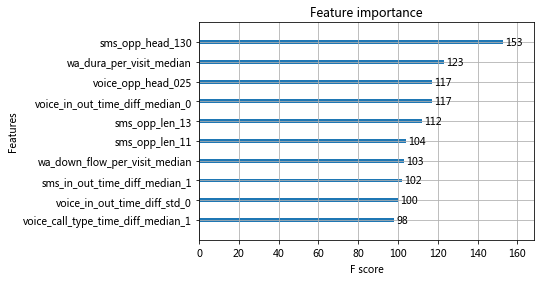

In [15]:
xgb1 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

modelfit(xgb1, train_X, train_y)

In [16]:
feature_importances_list = feature_importances_list.sort_values(by='importances', ascending=False)
feature_importances_list['importances'].sum()
len(feature_importances_list['importances'].unique())


1.0

83

In [17]:
feature_importances_list[feature_importances_list['importances'] > 0].head(60)

,feature_name,importances
583,sms_opp_head_130,0.023985
636,wa_dura_per_visit_median,0.019282
45,voice_in_out_time_diff_median_0,0.018341
180,voice_opp_head_025,0.018341
83,sms_opp_len_13,0.017558
81,sms_opp_len_11,0.016303
635,wa_down_flow_per_visit_median,0.016147
102,sms_in_out_time_diff_median_1,0.015990
43,voice_in_out_time_diff_std_0,0.015676
59,voice_call_type_time_diff_median_1,0.015363


In [52]:
feature_importances_list[feature_importances_list['feature_name'] == 'sms_opp_num_entropy']

,feature_name,importances
157,sms_opp_num_entropy,0.002522


# feature selection

In [113]:
xgb1.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 306,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': 1,
 'subsample': 0.8}

In [115]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# split data into train and test sets
X1, X2, y1, y2 = train_test_split(train_X, train_y, test_size=0.2, random_state=7)

def metric_SelectImportances(y, y_pred):

    pre = pd.DataFrame({'preds':y_pred, 'label':y})
    pre = pre.sort_values(by='preds', ascending=False)
    
    auc = metrics.roc_auc_score(pre.label, pre.preds)

    pre.preds = pre.preds.map(lambda x: 1 if x>=0.5 else 0)

    f1 = metrics.f1_score(pre.label, pre.preds) 
    
    res = 0.6*auc +0.4*f1
    
    return res

best_score_in_select = 0


# Fit model using each importance as a threshold
thresholds = feature_importances_list['importances'].unique()
for thresh in thresholds:
    # select features using threshold
#     selection = SelectFromModel(xgb1, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(train_X)
    selection = feature_importances_list[feature_importances_list['importances']>thresh]['feature_name']
    select_X_train = train_X[selection]
    
    # train model
    selection_model = XGBClassifier(learning_rate =0.1,
                                    n_estimators=1000,
                                    max_depth=5,
                                    min_child_weight=5,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    objective= 'binary:logistic',
                                    nthread=4,
                                    scale_pos_weight=1,
                                    seed=27)

    print('[threshold]:', thresh)
    xgb_param = selection_model.get_xgb_params()
    xgtrain = xgb.DMatrix(select_X_train, label=train_y)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=selection_model.get_params()['n_estimators'], nfold=5,
        feval=metric_xgb, maximize=True, early_stopping_rounds=100, verbose_eval=True, show_stdv=False)

    print('best-score', cvresult.tail(1)['test-metric_xgb-mean'])

    

[threshold]: 0.026181818917393684
[0]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[1]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3


/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[2]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[3]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[4]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[5]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[6]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[7]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[8]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[9]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[10]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[11]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[12]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[13]	train-error:0.180036	train-metric_xgb:0.3	test

[97]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[98]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
[99]	train-error:0.180036	train-metric_xgb:0.3	test-error:0.180035	test-metric_xgb:0.3
best-score 0    0.3
Name: test-metric_xgb-mean, dtype: float64
[threshold]: 0.02545454539358616
[0]	train-error:0.170884	train-metric_xgb:0.484226	test-error:0.178836	test-metric_xgb:0.45641
[1]	train-error:0.170434	train-metric_xgb:0.496566	test-error:0.175836	test-metric_xgb:0.470179
[2]	train-error:0.170734	train-metric_xgb:0.488982	test-error:0.174035	test-metric_xgb:0.465652
[3]	train-error:0.170384	train-metric_xgb:0.491675	test-error:0.174235	test-metric_xgb:0.465333
[4]	train-error:0.170484	train-metric_xgb:0.496429	test-error:0.173635	test-metric_xgb:0.469398
[5]	train-error:0.170534	train-metric_xgb:0.494122	test-error:0.174835	test-metric_xgb:0.461559
[6]	train-error:0.170134	train-metric_xgb:0.496561	test-error:0.1746

[82]	train-error:0.166433	train-metric_xgb:0.543613	test-error:0.175435	test-metric_xgb:0.463693
[83]	train-error:0.166083	train-metric_xgb:0.543675	test-error:0.175835	test-metric_xgb:0.462251
[84]	train-error:0.166083	train-metric_xgb:0.543801	test-error:0.175835	test-metric_xgb:0.462031
[85]	train-error:0.165983	train-metric_xgb:0.543998	test-error:0.176035	test-metric_xgb:0.461233
[86]	train-error:0.166133	train-metric_xgb:0.542849	test-error:0.176235	test-metric_xgb:0.46013
[87]	train-error:0.165633	train-metric_xgb:0.543568	test-error:0.176435	test-metric_xgb:0.458588
[88]	train-error:0.166183	train-metric_xgb:0.543612	test-error:0.176435	test-metric_xgb:0.459249
[89]	train-error:0.166283	train-metric_xgb:0.543831	test-error:0.176435	test-metric_xgb:0.458762
[90]	train-error:0.166033	train-metric_xgb:0.544569	test-error:0.176635	test-metric_xgb:0.458408
[91]	train-error:0.166083	train-metric_xgb:0.545689	test-error:0.176835	test-metric_xgb:0.460002
[92]	train-error:0.166433	train

[46]	train-error:0.162382	train-metric_xgb:0.538002	test-error:0.172833	test-metric_xgb:0.455681
[47]	train-error:0.162682	train-metric_xgb:0.538547	test-error:0.173033	test-metric_xgb:0.456061
[48]	train-error:0.162482	train-metric_xgb:0.538747	test-error:0.173033	test-metric_xgb:0.455693
[49]	train-error:0.162282	train-metric_xgb:0.540236	test-error:0.172633	test-metric_xgb:0.457741
[50]	train-error:0.162182	train-metric_xgb:0.541094	test-error:0.172433	test-metric_xgb:0.458185
[51]	train-error:0.162132	train-metric_xgb:0.542119	test-error:0.172633	test-metric_xgb:0.458639
[52]	train-error:0.162133	train-metric_xgb:0.542285	test-error:0.172834	test-metric_xgb:0.458498
[53]	train-error:0.162333	train-metric_xgb:0.54239	test-error:0.172834	test-metric_xgb:0.4575
[54]	train-error:0.162283	train-metric_xgb:0.543591	test-error:0.173034	test-metric_xgb:0.458153
[55]	train-error:0.162233	train-metric_xgb:0.543992	test-error:0.173034	test-metric_xgb:0.458102
[56]	train-error:0.162132	train-m

[131]	train-error:0.157981	train-metric_xgb:0.579989	test-error:0.175034	test-metric_xgb:0.457696
[132]	train-error:0.157882	train-metric_xgb:0.58059	test-error:0.174834	test-metric_xgb:0.457396
[133]	train-error:0.157782	train-metric_xgb:0.580973	test-error:0.175434	test-metric_xgb:0.456188
[134]	train-error:0.157432	train-metric_xgb:0.582142	test-error:0.175034	test-metric_xgb:0.457432
[135]	train-error:0.157432	train-metric_xgb:0.582695	test-error:0.174634	test-metric_xgb:0.458924
[136]	train-error:0.157431	train-metric_xgb:0.583118	test-error:0.174434	test-metric_xgb:0.459678
[137]	train-error:0.157231	train-metric_xgb:0.583796	test-error:0.174434	test-metric_xgb:0.459684
[138]	train-error:0.157432	train-metric_xgb:0.583602	test-error:0.174434	test-metric_xgb:0.459103
[139]	train-error:0.157482	train-metric_xgb:0.583754	test-error:0.174434	test-metric_xgb:0.458853
[140]	train-error:0.157331	train-metric_xgb:0.584142	test-error:0.174634	test-metric_xgb:0.459303
[141]	train-error:0.1

[9]	train-error:0.157431	train-metric_xgb:0.599198	test-error:0.164232	test-metric_xgb:0.563418
[10]	train-error:0.157632	train-metric_xgb:0.599477	test-error:0.164232	test-metric_xgb:0.563125
[11]	train-error:0.157182	train-metric_xgb:0.601502	test-error:0.164232	test-metric_xgb:0.563533
[12]	train-error:0.157131	train-metric_xgb:0.602245	test-error:0.164432	test-metric_xgb:0.562018
[13]	train-error:0.157182	train-metric_xgb:0.603478	test-error:0.165032	test-metric_xgb:0.561726
[14]	train-error:0.156732	train-metric_xgb:0.604871	test-error:0.164232	test-metric_xgb:0.562217
[15]	train-error:0.156581	train-metric_xgb:0.606098	test-error:0.163832	test-metric_xgb:0.563562
[16]	train-error:0.156131	train-metric_xgb:0.608431	test-error:0.163232	test-metric_xgb:0.567058
[17]	train-error:0.155781	train-metric_xgb:0.610321	test-error:0.163032	test-metric_xgb:0.567302
[18]	train-error:0.155231	train-metric_xgb:0.612718	test-error:0.163231	test-metric_xgb:0.568125
[19]	train-error:0.154981	train

[94]	train-error:0.137377	train-metric_xgb:0.704848	test-error:0.167032	test-metric_xgb:0.596529
[95]	train-error:0.137077	train-metric_xgb:0.706209	test-error:0.166832	test-metric_xgb:0.598184
[96]	train-error:0.136227	train-metric_xgb:0.70803	test-error:0.166432	test-metric_xgb:0.598299
[97]	train-error:0.136227	train-metric_xgb:0.7083	test-error:0.166832	test-metric_xgb:0.597966
[98]	train-error:0.136077	train-metric_xgb:0.708923	test-error:0.166632	test-metric_xgb:0.597943
[99]	train-error:0.135977	train-metric_xgb:0.709318	test-error:0.166632	test-metric_xgb:0.597962
[100]	train-error:0.135777	train-metric_xgb:0.709776	test-error:0.166032	test-metric_xgb:0.598108
[101]	train-error:0.135677	train-metric_xgb:0.710377	test-error:0.166632	test-metric_xgb:0.597486
[102]	train-error:0.135527	train-metric_xgb:0.71104	test-error:0.166632	test-metric_xgb:0.596667
[103]	train-error:0.135777	train-metric_xgb:0.710995	test-error:0.167032	test-metric_xgb:0.596827
[104]	train-error:0.135727	tra

[178]	train-error:0.122024	train-metric_xgb:0.755269	test-error:0.171034	test-metric_xgb:0.600504
[179]	train-error:0.121624	train-metric_xgb:0.756005	test-error:0.170834	test-metric_xgb:0.600609
[180]	train-error:0.121424	train-metric_xgb:0.756848	test-error:0.171634	test-metric_xgb:0.600138
[181]	train-error:0.121124	train-metric_xgb:0.757721	test-error:0.172234	test-metric_xgb:0.599313
[182]	train-error:0.121574	train-metric_xgb:0.75703	test-error:0.173634	test-metric_xgb:0.597766
[183]	train-error:0.121024	train-metric_xgb:0.758138	test-error:0.173634	test-metric_xgb:0.598204
[184]	train-error:0.121374	train-metric_xgb:0.757421	test-error:0.173034	test-metric_xgb:0.598933
[185]	train-error:0.121474	train-metric_xgb:0.756968	test-error:0.171433	test-metric_xgb:0.600618
[186]	train-error:0.121524	train-metric_xgb:0.757398	test-error:0.172434	test-metric_xgb:0.60003
[187]	train-error:0.121224	train-metric_xgb:0.757893	test-error:0.172234	test-metric_xgb:0.599677
[188]	train-error:0.12

[262]	train-error:0.111772	train-metric_xgb:0.786334	test-error:0.177834	test-metric_xgb:0.595521
[263]	train-error:0.111022	train-metric_xgb:0.78799	test-error:0.177234	test-metric_xgb:0.59536
[264]	train-error:0.111222	train-metric_xgb:0.787936	test-error:0.177635	test-metric_xgb:0.594936
[265]	train-error:0.111272	train-metric_xgb:0.78782	test-error:0.177434	test-metric_xgb:0.595194
[266]	train-error:0.111372	train-metric_xgb:0.787808	test-error:0.177635	test-metric_xgb:0.595502
[267]	train-error:0.111022	train-metric_xgb:0.788728	test-error:0.177235	test-metric_xgb:0.595146
[268]	train-error:0.110522	train-metric_xgb:0.7897	test-error:0.176635	test-metric_xgb:0.595845
[269]	train-error:0.110472	train-metric_xgb:0.789679	test-error:0.177235	test-metric_xgb:0.595037
[270]	train-error:0.110222	train-metric_xgb:0.790462	test-error:0.177235	test-metric_xgb:0.594628
[271]	train-error:0.109622	train-metric_xgb:0.791713	test-error:0.176835	test-metric_xgb:0.595209
[272]	train-error:0.10917

[74]	train-error:0.118023	train-metric_xgb:0.772144	test-error:0.15443	test-metric_xgb:0.665295
[75]	train-error:0.118023	train-metric_xgb:0.77239	test-error:0.15463	test-metric_xgb:0.66521
[76]	train-error:0.117673	train-metric_xgb:0.7733	test-error:0.155231	test-metric_xgb:0.664915
[77]	train-error:0.117273	train-metric_xgb:0.774059	test-error:0.155231	test-metric_xgb:0.664728
[78]	train-error:0.116923	train-metric_xgb:0.775136	test-error:0.15563	test-metric_xgb:0.664346
[79]	train-error:0.116473	train-metric_xgb:0.776636	test-error:0.15523	test-metric_xgb:0.664333
[80]	train-error:0.116073	train-metric_xgb:0.777652	test-error:0.15503	test-metric_xgb:0.664719
[81]	train-error:0.115173	train-metric_xgb:0.779558	test-error:0.15483	test-metric_xgb:0.664799
[82]	train-error:0.115273	train-metric_xgb:0.779476	test-error:0.15503	test-metric_xgb:0.664097
[83]	train-error:0.115123	train-metric_xgb:0.779957	test-error:0.155831	test-metric_xgb:0.6632
[84]	train-error:0.115073	train-metric_xgb:

[159]	train-error:0.0986196	train-metric_xgb:0.82476	test-error:0.160631	test-metric_xgb:0.658872
[160]	train-error:0.0980694	train-metric_xgb:0.826098	test-error:0.161031	test-metric_xgb:0.658571
[161]	train-error:0.0977194	train-metric_xgb:0.826807	test-error:0.161031	test-metric_xgb:0.658739
[162]	train-error:0.0975194	train-metric_xgb:0.827277	test-error:0.160831	test-metric_xgb:0.659135
[163]	train-error:0.0974694	train-metric_xgb:0.827638	test-error:0.160631	test-metric_xgb:0.659622
[164]	train-error:0.0968694	train-metric_xgb:0.828885	test-error:0.160831	test-metric_xgb:0.659454
[165]	train-error:0.0964694	train-metric_xgb:0.82972	test-error:0.161432	test-metric_xgb:0.658275
[166]	train-error:0.0963192	train-metric_xgb:0.829848	test-error:0.160631	test-metric_xgb:0.659215
[167]	train-error:0.0959692	train-metric_xgb:0.830599	test-error:0.161032	test-metric_xgb:0.658352
[168]	train-error:0.0959692	train-metric_xgb:0.830735	test-error:0.161031	test-metric_xgb:0.658579
[169]	train-

[36]	train-error:0.123825	train-metric_xgb:0.756486	test-error:0.15403	test-metric_xgb:0.669358
[37]	train-error:0.122775	train-metric_xgb:0.759472	test-error:0.15383	test-metric_xgb:0.670145
[38]	train-error:0.122874	train-metric_xgb:0.760728	test-error:0.15343	test-metric_xgb:0.671093
[39]	train-error:0.122224	train-metric_xgb:0.762937	test-error:0.154831	test-metric_xgb:0.669798
[40]	train-error:0.121324	train-metric_xgb:0.765454	test-error:0.15403	test-metric_xgb:0.67056
[41]	train-error:0.119874	train-metric_xgb:0.768972	test-error:0.15363	test-metric_xgb:0.672359
[42]	train-error:0.119074	train-metric_xgb:0.771238	test-error:0.15323	test-metric_xgb:0.673158
[43]	train-error:0.118374	train-metric_xgb:0.773343	test-error:0.15343	test-metric_xgb:0.673387
[44]	train-error:0.117824	train-metric_xgb:0.774706	test-error:0.15283	test-metric_xgb:0.675764
[45]	train-error:0.117274	train-metric_xgb:0.77669	test-error:0.15303	test-metric_xgb:0.675562
[46]	train-error:0.116673	train-metric_xg

[121]	train-error:0.0871674	train-metric_xgb:0.854067	test-error:0.15403	test-metric_xgb:0.685936
[122]	train-error:0.0872676	train-metric_xgb:0.854162	test-error:0.153631	test-metric_xgb:0.686914
[123]	train-error:0.0869176	train-metric_xgb:0.854869	test-error:0.15323	test-metric_xgb:0.688094
[124]	train-error:0.0860674	train-metric_xgb:0.856335	test-error:0.153631	test-metric_xgb:0.687535
[125]	train-error:0.0858672	train-metric_xgb:0.856811	test-error:0.15423	test-metric_xgb:0.685806
[126]	train-error:0.0856672	train-metric_xgb:0.857363	test-error:0.15463	test-metric_xgb:0.685723
[127]	train-error:0.084967	train-metric_xgb:0.858619	test-error:0.15383	test-metric_xgb:0.687027
[128]	train-error:0.0847168	train-metric_xgb:0.859225	test-error:0.153631	test-metric_xgb:0.68737
[129]	train-error:0.084767	train-metric_xgb:0.859489	test-error:0.15323	test-metric_xgb:0.687926
[130]	train-error:0.0846668	train-metric_xgb:0.859696	test-error:0.15323	test-metric_xgb:0.688482
[131]	train-error:0.

[205]	train-error:0.0667134	train-metric_xgb:0.897622	test-error:0.15563	test-metric_xgb:0.685029
[206]	train-error:0.0671134	train-metric_xgb:0.897339	test-error:0.156231	test-metric_xgb:0.683507
[207]	train-error:0.0667634	train-metric_xgb:0.898038	test-error:0.15623	test-metric_xgb:0.683194
[208]	train-error:0.0661134	train-metric_xgb:0.898894	test-error:0.156631	test-metric_xgb:0.682619
[209]	train-error:0.0661134	train-metric_xgb:0.899015	test-error:0.156631	test-metric_xgb:0.682316
[210]	train-error:0.0658634	train-metric_xgb:0.899461	test-error:0.156431	test-metric_xgb:0.682727
[211]	train-error:0.0659132	train-metric_xgb:0.899502	test-error:0.156631	test-metric_xgb:0.683279
[212]	train-error:0.0660634	train-metric_xgb:0.899334	test-error:0.156031	test-metric_xgb:0.684166
[213]	train-error:0.0660134	train-metric_xgb:0.899601	test-error:0.155631	test-metric_xgb:0.683748
[214]	train-error:0.0655132	train-metric_xgb:0.900401	test-error:0.156031	test-metric_xgb:0.683654
[215]	train-

[48]	train-error:0.113323	train-metric_xgb:0.788016	test-error:0.149629	test-metric_xgb:0.683245
[49]	train-error:0.112623	train-metric_xgb:0.790238	test-error:0.149429	test-metric_xgb:0.684232
[50]	train-error:0.112223	train-metric_xgb:0.791608	test-error:0.149829	test-metric_xgb:0.684534
[51]	train-error:0.111872	train-metric_xgb:0.792519	test-error:0.149429	test-metric_xgb:0.685372
[52]	train-error:0.111473	train-metric_xgb:0.793846	test-error:0.149429	test-metric_xgb:0.685531
[53]	train-error:0.111122	train-metric_xgb:0.794819	test-error:0.149629	test-metric_xgb:0.685966
[54]	train-error:0.110722	train-metric_xgb:0.796426	test-error:0.15063	test-metric_xgb:0.685177
[55]	train-error:0.109522	train-metric_xgb:0.79898	test-error:0.15063	test-metric_xgb:0.68481
[56]	train-error:0.109122	train-metric_xgb:0.799955	test-error:0.150029	test-metric_xgb:0.686448
[57]	train-error:0.108522	train-metric_xgb:0.801896	test-error:0.15023	test-metric_xgb:0.686732
[58]	train-error:0.108272	train-met

[133]	train-error:0.0785658	train-metric_xgb:0.874413	test-error:0.15383	test-metric_xgb:0.690242
[134]	train-error:0.0785658	train-metric_xgb:0.874689	test-error:0.15423	test-metric_xgb:0.68947
[135]	train-error:0.0782158	train-metric_xgb:0.875199	test-error:0.155031	test-metric_xgb:0.688261
[136]	train-error:0.0780158	train-metric_xgb:0.875627	test-error:0.15403	test-metric_xgb:0.690468
[137]	train-error:0.0775156	train-metric_xgb:0.876783	test-error:0.15383	test-metric_xgb:0.690113
[138]	train-error:0.0766654	train-metric_xgb:0.878336	test-error:0.15383	test-metric_xgb:0.690111
[139]	train-error:0.0760152	train-metric_xgb:0.87956	test-error:0.153631	test-metric_xgb:0.689455
[140]	train-error:0.0756152	train-metric_xgb:0.880322	test-error:0.15463	test-metric_xgb:0.6894
[141]	train-error:0.0758652	train-metric_xgb:0.88004	test-error:0.15463	test-metric_xgb:0.689454
[142]	train-error:0.0756652	train-metric_xgb:0.880554	test-error:0.15483	test-metric_xgb:0.689808
[143]	train-error:0.075

[47]	train-error:0.102671	train-metric_xgb:0.824694	test-error:0.145429	test-metric_xgb:0.726888
[48]	train-error:0.102721	train-metric_xgb:0.82509	test-error:0.144429	test-metric_xgb:0.729271
[49]	train-error:0.10182	train-metric_xgb:0.826759	test-error:0.144429	test-metric_xgb:0.729287
[50]	train-error:0.101971	train-metric_xgb:0.826782	test-error:0.143829	test-metric_xgb:0.729342
[51]	train-error:0.102021	train-metric_xgb:0.827597	test-error:0.144428	test-metric_xgb:0.729311
[52]	train-error:0.10157	train-metric_xgb:0.828767	test-error:0.146229	test-metric_xgb:0.727063
[53]	train-error:0.10037	train-metric_xgb:0.830849	test-error:0.14683	test-metric_xgb:0.725975
[54]	train-error:0.09947	train-metric_xgb:0.832839	test-error:0.14723	test-metric_xgb:0.7261
[55]	train-error:0.09982	train-metric_xgb:0.832816	test-error:0.148631	test-metric_xgb:0.724414
[56]	train-error:0.09892	train-metric_xgb:0.834503	test-error:0.14803	test-metric_xgb:0.724931
[57]	train-error:0.09867	train-metric_xgb:

[132]	train-error:0.0682636	train-metric_xgb:0.898019	test-error:0.149431	test-metric_xgb:0.730568
[133]	train-error:0.0684136	train-metric_xgb:0.897973	test-error:0.148631	test-metric_xgb:0.73154
[134]	train-error:0.0679136	train-metric_xgb:0.898676	test-error:0.148231	test-metric_xgb:0.731275
[135]	train-error:0.0673636	train-metric_xgb:0.899701	test-error:0.148431	test-metric_xgb:0.731397
[136]	train-error:0.0674134	train-metric_xgb:0.899842	test-error:0.148832	test-metric_xgb:0.731111
[137]	train-error:0.0671134	train-metric_xgb:0.900356	test-error:0.149232	test-metric_xgb:0.730276
[138]	train-error:0.0667134	train-metric_xgb:0.901133	test-error:0.149231	test-metric_xgb:0.72972
[139]	train-error:0.0663134	train-metric_xgb:0.901833	test-error:0.148631	test-metric_xgb:0.730233
[140]	train-error:0.0663632	train-metric_xgb:0.901882	test-error:0.148631	test-metric_xgb:0.730414
[141]	train-error:0.0659132	train-metric_xgb:0.902664	test-error:0.148231	test-metric_xgb:0.730968
[142]	train-

[216]	train-error:0.0453592	train-metric_xgb:0.93785	test-error:0.14943	test-metric_xgb:0.729037
[217]	train-error:0.0455094	train-metric_xgb:0.937709	test-error:0.149831	test-metric_xgb:0.728177
[218]	train-error:0.0454594	train-metric_xgb:0.9378	test-error:0.150031	test-metric_xgb:0.727991
best-score 119    0.733507
Name: test-metric_xgb-mean, dtype: float64
[threshold]: 0.0181818176060915
[0]	train-error:0.14978	train-metric_xgb:0.67799	test-error:0.165831	test-metric_xgb:0.642239
[1]	train-error:0.141629	train-metric_xgb:0.714056	test-error:0.154829	test-metric_xgb:0.678789
[2]	train-error:0.140128	train-metric_xgb:0.714686	test-error:0.153829	test-metric_xgb:0.677197
[3]	train-error:0.139028	train-metric_xgb:0.716367	test-error:0.153831	test-metric_xgb:0.675444
[4]	train-error:0.136927	train-metric_xgb:0.723006	test-error:0.153432	test-metric_xgb:0.678446
[5]	train-error:0.136127	train-metric_xgb:0.725424	test-error:0.154232	test-metric_xgb:0.673926
[6]	train-error:0.135577	train-

[81]	train-error:0.0828668	train-metric_xgb:0.868485	test-error:0.146829	test-metric_xgb:0.732353
[82]	train-error:0.0822666	train-metric_xgb:0.86963	test-error:0.145829	test-metric_xgb:0.734026
[83]	train-error:0.0821666	train-metric_xgb:0.870019	test-error:0.146429	test-metric_xgb:0.733608
[84]	train-error:0.0821666	train-metric_xgb:0.870675	test-error:0.147229	test-metric_xgb:0.73176
[85]	train-error:0.0817166	train-metric_xgb:0.871544	test-error:0.146629	test-metric_xgb:0.732427
[86]	train-error:0.0817664	train-metric_xgb:0.871506	test-error:0.146629	test-metric_xgb:0.733233
[87]	train-error:0.0810164	train-metric_xgb:0.872989	test-error:0.145829	test-metric_xgb:0.734721
[88]	train-error:0.080616	train-metric_xgb:0.873741	test-error:0.145629	test-metric_xgb:0.734872
[89]	train-error:0.080016	train-metric_xgb:0.874723	test-error:0.145428	test-metric_xgb:0.734882
[90]	train-error:0.079616	train-metric_xgb:0.87541	test-error:0.145628	test-metric_xgb:0.735099
[91]	train-error:0.0786158

[165]	train-error:0.0533606	train-metric_xgb:0.924877	test-error:0.152231	test-metric_xgb:0.725063
[166]	train-error:0.0531608	train-metric_xgb:0.9252	test-error:0.152231	test-metric_xgb:0.725953
[167]	train-error:0.0521606	train-metric_xgb:0.926634	test-error:0.152431	test-metric_xgb:0.726144
[168]	train-error:0.0519606	train-metric_xgb:0.926998	test-error:0.152631	test-metric_xgb:0.725686
[169]	train-error:0.0521606	train-metric_xgb:0.926889	test-error:0.152831	test-metric_xgb:0.725172
[170]	train-error:0.0517106	train-metric_xgb:0.927562	test-error:0.154031	test-metric_xgb:0.724073
[171]	train-error:0.0512104	train-metric_xgb:0.928301	test-error:0.153031	test-metric_xgb:0.725202
[172]	train-error:0.0508604	train-metric_xgb:0.928882	test-error:0.153831	test-metric_xgb:0.724206
[173]	train-error:0.0509604	train-metric_xgb:0.928838	test-error:0.153031	test-metric_xgb:0.725001
[174]	train-error:0.0505604	train-metric_xgb:0.929435	test-error:0.153231	test-metric_xgb:0.724722
[175]	train-

[59]	train-error:0.0922188	train-metric_xgb:0.848293	test-error:0.14323	test-metric_xgb:0.733643
[60]	train-error:0.0909684	train-metric_xgb:0.850662	test-error:0.14423	test-metric_xgb:0.733271
[61]	train-error:0.0908182	train-metric_xgb:0.851189	test-error:0.14463	test-metric_xgb:0.732534
[62]	train-error:0.0904182	train-metric_xgb:0.852072	test-error:0.14443	test-metric_xgb:0.732704
[63]	train-error:0.0900682	train-metric_xgb:0.853022	test-error:0.14343	test-metric_xgb:0.734153
[64]	train-error:0.0897182	train-metric_xgb:0.853894	test-error:0.14443	test-metric_xgb:0.732959
[65]	train-error:0.088618	train-metric_xgb:0.856001	test-error:0.143429	test-metric_xgb:0.735596
[66]	train-error:0.0881176	train-metric_xgb:0.857067	test-error:0.14383	test-metric_xgb:0.735606
[67]	train-error:0.088118	train-metric_xgb:0.857231	test-error:0.14303	test-metric_xgb:0.736148
[68]	train-error:0.0862676	train-metric_xgb:0.860496	test-error:0.14343	test-metric_xgb:0.7359
[69]	train-error:0.0854672	train-

[143]	train-error:0.0537608	train-metric_xgb:0.923031	test-error:0.144629	test-metric_xgb:0.737653
[144]	train-error:0.0533606	train-metric_xgb:0.923676	test-error:0.143429	test-metric_xgb:0.73956
[145]	train-error:0.0531606	train-metric_xgb:0.924108	test-error:0.143629	test-metric_xgb:0.739655
[146]	train-error:0.0533108	train-metric_xgb:0.92399	test-error:0.143629	test-metric_xgb:0.739859
[147]	train-error:0.0525106	train-metric_xgb:0.925206	test-error:0.143429	test-metric_xgb:0.739698
[148]	train-error:0.0523606	train-metric_xgb:0.925448	test-error:0.143829	test-metric_xgb:0.738928
[149]	train-error:0.0524106	train-metric_xgb:0.925601	test-error:0.144229	test-metric_xgb:0.738033
[150]	train-error:0.0521606	train-metric_xgb:0.925966	test-error:0.144629	test-metric_xgb:0.737811
[151]	train-error:0.0519106	train-metric_xgb:0.926418	test-error:0.144829	test-metric_xgb:0.73848
[152]	train-error:0.0512604	train-metric_xgb:0.927424	test-error:0.145229	test-metric_xgb:0.736995
[153]	train-e

[15]	train-error:0.125825	train-metric_xgb:0.757646	test-error:0.146828	test-metric_xgb:0.699169
[16]	train-error:0.125525	train-metric_xgb:0.759232	test-error:0.145428	test-metric_xgb:0.702451
[17]	train-error:0.124375	train-metric_xgb:0.762469	test-error:0.145428	test-metric_xgb:0.701929
[18]	train-error:0.123675	train-metric_xgb:0.764417	test-error:0.145429	test-metric_xgb:0.701107
[19]	train-error:0.122875	train-metric_xgb:0.767767	test-error:0.14723	test-metric_xgb:0.70115
[20]	train-error:0.121724	train-metric_xgb:0.770154	test-error:0.144829	test-metric_xgb:0.704627
[21]	train-error:0.120324	train-metric_xgb:0.774389	test-error:0.145228	test-metric_xgb:0.706757
[22]	train-error:0.119624	train-metric_xgb:0.776892	test-error:0.145229	test-metric_xgb:0.707383
[23]	train-error:0.118224	train-metric_xgb:0.780731	test-error:0.145029	test-metric_xgb:0.710117
[24]	train-error:0.117273	train-metric_xgb:0.783453	test-error:0.14563	test-metric_xgb:0.709886
[25]	train-error:0.115923	train-m

[100]	train-error:0.069814	train-metric_xgb:0.894217	test-error:0.144429	test-metric_xgb:0.738466
[101]	train-error:0.069364	train-metric_xgb:0.895189	test-error:0.144629	test-metric_xgb:0.737955
[102]	train-error:0.068564	train-metric_xgb:0.896426	test-error:0.144829	test-metric_xgb:0.737485
[103]	train-error:0.0679638	train-metric_xgb:0.897601	test-error:0.145029	test-metric_xgb:0.737592
[104]	train-error:0.0674636	train-metric_xgb:0.89855	test-error:0.145229	test-metric_xgb:0.737017
[105]	train-error:0.0669634	train-metric_xgb:0.89958	test-error:0.145029	test-metric_xgb:0.737889
[106]	train-error:0.0666134	train-metric_xgb:0.900109	test-error:0.145029	test-metric_xgb:0.738142
[107]	train-error:0.0663134	train-metric_xgb:0.900774	test-error:0.145229	test-metric_xgb:0.737945
[108]	train-error:0.0662634	train-metric_xgb:0.900959	test-error:0.145829	test-metric_xgb:0.736742
[109]	train-error:0.0655634	train-metric_xgb:0.902124	test-error:0.145229	test-metric_xgb:0.737668
[110]	train-err

[184]	train-error:0.0411586	train-metric_xgb:0.944137	test-error:0.15103	test-metric_xgb:0.732803
[185]	train-error:0.040808	train-metric_xgb:0.944691	test-error:0.15063	test-metric_xgb:0.733482
[186]	train-error:0.0407584	train-metric_xgb:0.944781	test-error:0.15083	test-metric_xgb:0.733645
[187]	train-error:0.0407582	train-metric_xgb:0.944914	test-error:0.151031	test-metric_xgb:0.733593
[188]	train-error:0.0404582	train-metric_xgb:0.945414	test-error:0.151231	test-metric_xgb:0.733218
[189]	train-error:0.0406584	train-metric_xgb:0.945202	test-error:0.150431	test-metric_xgb:0.733485
[190]	train-error:0.0402082	train-metric_xgb:0.945903	test-error:0.150831	test-metric_xgb:0.732375
[191]	train-error:0.040058	train-metric_xgb:0.946163	test-error:0.15083	test-metric_xgb:0.732935
[192]	train-error:0.039558	train-metric_xgb:0.946851	test-error:0.151431	test-metric_xgb:0.73228
[193]	train-error:0.039158	train-metric_xgb:0.947349	test-error:0.15103	test-metric_xgb:0.732501
[194]	train-error:0.

[69]	train-error:0.0822164	train-metric_xgb:0.86816	test-error:0.141429	test-metric_xgb:0.734756
[70]	train-error:0.0815164	train-metric_xgb:0.869604	test-error:0.14383	test-metric_xgb:0.732387
[71]	train-error:0.0814164	train-metric_xgb:0.870241	test-error:0.14403	test-metric_xgb:0.731887
[72]	train-error:0.080616	train-metric_xgb:0.871536	test-error:0.14343	test-metric_xgb:0.73178
[73]	train-error:0.0806162	train-metric_xgb:0.871779	test-error:0.14343	test-metric_xgb:0.73269
[74]	train-error:0.0807162	train-metric_xgb:0.871663	test-error:0.14323	test-metric_xgb:0.733516
[75]	train-error:0.0798162	train-metric_xgb:0.873456	test-error:0.14243	test-metric_xgb:0.734178
[76]	train-error:0.0791158	train-metric_xgb:0.875164	test-error:0.143029	test-metric_xgb:0.732046
[77]	train-error:0.0784158	train-metric_xgb:0.876522	test-error:0.141829	test-metric_xgb:0.733615
[78]	train-error:0.0774656	train-metric_xgb:0.878168	test-error:0.142028	test-metric_xgb:0.735153
[79]	train-error:0.0771154	tra

[153]	train-error:0.0466592	train-metric_xgb:0.93507	test-error:0.145829	test-metric_xgb:0.73419
[154]	train-error:0.0463094	train-metric_xgb:0.935623	test-error:0.146029	test-metric_xgb:0.734152
[155]	train-error:0.0462592	train-metric_xgb:0.935768	test-error:0.145629	test-metric_xgb:0.733822
[156]	train-error:0.0461594	train-metric_xgb:0.9359	test-error:0.145229	test-metric_xgb:0.734136
[157]	train-error:0.045309	train-metric_xgb:0.937164	test-error:0.145229	test-metric_xgb:0.73407
[158]	train-error:0.044809	train-metric_xgb:0.937905	test-error:0.144629	test-metric_xgb:0.735204
[159]	train-error:0.0446588	train-metric_xgb:0.938211	test-error:0.144429	test-metric_xgb:0.735689
[160]	train-error:0.0443088	train-metric_xgb:0.938737	test-error:0.144429	test-metric_xgb:0.735572
[161]	train-error:0.0442088	train-metric_xgb:0.938979	test-error:0.14483	test-metric_xgb:0.735936
[162]	train-error:0.0438086	train-metric_xgb:0.939623	test-error:0.144429	test-metric_xgb:0.736432
[163]	train-error:

[33]	train-error:0.107272	train-metric_xgb:0.812286	test-error:0.142029	test-metric_xgb:0.728053
[34]	train-error:0.106972	train-metric_xgb:0.813443	test-error:0.14303	test-metric_xgb:0.727581
[35]	train-error:0.106121	train-metric_xgb:0.81571	test-error:0.143829	test-metric_xgb:0.727142
[36]	train-error:0.105121	train-metric_xgb:0.817995	test-error:0.14463	test-metric_xgb:0.727516
[37]	train-error:0.104271	train-metric_xgb:0.819967	test-error:0.14423	test-metric_xgb:0.728228
[38]	train-error:0.103471	train-metric_xgb:0.821931	test-error:0.144629	test-metric_xgb:0.728168
[39]	train-error:0.102321	train-metric_xgb:0.824329	test-error:0.14443	test-metric_xgb:0.728625
[40]	train-error:0.10097	train-metric_xgb:0.827172	test-error:0.142629	test-metric_xgb:0.730875
[41]	train-error:0.10112	train-metric_xgb:0.827757	test-error:0.142629	test-metric_xgb:0.73167
[42]	train-error:0.09992	train-metric_xgb:0.830107	test-error:0.142029	test-metric_xgb:0.732433
[43]	train-error:0.09907	train-metric_x

[117]	train-error:0.0577114	train-metric_xgb:0.916635	test-error:0.142829	test-metric_xgb:0.742705
[118]	train-error:0.0573616	train-metric_xgb:0.917316	test-error:0.142029	test-metric_xgb:0.743888
[119]	train-error:0.0568616	train-metric_xgb:0.91806	test-error:0.142829	test-metric_xgb:0.743245
[120]	train-error:0.0568112	train-metric_xgb:0.9183	test-error:0.142829	test-metric_xgb:0.74334
[121]	train-error:0.0563612	train-metric_xgb:0.919131	test-error:0.142628	test-metric_xgb:0.742865
[122]	train-error:0.0562612	train-metric_xgb:0.91942	test-error:0.142428	test-metric_xgb:0.742643
[123]	train-error:0.055711	train-metric_xgb:0.920318	test-error:0.142829	test-metric_xgb:0.742456
[124]	train-error:0.0556112	train-metric_xgb:0.920544	test-error:0.143229	test-metric_xgb:0.742395
[125]	train-error:0.0550608	train-metric_xgb:0.921395	test-error:0.143429	test-metric_xgb:0.741737
[126]	train-error:0.055011	train-metric_xgb:0.92161	test-error:0.144029	test-metric_xgb:0.74145
[127]	train-error:0

[7]	train-error:0.127326	train-metric_xgb:0.755683	test-error:0.148029	test-metric_xgb:0.695099
[8]	train-error:0.128276	train-metric_xgb:0.751029	test-error:0.14943	test-metric_xgb:0.689713
[9]	train-error:0.127225	train-metric_xgb:0.756169	test-error:0.14743	test-metric_xgb:0.6962
[10]	train-error:0.125025	train-metric_xgb:0.761208	test-error:0.146429	test-metric_xgb:0.700909
[11]	train-error:0.123575	train-metric_xgb:0.767018	test-error:0.145429	test-metric_xgb:0.70623
[12]	train-error:0.121374	train-metric_xgb:0.772777	test-error:0.147229	test-metric_xgb:0.704091
[13]	train-error:0.121324	train-metric_xgb:0.773809	test-error:0.147029	test-metric_xgb:0.704565
[14]	train-error:0.119174	train-metric_xgb:0.779457	test-error:0.146229	test-metric_xgb:0.708511
[15]	train-error:0.118974	train-metric_xgb:0.780224	test-error:0.146829	test-metric_xgb:0.708338
[16]	train-error:0.117674	train-metric_xgb:0.783898	test-error:0.145629	test-metric_xgb:0.711781
[17]	train-error:0.116373	train-metric

[92]	train-error:0.0624624	train-metric_xgb:0.9084	test-error:0.14423	test-metric_xgb:0.741864
[93]	train-error:0.0616624	train-metric_xgb:0.909712	test-error:0.14323	test-metric_xgb:0.743466
[94]	train-error:0.0610122	train-metric_xgb:0.910829	test-error:0.142431	test-metric_xgb:0.744391
[95]	train-error:0.060362	train-metric_xgb:0.911966	test-error:0.143031	test-metric_xgb:0.743828
[96]	train-error:0.0602622	train-metric_xgb:0.912233	test-error:0.143231	test-metric_xgb:0.743673
[97]	train-error:0.0597122	train-metric_xgb:0.913266	test-error:0.14163	test-metric_xgb:0.745712
[98]	train-error:0.0596622	train-metric_xgb:0.913516	test-error:0.14203	test-metric_xgb:0.744908
[99]	train-error:0.058812	train-metric_xgb:0.914867	test-error:0.14143	test-metric_xgb:0.745717
[100]	train-error:0.058412	train-metric_xgb:0.915665	test-error:0.14083	test-metric_xgb:0.746119
[101]	train-error:0.0577118	train-metric_xgb:0.916733	test-error:0.14223	test-metric_xgb:0.744554
[102]	train-error:0.0569114	tr

[176]	train-error:0.0294062	train-metric_xgb:0.962182	test-error:0.143429	test-metric_xgb:0.748101
[177]	train-error:0.029106	train-metric_xgb:0.962645	test-error:0.14243	test-metric_xgb:0.749551
[178]	train-error:0.028956	train-metric_xgb:0.962887	test-error:0.141829	test-metric_xgb:0.750133
[179]	train-error:0.0286558	train-metric_xgb:0.963323	test-error:0.141829	test-metric_xgb:0.750124
[180]	train-error:0.0283556	train-metric_xgb:0.963749	test-error:0.143229	test-metric_xgb:0.747159
[181]	train-error:0.0283058	train-metric_xgb:0.963824	test-error:0.142829	test-metric_xgb:0.748245
[182]	train-error:0.0284058	train-metric_xgb:0.963764	test-error:0.14183	test-metric_xgb:0.749728
[183]	train-error:0.0280056	train-metric_xgb:0.964309	test-error:0.14123	test-metric_xgb:0.75113
[184]	train-error:0.0276056	train-metric_xgb:0.964853	test-error:0.14163	test-metric_xgb:0.751014
[185]	train-error:0.0276556	train-metric_xgb:0.964847	test-error:0.14083	test-metric_xgb:0.751977
[186]	train-error:

[260]	train-error:0.0131526	train-metric_xgb:0.984289	test-error:0.14563	test-metric_xgb:0.745626
[261]	train-error:0.0128526	train-metric_xgb:0.984649	test-error:0.14543	test-metric_xgb:0.745907
[262]	train-error:0.0128028	train-metric_xgb:0.984723	test-error:0.14543	test-metric_xgb:0.745858
[263]	train-error:0.0131528	train-metric_xgb:0.984342	test-error:0.14543	test-metric_xgb:0.746147
[264]	train-error:0.0125524	train-metric_xgb:0.985056	test-error:0.14443	test-metric_xgb:0.746805
[265]	train-error:0.0122524	train-metric_xgb:0.985415	test-error:0.14523	test-metric_xgb:0.74605
[266]	train-error:0.0122024	train-metric_xgb:0.985483	test-error:0.14463	test-metric_xgb:0.746407
[267]	train-error:0.0123024	train-metric_xgb:0.985374	test-error:0.14503	test-metric_xgb:0.746657
[268]	train-error:0.0120024	train-metric_xgb:0.985723	test-error:0.14503	test-metric_xgb:0.746626
[269]	train-error:0.0121024	train-metric_xgb:0.985618	test-error:0.14463	test-metric_xgb:0.747288
[270]	train-error:0.0

[53]	train-error:0.088718	train-metric_xgb:0.85864	test-error:0.141429	test-metric_xgb:0.741043
[54]	train-error:0.088318	train-metric_xgb:0.859956	test-error:0.140629	test-metric_xgb:0.743957
[55]	train-error:0.0870674	train-metric_xgb:0.862529	test-error:0.142629	test-metric_xgb:0.740463
[56]	train-error:0.0863672	train-metric_xgb:0.863917	test-error:0.141229	test-metric_xgb:0.74305
[57]	train-error:0.0857172	train-metric_xgb:0.86525	test-error:0.142429	test-metric_xgb:0.741775
[58]	train-error:0.084717	train-metric_xgb:0.867089	test-error:0.141829	test-metric_xgb:0.74256
[59]	train-error:0.084367	train-metric_xgb:0.867977	test-error:0.141429	test-metric_xgb:0.743608
[60]	train-error:0.0832168	train-metric_xgb:0.870008	test-error:0.140629	test-metric_xgb:0.744577
[61]	train-error:0.0825168	train-metric_xgb:0.871644	test-error:0.142229	test-metric_xgb:0.742829
[62]	train-error:0.0823668	train-metric_xgb:0.87216	test-error:0.141229	test-metric_xgb:0.744112
[63]	train-error:0.0817164	tr

[137]	train-error:0.0430588	train-metric_xgb:0.941813	test-error:0.139629	test-metric_xgb:0.751385
[138]	train-error:0.0425586	train-metric_xgb:0.942582	test-error:0.139629	test-metric_xgb:0.751622
[139]	train-error:0.0425586	train-metric_xgb:0.942762	test-error:0.138829	test-metric_xgb:0.752082
[140]	train-error:0.0421584	train-metric_xgb:0.94329	test-error:0.139429	test-metric_xgb:0.751936
[141]	train-error:0.0417584	train-metric_xgb:0.943927	test-error:0.14083	test-metric_xgb:0.749931
[142]	train-error:0.0411582	train-metric_xgb:0.944767	test-error:0.139829	test-metric_xgb:0.750935
[143]	train-error:0.0415084	train-metric_xgb:0.944401	test-error:0.139629	test-metric_xgb:0.751285
[144]	train-error:0.0408084	train-metric_xgb:0.945477	test-error:0.139029	test-metric_xgb:0.752172
[145]	train-error:0.040058	train-metric_xgb:0.9465	test-error:0.139829	test-metric_xgb:0.750925
[146]	train-error:0.040008	train-metric_xgb:0.946622	test-error:0.139629	test-metric_xgb:0.750937
[147]	train-erro

[221]	train-error:0.018804	train-metric_xgb:0.977023	test-error:0.14243	test-metric_xgb:0.74889
[222]	train-error:0.018704	train-metric_xgb:0.977154	test-error:0.141029	test-metric_xgb:0.750805
[223]	train-error:0.018904	train-metric_xgb:0.976942	test-error:0.14143	test-metric_xgb:0.750489
[224]	train-error:0.018554	train-metric_xgb:0.977377	test-error:0.141629	test-metric_xgb:0.749405
[225]	train-error:0.018254	train-metric_xgb:0.977769	test-error:0.140829	test-metric_xgb:0.750354
[226]	train-error:0.018204	train-metric_xgb:0.977866	test-error:0.139829	test-metric_xgb:0.751905
[227]	train-error:0.018504	train-metric_xgb:0.977508	test-error:0.140229	test-metric_xgb:0.751045
[228]	train-error:0.018104	train-metric_xgb:0.978016	test-error:0.139829	test-metric_xgb:0.751353
[229]	train-error:0.0178036	train-metric_xgb:0.978393	test-error:0.14003	test-metric_xgb:0.75101
[230]	train-error:0.0174534	train-metric_xgb:0.978837	test-error:0.14063	test-metric_xgb:0.75049
[231]	train-error:0.01735

[52]	train-error:0.0814164	train-metric_xgb:0.874998	test-error:0.137228	test-metric_xgb:0.755727
[53]	train-error:0.080166	train-metric_xgb:0.877174	test-error:0.137628	test-metric_xgb:0.755666
[54]	train-error:0.079416	train-metric_xgb:0.878602	test-error:0.136428	test-metric_xgb:0.757221
[55]	train-error:0.0788658	train-metric_xgb:0.879628	test-error:0.136428	test-metric_xgb:0.756901
[56]	train-error:0.0780656	train-metric_xgb:0.881128	test-error:0.136229	test-metric_xgb:0.757237
[57]	train-error:0.0769652	train-metric_xgb:0.883094	test-error:0.136629	test-metric_xgb:0.757588
[58]	train-error:0.0760152	train-metric_xgb:0.884902	test-error:0.136629	test-metric_xgb:0.757118
[59]	train-error:0.0757152	train-metric_xgb:0.885514	test-error:0.137429	test-metric_xgb:0.756227
[60]	train-error:0.074515	train-metric_xgb:0.887447	test-error:0.137229	test-metric_xgb:0.756279
[61]	train-error:0.0726646	train-metric_xgb:0.890305	test-error:0.137829	test-metric_xgb:0.755512
[62]	train-error:0.0720

[136]	train-error:0.0325564	train-metric_xgb:0.957311	test-error:0.142028	test-metric_xgb:0.754268
[137]	train-error:0.0322564	train-metric_xgb:0.957825	test-error:0.142828	test-metric_xgb:0.752845
[138]	train-error:0.0316562	train-metric_xgb:0.958678	test-error:0.142628	test-metric_xgb:0.753307
[139]	train-error:0.0310562	train-metric_xgb:0.959471	test-error:0.142228	test-metric_xgb:0.753779
[140]	train-error:0.0308562	train-metric_xgb:0.959758	test-error:0.142428	test-metric_xgb:0.753643
[141]	train-error:0.030106	train-metric_xgb:0.960821	test-error:0.143428	test-metric_xgb:0.75254
[142]	train-error:0.0299058	train-metric_xgb:0.961157	test-error:0.143829	test-metric_xgb:0.752033
[143]	train-error:0.0297558	train-metric_xgb:0.961414	test-error:0.142828	test-metric_xgb:0.753043
[144]	train-error:0.0292058	train-metric_xgb:0.962124	test-error:0.143428	test-metric_xgb:0.752596
[145]	train-error:0.0289058	train-metric_xgb:0.962558	test-error:0.143428	test-metric_xgb:0.752096
[146]	train-

[63]	train-error:0.0730648	train-metric_xgb:0.891011	test-error:0.139027	test-metric_xgb:0.754844
[64]	train-error:0.0729144	train-metric_xgb:0.891602	test-error:0.139028	test-metric_xgb:0.755372
[65]	train-error:0.0717144	train-metric_xgb:0.893611	test-error:0.139628	test-metric_xgb:0.754331
[66]	train-error:0.0709642	train-metric_xgb:0.894756	test-error:0.140429	test-metric_xgb:0.753608
[67]	train-error:0.070714	train-metric_xgb:0.895299	test-error:0.141228	test-metric_xgb:0.753122
[68]	train-error:0.0698138	train-metric_xgb:0.896769	test-error:0.140028	test-metric_xgb:0.75475
[69]	train-error:0.0695638	train-metric_xgb:0.897461	test-error:0.140428	test-metric_xgb:0.754167
[70]	train-error:0.0686638	train-metric_xgb:0.898763	test-error:0.140628	test-metric_xgb:0.754246
[71]	train-error:0.0676136	train-metric_xgb:0.900503	test-error:0.141029	test-metric_xgb:0.753594
[72]	train-error:0.0667634	train-metric_xgb:0.902268	test-error:0.140629	test-metric_xgb:0.753713
[73]	train-error:0.065

[147]	train-error:0.0282556	train-metric_xgb:0.963433	test-error:0.144428	test-metric_xgb:0.753648
[148]	train-error:0.0287058	train-metric_xgb:0.962896	test-error:0.144228	test-metric_xgb:0.754045
[149]	train-error:0.0282558	train-metric_xgb:0.963513	test-error:0.143628	test-metric_xgb:0.754517
[150]	train-error:0.0278558	train-metric_xgb:0.964079	test-error:0.144029	test-metric_xgb:0.754207
[151]	train-error:0.0274558	train-metric_xgb:0.96466	test-error:0.142828	test-metric_xgb:0.75595
[152]	train-error:0.0273558	train-metric_xgb:0.96486	test-error:0.143828	test-metric_xgb:0.754873
[153]	train-error:0.0269556	train-metric_xgb:0.965405	test-error:0.145228	test-metric_xgb:0.752725
[154]	train-error:0.0265054	train-metric_xgb:0.966014	test-error:0.145428	test-metric_xgb:0.751991
[155]	train-error:0.0264556	train-metric_xgb:0.966108	test-error:0.145228	test-metric_xgb:0.752085
[156]	train-error:0.0262056	train-metric_xgb:0.966513	test-error:0.144028	test-metric_xgb:0.753174
[157]	train-e

[69]	train-error:0.0679136	train-metric_xgb:0.900166	test-error:0.136028	test-metric_xgb:0.760897
[70]	train-error:0.0673134	train-metric_xgb:0.901308	test-error:0.135829	test-metric_xgb:0.761098
[71]	train-error:0.0662132	train-metric_xgb:0.903082	test-error:0.136629	test-metric_xgb:0.760718
[72]	train-error:0.0652632	train-metric_xgb:0.904452	test-error:0.136428	test-metric_xgb:0.760998
[73]	train-error:0.064563	train-metric_xgb:0.905788	test-error:0.135828	test-metric_xgb:0.761692
[74]	train-error:0.0638128	train-metric_xgb:0.907136	test-error:0.135828	test-metric_xgb:0.762122
[75]	train-error:0.0633126	train-metric_xgb:0.908052	test-error:0.137828	test-metric_xgb:0.758919
[76]	train-error:0.0627124	train-metric_xgb:0.909028	test-error:0.139428	test-metric_xgb:0.756875
[77]	train-error:0.0617122	train-metric_xgb:0.910472	test-error:0.137828	test-metric_xgb:0.759272
[78]	train-error:0.0610122	train-metric_xgb:0.911622	test-error:0.137228	test-metric_xgb:0.759998
[79]	train-error:0.06

[153]	train-error:0.0260052	train-metric_xgb:0.966991	test-error:0.138828	test-metric_xgb:0.75878
[154]	train-error:0.0255052	train-metric_xgb:0.967667	test-error:0.138828	test-metric_xgb:0.758806
[155]	train-error:0.025055	train-metric_xgb:0.968268	test-error:0.139028	test-metric_xgb:0.758518
[156]	train-error:0.024905	train-metric_xgb:0.968547	test-error:0.137627	test-metric_xgb:0.760339
[157]	train-error:0.024755	train-metric_xgb:0.968778	test-error:0.136827	test-metric_xgb:0.761376
[158]	train-error:0.024455	train-metric_xgb:0.969142	test-error:0.137228	test-metric_xgb:0.760814
[159]	train-error:0.024455	train-metric_xgb:0.969199	test-error:0.136827	test-metric_xgb:0.761289
[160]	train-error:0.0239048	train-metric_xgb:0.969918	test-error:0.136627	test-metric_xgb:0.761134
[161]	train-error:0.0234048	train-metric_xgb:0.970569	test-error:0.136827	test-metric_xgb:0.761507
[162]	train-error:0.0233548	train-metric_xgb:0.970632	test-error:0.136827	test-metric_xgb:0.761379
[163]	train-erro

[237]	train-error:0.0089516	train-metric_xgb:0.989527	test-error:0.137228	test-metric_xgb:0.761094
[238]	train-error:0.0087016	train-metric_xgb:0.98982	test-error:0.138228	test-metric_xgb:0.760238
[239]	train-error:0.0086016	train-metric_xgb:0.989944	test-error:0.137828	test-metric_xgb:0.761153
[240]	train-error:0.0087516	train-metric_xgb:0.989783	test-error:0.137228	test-metric_xgb:0.762411
[241]	train-error:0.0085516	train-metric_xgb:0.990018	test-error:0.137429	test-metric_xgb:0.762628
[242]	train-error:0.0084516	train-metric_xgb:0.990145	test-error:0.138029	test-metric_xgb:0.761833
[243]	train-error:0.0083016	train-metric_xgb:0.990332	test-error:0.137629	test-metric_xgb:0.76188
[244]	train-error:0.0085016	train-metric_xgb:0.9901	test-error:0.138629	test-metric_xgb:0.760446
[245]	train-error:0.0079516	train-metric_xgb:0.990746	test-error:0.138628	test-metric_xgb:0.759893
[246]	train-error:0.0080016	train-metric_xgb:0.990696	test-error:0.137828	test-metric_xgb:0.760493
[247]	train-er

[39]	train-error:0.0857672	train-metric_xgb:0.866253	test-error:0.137228	test-metric_xgb:0.759723
[40]	train-error:0.0836168	train-metric_xgb:0.869838	test-error:0.137827	test-metric_xgb:0.758202
[41]	train-error:0.0832168	train-metric_xgb:0.870901	test-error:0.137428	test-metric_xgb:0.759166
[42]	train-error:0.0827168	train-metric_xgb:0.872277	test-error:0.137227	test-metric_xgb:0.758709
[43]	train-error:0.0819166	train-metric_xgb:0.873798	test-error:0.136828	test-metric_xgb:0.760977
[44]	train-error:0.0814164	train-metric_xgb:0.874826	test-error:0.137428	test-metric_xgb:0.761188
[45]	train-error:0.0801162	train-metric_xgb:0.877152	test-error:0.137628	test-metric_xgb:0.760982
[46]	train-error:0.079616	train-metric_xgb:0.878064	test-error:0.137228	test-metric_xgb:0.761805
[47]	train-error:0.0793658	train-metric_xgb:0.878954	test-error:0.137828	test-metric_xgb:0.761016
[48]	train-error:0.0785158	train-metric_xgb:0.880303	test-error:0.138227	test-metric_xgb:0.760676
[49]	train-error:0.07

[123]	train-error:0.0333568	train-metric_xgb:0.956234	test-error:0.138228	test-metric_xgb:0.764963
[124]	train-error:0.0328566	train-metric_xgb:0.956983	test-error:0.136827	test-metric_xgb:0.766131
[125]	train-error:0.0327068	train-metric_xgb:0.957269	test-error:0.138228	test-metric_xgb:0.764084
[126]	train-error:0.0326068	train-metric_xgb:0.957453	test-error:0.137428	test-metric_xgb:0.76477
[127]	train-error:0.0317562	train-metric_xgb:0.958577	test-error:0.136228	test-metric_xgb:0.76674
[128]	train-error:0.0314062	train-metric_xgb:0.959133	test-error:0.136628	test-metric_xgb:0.766497
[129]	train-error:0.0307062	train-metric_xgb:0.960156	test-error:0.135428	test-metric_xgb:0.768165
[130]	train-error:0.0301562	train-metric_xgb:0.960885	test-error:0.137828	test-metric_xgb:0.764727
[131]	train-error:0.0299062	train-metric_xgb:0.961313	test-error:0.136828	test-metric_xgb:0.766562
[132]	train-error:0.0299062	train-metric_xgb:0.961446	test-error:0.136628	test-metric_xgb:0.766425
[133]	train-

[207]	train-error:0.0119526	train-metric_xgb:0.985848	test-error:0.138228	test-metric_xgb:0.764761
[208]	train-error:0.0116024	train-metric_xgb:0.986275	test-error:0.137628	test-metric_xgb:0.765403
[209]	train-error:0.0114024	train-metric_xgb:0.986517	test-error:0.137828	test-metric_xgb:0.765144
[210]	train-error:0.0113524	train-metric_xgb:0.986599	test-error:0.137428	test-metric_xgb:0.76601
[211]	train-error:0.0110024	train-metric_xgb:0.987019	test-error:0.136628	test-metric_xgb:0.76733
[212]	train-error:0.0109022	train-metric_xgb:0.987155	test-error:0.136628	test-metric_xgb:0.767103
[213]	train-error:0.0107522	train-metric_xgb:0.987349	test-error:0.136228	test-metric_xgb:0.767963
[214]	train-error:0.0106022	train-metric_xgb:0.987539	test-error:0.137228	test-metric_xgb:0.767228
[215]	train-error:0.0104522	train-metric_xgb:0.987721	test-error:0.136828	test-metric_xgb:0.767544
[216]	train-error:0.0100522	train-metric_xgb:0.988193	test-error:0.137228	test-metric_xgb:0.767283
[217]	train-

[291]	train-error:0.0030008	train-metric_xgb:0.996609	test-error:0.138028	test-metric_xgb:0.766528
[292]	train-error:0.0029008	train-metric_xgb:0.996722	test-error:0.137828	test-metric_xgb:0.767115
[293]	train-error:0.0030008	train-metric_xgb:0.99661	test-error:0.137628	test-metric_xgb:0.767409
[294]	train-error:0.0029008	train-metric_xgb:0.996723	test-error:0.138028	test-metric_xgb:0.767125
[295]	train-error:0.0027508	train-metric_xgb:0.996894	test-error:0.137628	test-metric_xgb:0.767636
[296]	train-error:0.0028008	train-metric_xgb:0.996838	test-error:0.138629	test-metric_xgb:0.766258
[297]	train-error:0.0025508	train-metric_xgb:0.997117	test-error:0.138029	test-metric_xgb:0.767353
[298]	train-error:0.0024008	train-metric_xgb:0.997287	test-error:0.137428	test-metric_xgb:0.768142
[299]	train-error:0.0023508	train-metric_xgb:0.997345	test-error:0.138028	test-metric_xgb:0.7674
[300]	train-error:0.0022008	train-metric_xgb:0.997514	test-error:0.138829	test-metric_xgb:0.766387
[301]	train-e

[376]	train-error:0.0006	train-metric_xgb:0.999331	test-error:0.136827	test-metric_xgb:0.767485
[377]	train-error:0.0006	train-metric_xgb:0.999331	test-error:0.136227	test-metric_xgb:0.768155
[378]	train-error:0.0005	train-metric_xgb:0.999443	test-error:0.135828	test-metric_xgb:0.768344
[379]	train-error:0.0005	train-metric_xgb:0.999443	test-error:0.136628	test-metric_xgb:0.767492
[380]	train-error:0.00045	train-metric_xgb:0.999499	test-error:0.137228	test-metric_xgb:0.767084
[381]	train-error:0.0005	train-metric_xgb:0.999443	test-error:0.137028	test-metric_xgb:0.766929
[382]	train-error:0.00055	train-metric_xgb:0.999388	test-error:0.136428	test-metric_xgb:0.767759
[383]	train-error:0.0005	train-metric_xgb:0.999443	test-error:0.136628	test-metric_xgb:0.767177
[384]	train-error:0.00055	train-metric_xgb:0.999388	test-error:0.136028	test-metric_xgb:0.768335
[385]	train-error:0.00055	train-metric_xgb:0.999388	test-error:0.136228	test-metric_xgb:0.76829
[386]	train-error:0.00055	train-metri

[462]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.137228	test-metric_xgb:0.767246
[463]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.137829	test-metric_xgb:0.766546
[464]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.137629	test-metric_xgb:0.766961
[465]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.138029	test-metric_xgb:0.766483
[466]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.137428	test-metric_xgb:0.767087
[467]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.137228	test-metric_xgb:0.767236
[468]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.137028	test-metric_xgb:0.766944
[469]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.137428	test-metric_xgb:0.766023
[470]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.136828	test-metric_xgb:0.767253
[471]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.137028	test-metric_xgb:0.766512
[472]	train-error:0.0002	train-metric_xg

[53]	train-error:0.074515	train-metric_xgb:0.887989	test-error:0.133829	test-metric_xgb:0.765599
[54]	train-error:0.0736148	train-metric_xgb:0.889433	test-error:0.134629	test-metric_xgb:0.764672
[55]	train-error:0.0728144	train-metric_xgb:0.890943	test-error:0.136429	test-metric_xgb:0.762549
[56]	train-error:0.0720644	train-metric_xgb:0.892414	test-error:0.134829	test-metric_xgb:0.765095
[57]	train-error:0.0711142	train-metric_xgb:0.894003	test-error:0.134029	test-metric_xgb:0.766706
[58]	train-error:0.0704142	train-metric_xgb:0.89539	test-error:0.134029	test-metric_xgb:0.766531
[59]	train-error:0.0694638	train-metric_xgb:0.896964	test-error:0.132829	test-metric_xgb:0.768509
[60]	train-error:0.068614	train-metric_xgb:0.898545	test-error:0.135029	test-metric_xgb:0.766152
[61]	train-error:0.0684138	train-metric_xgb:0.899035	test-error:0.136229	test-metric_xgb:0.764339
[62]	train-error:0.0675136	train-metric_xgb:0.900555	test-error:0.135429	test-metric_xgb:0.765073
[63]	train-error:0.0663

[137]	train-error:0.0282558	train-metric_xgb:0.963692	test-error:0.138028	test-metric_xgb:0.766009
[138]	train-error:0.0280058	train-metric_xgb:0.964095	test-error:0.138029	test-metric_xgb:0.765606
[139]	train-error:0.028056	train-metric_xgb:0.964093	test-error:0.137429	test-metric_xgb:0.766613
[140]	train-error:0.0277558	train-metric_xgb:0.964536	test-error:0.137829	test-metric_xgb:0.766018
[141]	train-error:0.0273554	train-metric_xgb:0.965103	test-error:0.138829	test-metric_xgb:0.764941
[142]	train-error:0.0272054	train-metric_xgb:0.965351	test-error:0.138629	test-metric_xgb:0.764835
[143]	train-error:0.0266554	train-metric_xgb:0.966077	test-error:0.137829	test-metric_xgb:0.766226
[144]	train-error:0.0263054	train-metric_xgb:0.966563	test-error:0.138829	test-metric_xgb:0.764964
[145]	train-error:0.0261554	train-metric_xgb:0.966825	test-error:0.138629	test-metric_xgb:0.764618
[146]	train-error:0.0259054	train-metric_xgb:0.96718	test-error:0.138829	test-metric_xgb:0.764271
[147]	train-

[221]	train-error:0.009952	train-metric_xgb:0.988369	test-error:0.135429	test-metric_xgb:0.769799
[222]	train-error:0.009502	train-metric_xgb:0.988903	test-error:0.13623	test-metric_xgb:0.768922
[223]	train-error:0.0094018	train-metric_xgb:0.989024	test-error:0.136229	test-metric_xgb:0.769108
[224]	train-error:0.0093518	train-metric_xgb:0.989087	test-error:0.136029	test-metric_xgb:0.769795
[225]	train-error:0.0093518	train-metric_xgb:0.989098	test-error:0.13643	test-metric_xgb:0.769305
[226]	train-error:0.0093018	train-metric_xgb:0.989159	test-error:0.136829	test-metric_xgb:0.768166
[227]	train-error:0.0091018	train-metric_xgb:0.989392	test-error:0.13723	test-metric_xgb:0.767374
[228]	train-error:0.0091518	train-metric_xgb:0.989342	test-error:0.13703	test-metric_xgb:0.767948
[229]	train-error:0.0090518	train-metric_xgb:0.989458	test-error:0.136629	test-metric_xgb:0.768552
[230]	train-error:0.0089518	train-metric_xgb:0.989584	test-error:0.137229	test-metric_xgb:0.767652
[231]	train-erro

[305]	train-error:0.0022506	train-metric_xgb:0.99746	test-error:0.14003	test-metric_xgb:0.76382
[306]	train-error:0.0022004	train-metric_xgb:0.997517	test-error:0.13903	test-metric_xgb:0.765038
[307]	train-error:0.0020004	train-metric_xgb:0.997741	test-error:0.13943	test-metric_xgb:0.764301
[308]	train-error:0.0018502	train-metric_xgb:0.997911	test-error:0.14003	test-metric_xgb:0.764012
[309]	train-error:0.0018502	train-metric_xgb:0.99791	test-error:0.139029	test-metric_xgb:0.76537
[310]	train-error:0.0019002	train-metric_xgb:0.997856	test-error:0.138829	test-metric_xgb:0.765293
[311]	train-error:0.0019002	train-metric_xgb:0.997855	test-error:0.139229	test-metric_xgb:0.764678
[312]	train-error:0.0018002	train-metric_xgb:0.997969	test-error:0.138829	test-metric_xgb:0.765347
[313]	train-error:0.0018502	train-metric_xgb:0.997914	test-error:0.139829	test-metric_xgb:0.764019
[314]	train-error:0.0017002	train-metric_xgb:0.998084	test-error:0.139629	test-metric_xgb:0.764176
[315]	train-error:

[69]	train-error:0.0626126	train-metric_xgb:0.909294	test-error:0.136228	test-metric_xgb:0.762045
[70]	train-error:0.0621124	train-metric_xgb:0.91022	test-error:0.135427	test-metric_xgb:0.762888
[71]	train-error:0.0616122	train-metric_xgb:0.911096	test-error:0.136227	test-metric_xgb:0.76255
[72]	train-error:0.060212	train-metric_xgb:0.913386	test-error:0.136027	test-metric_xgb:0.762787
[73]	train-error:0.059812	train-metric_xgb:0.914229	test-error:0.136227	test-metric_xgb:0.762961
[74]	train-error:0.059312	train-metric_xgb:0.915148	test-error:0.134827	test-metric_xgb:0.764948
[75]	train-error:0.0579614	train-metric_xgb:0.917205	test-error:0.135026	test-metric_xgb:0.76553
[76]	train-error:0.0571112	train-metric_xgb:0.918509	test-error:0.134026	test-metric_xgb:0.767505
[77]	train-error:0.056311	train-metric_xgb:0.919759	test-error:0.134626	test-metric_xgb:0.766516
[78]	train-error:0.0562612	train-metric_xgb:0.919948	test-error:0.135226	test-metric_xgb:0.766159
[79]	train-error:0.055461	t

[153]	train-error:0.0236548	train-metric_xgb:0.97051	test-error:0.137427	test-metric_xgb:0.766405
[154]	train-error:0.0230548	train-metric_xgb:0.971242	test-error:0.136827	test-metric_xgb:0.766583
[155]	train-error:0.0226546	train-metric_xgb:0.971786	test-error:0.136827	test-metric_xgb:0.766809
[156]	train-error:0.0223546	train-metric_xgb:0.972212	test-error:0.137027	test-metric_xgb:0.767271
[157]	train-error:0.0218042	train-metric_xgb:0.972893	test-error:0.136627	test-metric_xgb:0.767476
[158]	train-error:0.0217542	train-metric_xgb:0.972973	test-error:0.136627	test-metric_xgb:0.767457
[159]	train-error:0.021604	train-metric_xgb:0.973201	test-error:0.136027	test-metric_xgb:0.767658
[160]	train-error:0.021704	train-metric_xgb:0.97313	test-error:0.136027	test-metric_xgb:0.767327
[161]	train-error:0.0214042	train-metric_xgb:0.973555	test-error:0.137227	test-metric_xgb:0.765551
[162]	train-error:0.020954	train-metric_xgb:0.974137	test-error:0.137027	test-metric_xgb:0.765576
[163]	train-err

[237]	train-error:0.0070016	train-metric_xgb:0.991932	test-error:0.137828	test-metric_xgb:0.764589
[238]	train-error:0.0068014	train-metric_xgb:0.992166	test-error:0.138227	test-metric_xgb:0.764105
[239]	train-error:0.0068514	train-metric_xgb:0.992112	test-error:0.137627	test-metric_xgb:0.764766
[240]	train-error:0.0069014	train-metric_xgb:0.992063	test-error:0.138628	test-metric_xgb:0.763777
[241]	train-error:0.0067514	train-metric_xgb:0.992243	test-error:0.137228	test-metric_xgb:0.765864
[242]	train-error:0.0067014	train-metric_xgb:0.992302	test-error:0.137628	test-metric_xgb:0.765624
[243]	train-error:0.0066514	train-metric_xgb:0.992369	test-error:0.136828	test-metric_xgb:0.76662
[244]	train-error:0.0064014	train-metric_xgb:0.992663	test-error:0.136628	test-metric_xgb:0.766627
[245]	train-error:0.0062514	train-metric_xgb:0.992833	test-error:0.136028	test-metric_xgb:0.767582
[246]	train-error:0.006151	train-metric_xgb:0.99295	test-error:0.136027	test-metric_xgb:0.767451
[247]	train-e

[321]	train-error:0.0013	train-metric_xgb:0.998541	test-error:0.136427	test-metric_xgb:0.768578
[322]	train-error:0.0013502	train-metric_xgb:0.998485	test-error:0.137227	test-metric_xgb:0.767661
[323]	train-error:0.00125	train-metric_xgb:0.998598	test-error:0.136627	test-metric_xgb:0.768017
[324]	train-error:0.00125	train-metric_xgb:0.998598	test-error:0.136027	test-metric_xgb:0.768933
[325]	train-error:0.0012	train-metric_xgb:0.998655	test-error:0.137627	test-metric_xgb:0.766501
[326]	train-error:0.0012	train-metric_xgb:0.998656	test-error:0.138027	test-metric_xgb:0.766002
[327]	train-error:0.00115	train-metric_xgb:0.998709	test-error:0.137827	test-metric_xgb:0.766143
[328]	train-error:0.0011	train-metric_xgb:0.998766	test-error:0.137627	test-metric_xgb:0.766045
[329]	train-error:0.0011	train-metric_xgb:0.998766	test-error:0.137027	test-metric_xgb:0.767328
[330]	train-error:0.001	train-metric_xgb:0.998879	test-error:0.137027	test-metric_xgb:0.767078
[331]	train-error:0.001	train-metri

[407]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.139428	test-metric_xgb:0.763814
[408]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.140028	test-metric_xgb:0.763323
[409]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.140028	test-metric_xgb:0.763291
[410]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.139227	test-metric_xgb:0.764348
[411]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.139627	test-metric_xgb:0.763628
[412]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.139828	test-metric_xgb:0.763468
[413]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.139427	test-metric_xgb:0.763755
[414]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.139428	test-metric_xgb:0.763913
[415]	train-error:0.00025	train-metric_xgb:0.999723	test-error:0.139828	test-metric_xgb:0.763719
[416]	train-error:0.00025	train-metric_xgb:0.999723	test-error:0.139428	test-metric_xgb:0.763939
[417]	train-error:0.00015	train-metric

[67]	train-error:0.0630628	train-metric_xgb:0.908366	test-error:0.135026	test-metric_xgb:0.767999
[68]	train-error:0.0621126	train-metric_xgb:0.909815	test-error:0.135227	test-metric_xgb:0.767601
[69]	train-error:0.0617122	train-metric_xgb:0.910671	test-error:0.135827	test-metric_xgb:0.766735
[70]	train-error:0.060912	train-metric_xgb:0.911971	test-error:0.136027	test-metric_xgb:0.767021
[71]	train-error:0.060462	train-metric_xgb:0.912901	test-error:0.136027	test-metric_xgb:0.766293
[72]	train-error:0.0593118	train-metric_xgb:0.914709	test-error:0.134427	test-metric_xgb:0.768309
[73]	train-error:0.0588616	train-metric_xgb:0.915764	test-error:0.134827	test-metric_xgb:0.76788
[74]	train-error:0.0579114	train-metric_xgb:0.917299	test-error:0.134026	test-metric_xgb:0.768946
[75]	train-error:0.0573614	train-metric_xgb:0.918214	test-error:0.135226	test-metric_xgb:0.767554
[76]	train-error:0.0567614	train-metric_xgb:0.919257	test-error:0.135026	test-metric_xgb:0.767378
[77]	train-error:0.0560

[151]	train-error:0.0222546	train-metric_xgb:0.972204	test-error:0.131627	test-metric_xgb:0.773529
[152]	train-error:0.0222544	train-metric_xgb:0.972212	test-error:0.132827	test-metric_xgb:0.771534
[153]	train-error:0.0219544	train-metric_xgb:0.972679	test-error:0.132627	test-metric_xgb:0.771924
[154]	train-error:0.0213044	train-metric_xgb:0.973492	test-error:0.132827	test-metric_xgb:0.771395
[155]	train-error:0.0209542	train-metric_xgb:0.973948	test-error:0.132827	test-metric_xgb:0.771822
[156]	train-error:0.0208042	train-metric_xgb:0.974189	test-error:0.132827	test-metric_xgb:0.772299
[157]	train-error:0.020204	train-metric_xgb:0.974912	test-error:0.133627	test-metric_xgb:0.771837
[158]	train-error:0.020254	train-metric_xgb:0.974911	test-error:0.133627	test-metric_xgb:0.771603
[159]	train-error:0.019954	train-metric_xgb:0.975323	test-error:0.134828	test-metric_xgb:0.769933
[160]	train-error:0.0200538	train-metric_xgb:0.975224	test-error:0.134628	test-metric_xgb:0.770891
[161]	train-e

[235]	train-error:0.0066014	train-metric_xgb:0.992365	test-error:0.133227	test-metric_xgb:0.773144
[236]	train-error:0.0062514	train-metric_xgb:0.992768	test-error:0.132627	test-metric_xgb:0.774381
[237]	train-error:0.0059014	train-metric_xgb:0.993177	test-error:0.132827	test-metric_xgb:0.774476
[238]	train-error:0.0058514	train-metric_xgb:0.993241	test-error:0.133227	test-metric_xgb:0.773683
[239]	train-error:0.0055512	train-metric_xgb:0.993588	test-error:0.133027	test-metric_xgb:0.774403
[240]	train-error:0.005501	train-metric_xgb:0.993647	test-error:0.133627	test-metric_xgb:0.77323
[241]	train-error:0.0057012	train-metric_xgb:0.993424	test-error:0.133427	test-metric_xgb:0.77384
[242]	train-error:0.005501	train-metric_xgb:0.993657	test-error:0.133227	test-metric_xgb:0.774187
[243]	train-error:0.0053508	train-metric_xgb:0.993832	test-error:0.133427	test-metric_xgb:0.773658
[244]	train-error:0.0051008	train-metric_xgb:0.994122	test-error:0.133027	test-metric_xgb:0.774332
[245]	train-er

[319]	train-error:0.0012	train-metric_xgb:0.998654	test-error:0.135828	test-metric_xgb:0.770008
[320]	train-error:0.0013	train-metric_xgb:0.998543	test-error:0.135228	test-metric_xgb:0.77072
[321]	train-error:0.0012	train-metric_xgb:0.998654	test-error:0.136428	test-metric_xgb:0.769493
[322]	train-error:0.00115	train-metric_xgb:0.998711	test-error:0.134428	test-metric_xgb:0.771965
[323]	train-error:0.0011	train-metric_xgb:0.998767	test-error:0.134428	test-metric_xgb:0.771556
[324]	train-error:0.0012	train-metric_xgb:0.998656	test-error:0.135428	test-metric_xgb:0.770833
[325]	train-error:0.00115	train-metric_xgb:0.998713	test-error:0.135428	test-metric_xgb:0.770657
[326]	train-error:0.0011	train-metric_xgb:0.998769	test-error:0.136628	test-metric_xgb:0.768788
[327]	train-error:0.0011	train-metric_xgb:0.99877	test-error:0.136428	test-metric_xgb:0.769364
[328]	train-error:0.00105	train-metric_xgb:0.998825	test-error:0.137029	test-metric_xgb:0.768355
[329]	train-error:0.001	train-metric_xg

[66]	train-error:0.0628124	train-metric_xgb:0.90958	test-error:0.134427	test-metric_xgb:0.770725
[67]	train-error:0.0620122	train-metric_xgb:0.91106	test-error:0.134426	test-metric_xgb:0.771156
[68]	train-error:0.060912	train-metric_xgb:0.912829	test-error:0.135627	test-metric_xgb:0.770303
[69]	train-error:0.059962	train-metric_xgb:0.914382	test-error:0.135227	test-metric_xgb:0.770069
[70]	train-error:0.0590118	train-metric_xgb:0.915828	test-error:0.134627	test-metric_xgb:0.770403
[71]	train-error:0.0582118	train-metric_xgb:0.917067	test-error:0.134426	test-metric_xgb:0.771006
[72]	train-error:0.0582116	train-metric_xgb:0.917115	test-error:0.135427	test-metric_xgb:0.769534
[73]	train-error:0.0573614	train-metric_xgb:0.918554	test-error:0.135226	test-metric_xgb:0.769678
[74]	train-error:0.0568114	train-metric_xgb:0.919428	test-error:0.135226	test-metric_xgb:0.770772
[75]	train-error:0.0568114	train-metric_xgb:0.919706	test-error:0.135426	test-metric_xgb:0.770583
[76]	train-error:0.05636

[150]	train-error:0.0227546	train-metric_xgb:0.971549	test-error:0.136827	test-metric_xgb:0.769019
[151]	train-error:0.0221544	train-metric_xgb:0.972316	test-error:0.137227	test-metric_xgb:0.768721
[152]	train-error:0.0217544	train-metric_xgb:0.972842	test-error:0.138027	test-metric_xgb:0.767054
[153]	train-error:0.0215042	train-metric_xgb:0.973203	test-error:0.137427	test-metric_xgb:0.767644
[154]	train-error:0.0215042	train-metric_xgb:0.973241	test-error:0.136427	test-metric_xgb:0.768725
[155]	train-error:0.0209544	train-metric_xgb:0.973955	test-error:0.136627	test-metric_xgb:0.768638
[156]	train-error:0.0205042	train-metric_xgb:0.974542	test-error:0.137427	test-metric_xgb:0.767531
[157]	train-error:0.020204	train-metric_xgb:0.974936	test-error:0.136227	test-metric_xgb:0.769012
[158]	train-error:0.020154	train-metric_xgb:0.975028	test-error:0.136427	test-metric_xgb:0.768667
[159]	train-error:0.019854	train-metric_xgb:0.975438	test-error:0.136227	test-metric_xgb:0.769305
[160]	train-e

[40]	train-error:0.0829666	train-metric_xgb:0.873992	test-error:0.134428	test-metric_xgb:0.766607
[41]	train-error:0.0821662	train-metric_xgb:0.875611	test-error:0.135028	test-metric_xgb:0.766132
[42]	train-error:0.0811662	train-metric_xgb:0.877466	test-error:0.135228	test-metric_xgb:0.765935
[43]	train-error:0.080066	train-metric_xgb:0.879429	test-error:0.134228	test-metric_xgb:0.767239
[44]	train-error:0.0785658	train-metric_xgb:0.881935	test-error:0.133427	test-metric_xgb:0.768701
[45]	train-error:0.0771652	train-metric_xgb:0.88453	test-error:0.133627	test-metric_xgb:0.768147
[46]	train-error:0.076415	train-metric_xgb:0.885929	test-error:0.132027	test-metric_xgb:0.770221
[47]	train-error:0.075515	train-metric_xgb:0.887646	test-error:0.132427	test-metric_xgb:0.769688
[48]	train-error:0.074315	train-metric_xgb:0.889803	test-error:0.133227	test-metric_xgb:0.769243
[49]	train-error:0.0736148	train-metric_xgb:0.891127	test-error:0.133627	test-metric_xgb:0.767842
[50]	train-error:0.072914

[124]	train-error:0.028956	train-metric_xgb:0.963102	test-error:0.132827	test-metric_xgb:0.776188
[125]	train-error:0.0286558	train-metric_xgb:0.963543	test-error:0.132427	test-metric_xgb:0.776593
[126]	train-error:0.0282058	train-metric_xgb:0.964143	test-error:0.133028	test-metric_xgb:0.776007
[127]	train-error:0.0280058	train-metric_xgb:0.964483	test-error:0.132827	test-metric_xgb:0.776683
[128]	train-error:0.0274556	train-metric_xgb:0.965188	test-error:0.134027	test-metric_xgb:0.774992
[129]	train-error:0.0266054	train-metric_xgb:0.966252	test-error:0.133227	test-metric_xgb:0.776452
[130]	train-error:0.0264054	train-metric_xgb:0.966592	test-error:0.135028	test-metric_xgb:0.773936
[131]	train-error:0.0261554	train-metric_xgb:0.966966	test-error:0.133628	test-metric_xgb:0.775467
[132]	train-error:0.025455	train-metric_xgb:0.967905	test-error:0.134227	test-metric_xgb:0.774176
[133]	train-error:0.025005	train-metric_xgb:0.968542	test-error:0.132427	test-metric_xgb:0.776952
[134]	train-e

[208]	train-error:0.0090018	train-metric_xgb:0.989472	test-error:0.130627	test-metric_xgb:0.777406
[209]	train-error:0.0082516	train-metric_xgb:0.990343	test-error:0.131027	test-metric_xgb:0.776906
[210]	train-error:0.0083518	train-metric_xgb:0.990225	test-error:0.130627	test-metric_xgb:0.777415
[211]	train-error:0.0085018	train-metric_xgb:0.990061	test-error:0.131027	test-metric_xgb:0.776909
[212]	train-error:0.0084018	train-metric_xgb:0.990184	test-error:0.131827	test-metric_xgb:0.7759
[213]	train-error:0.0081016	train-metric_xgb:0.990536	test-error:0.131827	test-metric_xgb:0.77586
[214]	train-error:0.0082516	train-metric_xgb:0.990369	test-error:0.131827	test-metric_xgb:0.775579
[215]	train-error:0.0080016	train-metric_xgb:0.990664	test-error:0.131827	test-metric_xgb:0.775824
[216]	train-error:0.0079016	train-metric_xgb:0.990791	test-error:0.132027	test-metric_xgb:0.774862
[217]	train-error:0.0078516	train-metric_xgb:0.990854	test-error:0.132027	test-metric_xgb:0.775073
[218]	train-e

[32]	train-error:0.0891176	train-metric_xgb:0.860783	test-error:0.138827	test-metric_xgb:0.75588
[33]	train-error:0.0873174	train-metric_xgb:0.864429	test-error:0.138027	test-metric_xgb:0.757151
[34]	train-error:0.0865672	train-metric_xgb:0.865846	test-error:0.138627	test-metric_xgb:0.757055
[35]	train-error:0.0860172	train-metric_xgb:0.867147	test-error:0.139227	test-metric_xgb:0.756916
[36]	train-error:0.085267	train-metric_xgb:0.868772	test-error:0.138827	test-metric_xgb:0.757537
[37]	train-error:0.085267	train-metric_xgb:0.869162	test-error:0.139427	test-metric_xgb:0.756214
[38]	train-error:0.0836666	train-metric_xgb:0.871946	test-error:0.136627	test-metric_xgb:0.76026
[39]	train-error:0.0833668	train-metric_xgb:0.872889	test-error:0.138027	test-metric_xgb:0.759285
[40]	train-error:0.0821164	train-metric_xgb:0.8755	test-error:0.138227	test-metric_xgb:0.759603
[41]	train-error:0.0809162	train-metric_xgb:0.877579	test-error:0.137627	test-metric_xgb:0.759941
[42]	train-error:0.079616	

[116]	train-error:0.0309564	train-metric_xgb:0.959975	test-error:0.133828	test-metric_xgb:0.773755
[117]	train-error:0.0303562	train-metric_xgb:0.960781	test-error:0.133828	test-metric_xgb:0.773786
[118]	train-error:0.0304062	train-metric_xgb:0.960849	test-error:0.133828	test-metric_xgb:0.773787
[119]	train-error:0.0300062	train-metric_xgb:0.961382	test-error:0.135228	test-metric_xgb:0.771445
[120]	train-error:0.029406	train-metric_xgb:0.962181	test-error:0.134428	test-metric_xgb:0.77283
[121]	train-error:0.029106	train-metric_xgb:0.962635	test-error:0.135628	test-metric_xgb:0.771213
[122]	train-error:0.028906	train-metric_xgb:0.962936	test-error:0.136028	test-metric_xgb:0.770564
[123]	train-error:0.028406	train-metric_xgb:0.96369	test-error:0.134628	test-metric_xgb:0.772215
[124]	train-error:0.0278556	train-metric_xgb:0.964482	test-error:0.133428	test-metric_xgb:0.77398
[125]	train-error:0.0277056	train-metric_xgb:0.964724	test-error:0.134028	test-metric_xgb:0.772531
[126]	train-error

[200]	train-error:0.0079016	train-metric_xgb:0.990696	test-error:0.134828	test-metric_xgb:0.773008
[201]	train-error:0.0079016	train-metric_xgb:0.990708	test-error:0.134628	test-metric_xgb:0.772938
[202]	train-error:0.0077516	train-metric_xgb:0.990888	test-error:0.135628	test-metric_xgb:0.772187
[203]	train-error:0.0075516	train-metric_xgb:0.991127	test-error:0.135428	test-metric_xgb:0.772305
[204]	train-error:0.0077016	train-metric_xgb:0.990969	test-error:0.135829	test-metric_xgb:0.771996
[205]	train-error:0.0077516	train-metric_xgb:0.990918	test-error:0.135629	test-metric_xgb:0.772108
[206]	train-error:0.0076016	train-metric_xgb:0.991091	test-error:0.135628	test-metric_xgb:0.772176
[207]	train-error:0.0076016	train-metric_xgb:0.99111	test-error:0.135428	test-metric_xgb:0.772661
best-score 108    0.775724
Name: test-metric_xgb-mean, dtype: float64
[threshold]: 0.012606061063706875
[0]	train-error:0.142678	train-metric_xgb:0.734872	test-error:0.168034	test-metric_xgb:0.674134
[1]	train

[76]	train-error:0.0518602	train-metric_xgb:0.927952	test-error:0.135427	test-metric_xgb:0.770551
[77]	train-error:0.0512102	train-metric_xgb:0.929046	test-error:0.134827	test-metric_xgb:0.771457
[78]	train-error:0.0507602	train-metric_xgb:0.929727	test-error:0.134827	test-metric_xgb:0.770926
[79]	train-error:0.0501598	train-metric_xgb:0.930632	test-error:0.135227	test-metric_xgb:0.76997
[80]	train-error:0.0497098	train-metric_xgb:0.931513	test-error:0.136027	test-metric_xgb:0.769314
[81]	train-error:0.0491098	train-metric_xgb:0.932456	test-error:0.136427	test-metric_xgb:0.768548
[82]	train-error:0.0483598	train-metric_xgb:0.933545	test-error:0.136828	test-metric_xgb:0.76822
[83]	train-error:0.0480598	train-metric_xgb:0.9341	test-error:0.136028	test-metric_xgb:0.769529
[84]	train-error:0.0476594	train-metric_xgb:0.934846	test-error:0.135428	test-metric_xgb:0.770784
[85]	train-error:0.0471092	train-metric_xgb:0.935777	test-error:0.134627	test-metric_xgb:0.771629
[86]	train-error:0.04610

[160]	train-error:0.0162032	train-metric_xgb:0.980293	test-error:0.136628	test-metric_xgb:0.769984
[161]	train-error:0.0155032	train-metric_xgb:0.981156	test-error:0.136629	test-metric_xgb:0.77002
[162]	train-error:0.0157032	train-metric_xgb:0.980943	test-error:0.135628	test-metric_xgb:0.771544
[163]	train-error:0.0151532	train-metric_xgb:0.98161	test-error:0.137028	test-metric_xgb:0.770461
[164]	train-error:0.0152532	train-metric_xgb:0.981518	test-error:0.137028	test-metric_xgb:0.7698
[165]	train-error:0.0150532	train-metric_xgb:0.981783	test-error:0.136428	test-metric_xgb:0.771298
[166]	train-error:0.014903	train-metric_xgb:0.981991	test-error:0.136628	test-metric_xgb:0.772026
[167]	train-error:0.014703	train-metric_xgb:0.982235	test-error:0.135828	test-metric_xgb:0.773112
[168]	train-error:0.0142528	train-metric_xgb:0.982812	test-error:0.136828	test-metric_xgb:0.770842
[169]	train-error:0.0142028	train-metric_xgb:0.982893	test-error:0.137028	test-metric_xgb:0.770324
[170]	train-erro

[22]	train-error:0.10027	train-metric_xgb:0.835702	test-error:0.136027	test-metric_xgb:0.751582
[23]	train-error:0.0989698	train-metric_xgb:0.838462	test-error:0.136627	test-metric_xgb:0.751726
[24]	train-error:0.0974194	train-metric_xgb:0.841121	test-error:0.135827	test-metric_xgb:0.753537
[25]	train-error:0.0964192	train-metric_xgb:0.843227	test-error:0.136627	test-metric_xgb:0.752617
[26]	train-error:0.0957692	train-metric_xgb:0.844997	test-error:0.136027	test-metric_xgb:0.75416
[27]	train-error:0.0948192	train-metric_xgb:0.846953	test-error:0.136427	test-metric_xgb:0.752898
[28]	train-error:0.0943192	train-metric_xgb:0.848472	test-error:0.136228	test-metric_xgb:0.754294
[29]	train-error:0.0931186	train-metric_xgb:0.851277	test-error:0.135227	test-metric_xgb:0.756794
[30]	train-error:0.0906684	train-metric_xgb:0.85571	test-error:0.135227	test-metric_xgb:0.758034
[31]	train-error:0.0900684	train-metric_xgb:0.857382	test-error:0.135027	test-metric_xgb:0.758563
[32]	train-error:0.08891

[107]	train-error:0.0321066	train-metric_xgb:0.958161	test-error:0.133028	test-metric_xgb:0.774807
[108]	train-error:0.0314564	train-metric_xgb:0.959158	test-error:0.132828	test-metric_xgb:0.775263
[109]	train-error:0.0310564	train-metric_xgb:0.959731	test-error:0.133428	test-metric_xgb:0.774043
[110]	train-error:0.0307562	train-metric_xgb:0.960208	test-error:0.133028	test-metric_xgb:0.775563
[111]	train-error:0.030256	train-metric_xgb:0.960885	test-error:0.133228	test-metric_xgb:0.775165
[112]	train-error:0.0298562	train-metric_xgb:0.961488	test-error:0.135029	test-metric_xgb:0.772159
[113]	train-error:0.029356	train-metric_xgb:0.962227	test-error:0.134028	test-metric_xgb:0.773372
[114]	train-error:0.0292062	train-metric_xgb:0.962471	test-error:0.134628	test-metric_xgb:0.773784
[115]	train-error:0.028956	train-metric_xgb:0.962829	test-error:0.134228	test-metric_xgb:0.774084
[116]	train-error:0.0283056	train-metric_xgb:0.963767	test-error:0.132828	test-metric_xgb:0.775751
[117]	train-e

[191]	train-error:0.009452	train-metric_xgb:0.988873	test-error:0.135028	test-metric_xgb:0.772561
[192]	train-error:0.0092018	train-metric_xgb:0.989173	test-error:0.135428	test-metric_xgb:0.771878
[193]	train-error:0.0090018	train-metric_xgb:0.989421	test-error:0.135228	test-metric_xgb:0.771786
[194]	train-error:0.0086518	train-metric_xgb:0.989832	test-error:0.135828	test-metric_xgb:0.770972
[195]	train-error:0.0084518	train-metric_xgb:0.990077	test-error:0.136428	test-metric_xgb:0.770328
[196]	train-error:0.0085518	train-metric_xgb:0.98997	test-error:0.135428	test-metric_xgb:0.771173
[197]	train-error:0.0083018	train-metric_xgb:0.990268	test-error:0.134828	test-metric_xgb:0.771993
[198]	train-error:0.0081516	train-metric_xgb:0.99045	test-error:0.135428	test-metric_xgb:0.771576
[199]	train-error:0.0081018	train-metric_xgb:0.990515	test-error:0.136028	test-metric_xgb:0.77058
[200]	train-error:0.0081516	train-metric_xgb:0.990467	test-error:0.136027	test-metric_xgb:0.771215
[201]	train-er

[69]	train-error:0.0551612	train-metric_xgb:0.922335	test-error:0.134028	test-metric_xgb:0.77109
[70]	train-error:0.054711	train-metric_xgb:0.923139	test-error:0.132427	test-metric_xgb:0.773635
[71]	train-error:0.0537108	train-metric_xgb:0.924602	test-error:0.132227	test-metric_xgb:0.773864
[72]	train-error:0.0534108	train-metric_xgb:0.925245	test-error:0.134228	test-metric_xgb:0.77131
[73]	train-error:0.0519106	train-metric_xgb:0.927443	test-error:0.133827	test-metric_xgb:0.772556
[74]	train-error:0.05106	train-metric_xgb:0.928803	test-error:0.133827	test-metric_xgb:0.771654
[75]	train-error:0.05056	train-metric_xgb:0.92961	test-error:0.132827	test-metric_xgb:0.77404
[76]	train-error:0.04981	train-metric_xgb:0.930836	test-error:0.132027	test-metric_xgb:0.775776
[77]	train-error:0.0487098	train-metric_xgb:0.932521	test-error:0.131627	test-metric_xgb:0.77642
[78]	train-error:0.04851	train-metric_xgb:0.933106	test-error:0.132827	test-metric_xgb:0.774843
[79]	train-error:0.0474094	train-m

[153]	train-error:0.0166536	train-metric_xgb:0.979765	test-error:0.130426	test-metric_xgb:0.78029
[154]	train-error:0.0161036	train-metric_xgb:0.980414	test-error:0.131626	test-metric_xgb:0.778796
[155]	train-error:0.0161534	train-metric_xgb:0.980382	test-error:0.131426	test-metric_xgb:0.77906
[156]	train-error:0.0158034	train-metric_xgb:0.980834	test-error:0.131227	test-metric_xgb:0.778666
[157]	train-error:0.0156032	train-metric_xgb:0.981106	test-error:0.129226	test-metric_xgb:0.780989
[158]	train-error:0.0153532	train-metric_xgb:0.981419	test-error:0.130026	test-metric_xgb:0.779948
[159]	train-error:0.0151032	train-metric_xgb:0.981745	test-error:0.129426	test-metric_xgb:0.780755
[160]	train-error:0.0150032	train-metric_xgb:0.981908	test-error:0.130626	test-metric_xgb:0.779971
[161]	train-error:0.014653	train-metric_xgb:0.982339	test-error:0.130826	test-metric_xgb:0.779016
[162]	train-error:0.014353	train-metric_xgb:0.982717	test-error:0.131026	test-metric_xgb:0.778933
[163]	train-er

[15]	train-error:0.106471	train-metric_xgb:0.820235	test-error:0.140428	test-metric_xgb:0.741
[16]	train-error:0.105971	train-metric_xgb:0.822	test-error:0.137828	test-metric_xgb:0.745279
[17]	train-error:0.105121	train-metric_xgb:0.82428	test-error:0.138828	test-metric_xgb:0.743781
[18]	train-error:0.104021	train-metric_xgb:0.826868	test-error:0.138228	test-metric_xgb:0.745855
[19]	train-error:0.102771	train-metric_xgb:0.829792	test-error:0.137428	test-metric_xgb:0.747638
[20]	train-error:0.10127	train-metric_xgb:0.83317	test-error:0.136627	test-metric_xgb:0.750395
[21]	train-error:0.10057	train-metric_xgb:0.834692	test-error:0.136227	test-metric_xgb:0.751923
[22]	train-error:0.0990698	train-metric_xgb:0.837877	test-error:0.136427	test-metric_xgb:0.751415
[23]	train-error:0.0985698	train-metric_xgb:0.83985	test-error:0.136627	test-metric_xgb:0.750159
[24]	train-error:0.0973196	train-metric_xgb:0.842725	test-error:0.136027	test-metric_xgb:0.751976
[25]	train-error:0.095669	train-metric

[100]	train-error:0.035357	train-metric_xgb:0.953606	test-error:0.131827	test-metric_xgb:0.776777
[101]	train-error:0.0345068	train-metric_xgb:0.954782	test-error:0.130226	test-metric_xgb:0.778579
[102]	train-error:0.0342068	train-metric_xgb:0.955345	test-error:0.131226	test-metric_xgb:0.777202
[103]	train-error:0.0335068	train-metric_xgb:0.956289	test-error:0.130827	test-metric_xgb:0.778177
[104]	train-error:0.0330068	train-metric_xgb:0.956975	test-error:0.131027	test-metric_xgb:0.778102
[105]	train-error:0.0328568	train-metric_xgb:0.957268	test-error:0.130426	test-metric_xgb:0.778696
[106]	train-error:0.0323566	train-metric_xgb:0.957951	test-error:0.131227	test-metric_xgb:0.777843
[107]	train-error:0.0320564	train-metric_xgb:0.958449	test-error:0.131827	test-metric_xgb:0.777504
[108]	train-error:0.0313562	train-metric_xgb:0.959416	test-error:0.132427	test-metric_xgb:0.776331
[109]	train-error:0.031056	train-metric_xgb:0.959852	test-error:0.132027	test-metric_xgb:0.776885
[110]	train-

[184]	train-error:0.0089516	train-metric_xgb:0.989462	test-error:0.130227	test-metric_xgb:0.781411
[185]	train-error:0.0089516	train-metric_xgb:0.989472	test-error:0.129627	test-metric_xgb:0.781346
[186]	train-error:0.0089516	train-metric_xgb:0.989475	test-error:0.130427	test-metric_xgb:0.780424
[187]	train-error:0.0088016	train-metric_xgb:0.989663	test-error:0.131027	test-metric_xgb:0.779553
[188]	train-error:0.0088016	train-metric_xgb:0.989685	test-error:0.130427	test-metric_xgb:0.780546
[189]	train-error:0.0087016	train-metric_xgb:0.989819	test-error:0.130627	test-metric_xgb:0.779539
[190]	train-error:0.0086016	train-metric_xgb:0.989947	test-error:0.131027	test-metric_xgb:0.779225
[191]	train-error:0.0084516	train-metric_xgb:0.99012	test-error:0.130627	test-metric_xgb:0.779491
[192]	train-error:0.0085016	train-metric_xgb:0.990082	test-error:0.130827	test-metric_xgb:0.779289
[193]	train-error:0.0082016	train-metric_xgb:0.990433	test-error:0.130027	test-metric_xgb:0.780659
[194]	train

[267]	train-error:0.0019002	train-metric_xgb:0.997858	test-error:0.132826	test-metric_xgb:0.777071
[268]	train-error:0.0019004	train-metric_xgb:0.997859	test-error:0.132026	test-metric_xgb:0.778268
[269]	train-error:0.0019504	train-metric_xgb:0.997805	test-error:0.132826	test-metric_xgb:0.777905
[270]	train-error:0.0019002	train-metric_xgb:0.997861	test-error:0.132426	test-metric_xgb:0.777904
[271]	train-error:0.0018502	train-metric_xgb:0.997918	test-error:0.132026	test-metric_xgb:0.778641
[272]	train-error:0.0018002	train-metric_xgb:0.997974	test-error:0.132026	test-metric_xgb:0.778222
[273]	train-error:0.0018002	train-metric_xgb:0.997974	test-error:0.131826	test-metric_xgb:0.777995
[274]	train-error:0.00175	train-metric_xgb:0.99803	test-error:0.131825	test-metric_xgb:0.778202
[275]	train-error:0.0017	train-metric_xgb:0.998087	test-error:0.132426	test-metric_xgb:0.777293
[276]	train-error:0.0017002	train-metric_xgb:0.998086	test-error:0.132426	test-metric_xgb:0.777411
[277]	train-erro

[20]	train-error:0.10047	train-metric_xgb:0.835471	test-error:0.138026	test-metric_xgb:0.747887
[21]	train-error:0.0990198	train-metric_xgb:0.838705	test-error:0.137426	test-metric_xgb:0.749458
[22]	train-error:0.0984194	train-metric_xgb:0.840178	test-error:0.136225	test-metric_xgb:0.750935
[23]	train-error:0.0963692	train-metric_xgb:0.844132	test-error:0.136426	test-metric_xgb:0.75181
[24]	train-error:0.095669	train-metric_xgb:0.846019	test-error:0.135025	test-metric_xgb:0.754767
[25]	train-error:0.0942186	train-metric_xgb:0.848794	test-error:0.135225	test-metric_xgb:0.756382
[26]	train-error:0.0935684	train-metric_xgb:0.850178	test-error:0.136625	test-metric_xgb:0.753432
[27]	train-error:0.0919182	train-metric_xgb:0.853681	test-error:0.136826	test-metric_xgb:0.75434
[28]	train-error:0.090868	train-metric_xgb:0.856123	test-error:0.136025	test-metric_xgb:0.756655
[29]	train-error:0.090418	train-metric_xgb:0.857404	test-error:0.134225	test-metric_xgb:0.759238
[30]	train-error:0.0891678	

[104]	train-error:0.0334566	train-metric_xgb:0.956412	test-error:0.131026	test-metric_xgb:0.77873
[105]	train-error:0.0327566	train-metric_xgb:0.957369	test-error:0.131826	test-metric_xgb:0.777446
[106]	train-error:0.0325564	train-metric_xgb:0.957665	test-error:0.131826	test-metric_xgb:0.777286
[107]	train-error:0.0322066	train-metric_xgb:0.958164	test-error:0.132226	test-metric_xgb:0.777097
[108]	train-error:0.0318066	train-metric_xgb:0.958714	test-error:0.130826	test-metric_xgb:0.778247
[109]	train-error:0.0315564	train-metric_xgb:0.959209	test-error:0.130226	test-metric_xgb:0.779354
[110]	train-error:0.031156	train-metric_xgb:0.959763	test-error:0.131226	test-metric_xgb:0.778737
[111]	train-error:0.030756	train-metric_xgb:0.960294	test-error:0.131026	test-metric_xgb:0.778889
[112]	train-error:0.0301558	train-metric_xgb:0.961223	test-error:0.130627	test-metric_xgb:0.780203
[113]	train-error:0.0297558	train-metric_xgb:0.961815	test-error:0.130627	test-metric_xgb:0.780209
[114]	train-e

[188]	train-error:0.0082018	train-metric_xgb:0.99037	test-error:0.131627	test-metric_xgb:0.779997
[189]	train-error:0.0081516	train-metric_xgb:0.990439	test-error:0.131427	test-metric_xgb:0.780576
[190]	train-error:0.0080016	train-metric_xgb:0.990621	test-error:0.131227	test-metric_xgb:0.780381
[191]	train-error:0.0076016	train-metric_xgb:0.991076	test-error:0.130027	test-metric_xgb:0.781789
[192]	train-error:0.0076516	train-metric_xgb:0.991032	test-error:0.130427	test-metric_xgb:0.780764
[193]	train-error:0.0074516	train-metric_xgb:0.99127	test-error:0.130026	test-metric_xgb:0.781841
[194]	train-error:0.0072516	train-metric_xgb:0.991516	test-error:0.130826	test-metric_xgb:0.780701
[195]	train-error:0.0072516	train-metric_xgb:0.991523	test-error:0.130026	test-metric_xgb:0.7814
[196]	train-error:0.0072016	train-metric_xgb:0.991592	test-error:0.129626	test-metric_xgb:0.782542
[197]	train-error:0.0073516	train-metric_xgb:0.991428	test-error:0.128626	test-metric_xgb:0.78315
[198]	train-err

[271]	train-error:0.0017502	train-metric_xgb:0.998022	test-error:0.132427	test-metric_xgb:0.778602
[272]	train-error:0.0017502	train-metric_xgb:0.998022	test-error:0.133228	test-metric_xgb:0.777378
[273]	train-error:0.0017002	train-metric_xgb:0.998078	test-error:0.132427	test-metric_xgb:0.778389
[274]	train-error:0.0017002	train-metric_xgb:0.998078	test-error:0.132227	test-metric_xgb:0.778337
[275]	train-error:0.0017002	train-metric_xgb:0.998079	test-error:0.132627	test-metric_xgb:0.777876
[276]	train-error:0.0017502	train-metric_xgb:0.998023	test-error:0.132228	test-metric_xgb:0.7781
[277]	train-error:0.0016502	train-metric_xgb:0.998135	test-error:0.132228	test-metric_xgb:0.77768
[278]	train-error:0.0016502	train-metric_xgb:0.998135	test-error:0.132428	test-metric_xgb:0.777713
[279]	train-error:0.0016002	train-metric_xgb:0.998192	test-error:0.130827	test-metric_xgb:0.779515
[280]	train-error:0.0016002	train-metric_xgb:0.998192	test-error:0.131827	test-metric_xgb:0.778558
[281]	train-e

[54]	train-error:0.0661132	train-metric_xgb:0.903999	test-error:0.137628	test-metric_xgb:0.762372
[55]	train-error:0.0657632	train-metric_xgb:0.904866	test-error:0.137828	test-metric_xgb:0.763893
[56]	train-error:0.0639628	train-metric_xgb:0.907685	test-error:0.136628	test-metric_xgb:0.76542
[57]	train-error:0.0633628	train-metric_xgb:0.90873	test-error:0.136628	test-metric_xgb:0.765562
[58]	train-error:0.0629126	train-metric_xgb:0.909465	test-error:0.136428	test-metric_xgb:0.765973
[59]	train-error:0.0617622	train-metric_xgb:0.911393	test-error:0.136428	test-metric_xgb:0.765922
[60]	train-error:0.0611122	train-metric_xgb:0.912605	test-error:0.136827	test-metric_xgb:0.765436
[61]	train-error:0.0604622	train-metric_xgb:0.913661	test-error:0.136627	test-metric_xgb:0.766231
[62]	train-error:0.059612	train-metric_xgb:0.915193	test-error:0.137428	test-metric_xgb:0.765125
[63]	train-error:0.0594118	train-metric_xgb:0.915713	test-error:0.138628	test-metric_xgb:0.764044
[64]	train-error:0.0586

[138]	train-error:0.0200542	train-metric_xgb:0.975197	test-error:0.135827	test-metric_xgb:0.772244
[139]	train-error:0.019504	train-metric_xgb:0.975884	test-error:0.135226	test-metric_xgb:0.772876
[140]	train-error:0.019354	train-metric_xgb:0.9761	test-error:0.135226	test-metric_xgb:0.773303
[141]	train-error:0.018804	train-metric_xgb:0.976811	test-error:0.134626	test-metric_xgb:0.773504
[142]	train-error:0.018604	train-metric_xgb:0.977072	test-error:0.135426	test-metric_xgb:0.77218
[143]	train-error:0.0183538	train-metric_xgb:0.977375	test-error:0.134626	test-metric_xgb:0.773378
[144]	train-error:0.0178538	train-metric_xgb:0.977998	test-error:0.134626	test-metric_xgb:0.773434
[145]	train-error:0.0177536	train-metric_xgb:0.978162	test-error:0.135027	test-metric_xgb:0.772833
[146]	train-error:0.0174036	train-metric_xgb:0.978609	test-error:0.134826	test-metric_xgb:0.772987
[147]	train-error:0.0171536	train-metric_xgb:0.978949	test-error:0.134826	test-metric_xgb:0.772715
[148]	train-error

[222]	train-error:0.0044008	train-metric_xgb:0.994936	test-error:0.134226	test-metric_xgb:0.77483
[223]	train-error:0.0045008	train-metric_xgb:0.994824	test-error:0.133627	test-metric_xgb:0.775621
[224]	train-error:0.0042008	train-metric_xgb:0.995169	test-error:0.134226	test-metric_xgb:0.775015
[225]	train-error:0.0041508	train-metric_xgb:0.995231	test-error:0.134226	test-metric_xgb:0.775071
[226]	train-error:0.0040508	train-metric_xgb:0.995345	test-error:0.133626	test-metric_xgb:0.775695
[227]	train-error:0.0041508	train-metric_xgb:0.995233	test-error:0.132626	test-metric_xgb:0.776945
[228]	train-error:0.0039508	train-metric_xgb:0.995461	test-error:0.132626	test-metric_xgb:0.776904
[229]	train-error:0.0040008	train-metric_xgb:0.99541	test-error:0.132826	test-metric_xgb:0.776742
[230]	train-error:0.0039508	train-metric_xgb:0.995469	test-error:0.133026	test-metric_xgb:0.776452
[231]	train-error:0.0039508	train-metric_xgb:0.995471	test-error:0.133226	test-metric_xgb:0.776016
[232]	train-

[306]	train-error:0.0007	train-metric_xgb:0.999214	test-error:0.131426	test-metric_xgb:0.778393
[307]	train-error:0.0008	train-metric_xgb:0.999102	test-error:0.132226	test-metric_xgb:0.777617
[308]	train-error:0.00085	train-metric_xgb:0.999046	test-error:0.132626	test-metric_xgb:0.77733
[309]	train-error:0.0008	train-metric_xgb:0.999103	test-error:0.132426	test-metric_xgb:0.777436
[310]	train-error:0.00075	train-metric_xgb:0.99916	test-error:0.133826	test-metric_xgb:0.775303
[311]	train-error:0.00075	train-metric_xgb:0.99916	test-error:0.133226	test-metric_xgb:0.776187
[312]	train-error:0.00075	train-metric_xgb:0.999161	test-error:0.134027	test-metric_xgb:0.775195
[313]	train-error:0.0007	train-metric_xgb:0.999217	test-error:0.133626	test-metric_xgb:0.775672
[314]	train-error:0.00075	train-metric_xgb:0.99916	test-error:0.133626	test-metric_xgb:0.775224
[315]	train-error:0.00075	train-metric_xgb:0.999161	test-error:0.133626	test-metric_xgb:0.775635
[316]	train-error:0.0008	train-metric_

[22]	train-error:0.0965196	train-metric_xgb:0.842252	test-error:0.140827	test-metric_xgb:0.746495
[23]	train-error:0.095119	train-metric_xgb:0.845174	test-error:0.140626	test-metric_xgb:0.746605
[24]	train-error:0.0934188	train-metric_xgb:0.84872	test-error:0.140827	test-metric_xgb:0.746272
[25]	train-error:0.093619	train-metric_xgb:0.849241	test-error:0.140826	test-metric_xgb:0.748125
[26]	train-error:0.0922684	train-metric_xgb:0.852172	test-error:0.140026	test-metric_xgb:0.749359
[27]	train-error:0.0919184	train-metric_xgb:0.853175	test-error:0.139826	test-metric_xgb:0.75038
[28]	train-error:0.090718	train-metric_xgb:0.855645	test-error:0.140626	test-metric_xgb:0.750226
[29]	train-error:0.0891178	train-metric_xgb:0.858722	test-error:0.139826	test-metric_xgb:0.75237
[30]	train-error:0.0881676	train-metric_xgb:0.860808	test-error:0.138826	test-metric_xgb:0.754295
[31]	train-error:0.0882678	train-metric_xgb:0.861438	test-error:0.138426	test-metric_xgb:0.754759
[32]	train-error:0.0874174

[106]	train-error:0.0320566	train-metric_xgb:0.95837	test-error:0.131028	test-metric_xgb:0.777974
[107]	train-error:0.0315566	train-metric_xgb:0.959125	test-error:0.130427	test-metric_xgb:0.779382
[108]	train-error:0.030806	train-metric_xgb:0.960089	test-error:0.129827	test-metric_xgb:0.780004
[109]	train-error:0.030606	train-metric_xgb:0.960487	test-error:0.130827	test-metric_xgb:0.778476
[110]	train-error:0.0301062	train-metric_xgb:0.961199	test-error:0.131427	test-metric_xgb:0.778535
[111]	train-error:0.029956	train-metric_xgb:0.961422	test-error:0.130627	test-metric_xgb:0.779286
[112]	train-error:0.030006	train-metric_xgb:0.96144	test-error:0.129627	test-metric_xgb:0.78068
[113]	train-error:0.029456	train-metric_xgb:0.962142	test-error:0.130227	test-metric_xgb:0.78039
[114]	train-error:0.0288558	train-metric_xgb:0.962907	test-error:0.130427	test-metric_xgb:0.779587
[115]	train-error:0.0287058	train-metric_xgb:0.963165	test-error:0.130628	test-metric_xgb:0.779002
[116]	train-error:0

[190]	train-error:0.0083516	train-metric_xgb:0.99022	test-error:0.131826	test-metric_xgb:0.777492
[191]	train-error:0.0081516	train-metric_xgb:0.990467	test-error:0.132627	test-metric_xgb:0.776639
[192]	train-error:0.0081016	train-metric_xgb:0.990536	test-error:0.132626	test-metric_xgb:0.776449
[193]	train-error:0.0081516	train-metric_xgb:0.990483	test-error:0.132427	test-metric_xgb:0.777132
[194]	train-error:0.0080016	train-metric_xgb:0.990661	test-error:0.131626	test-metric_xgb:0.777962
[195]	train-error:0.0077016	train-metric_xgb:0.991018	test-error:0.133026	test-metric_xgb:0.777125
[196]	train-error:0.0074016	train-metric_xgb:0.991368	test-error:0.133427	test-metric_xgb:0.77618
[197]	train-error:0.0074516	train-metric_xgb:0.991324	test-error:0.132627	test-metric_xgb:0.777376
[198]	train-error:0.0072016	train-metric_xgb:0.99162	test-error:0.132627	test-metric_xgb:0.777326
[199]	train-error:0.0070014	train-metric_xgb:0.991851	test-error:0.132227	test-metric_xgb:0.777822
[200]	train-e

[52]	train-error:0.0674136	train-metric_xgb:0.901701	test-error:0.132426	test-metric_xgb:0.771285
[53]	train-error:0.0669634	train-metric_xgb:0.902633	test-error:0.132626	test-metric_xgb:0.771312
[54]	train-error:0.0663134	train-metric_xgb:0.903629	test-error:0.133426	test-metric_xgb:0.770218
[55]	train-error:0.0653132	train-metric_xgb:0.905346	test-error:0.132426	test-metric_xgb:0.771671
[56]	train-error:0.0646628	train-metric_xgb:0.906464	test-error:0.131826	test-metric_xgb:0.773513
[57]	train-error:0.0642628	train-metric_xgb:0.907263	test-error:0.131026	test-metric_xgb:0.774979
[58]	train-error:0.0631126	train-metric_xgb:0.908906	test-error:0.131227	test-metric_xgb:0.775222
[59]	train-error:0.0627126	train-metric_xgb:0.909832	test-error:0.131627	test-metric_xgb:0.774517
[60]	train-error:0.0620626	train-metric_xgb:0.910932	test-error:0.132627	test-metric_xgb:0.773398
[61]	train-error:0.0611624	train-metric_xgb:0.912502	test-error:0.133027	test-metric_xgb:0.772857
[62]	train-error:0.0

[136]	train-error:0.020504	train-metric_xgb:0.974681	test-error:0.131827	test-metric_xgb:0.778652
[137]	train-error:0.019904	train-metric_xgb:0.975414	test-error:0.132427	test-metric_xgb:0.77768
[138]	train-error:0.019654	train-metric_xgb:0.975746	test-error:0.132227	test-metric_xgb:0.778134
[139]	train-error:0.019254	train-metric_xgb:0.976261	test-error:0.132427	test-metric_xgb:0.778078
[140]	train-error:0.019054	train-metric_xgb:0.976527	test-error:0.132027	test-metric_xgb:0.77871
[141]	train-error:0.018854	train-metric_xgb:0.976827	test-error:0.132427	test-metric_xgb:0.778416
[142]	train-error:0.018454	train-metric_xgb:0.977331	test-error:0.132027	test-metric_xgb:0.778864
[143]	train-error:0.0181538	train-metric_xgb:0.977722	test-error:0.132227	test-metric_xgb:0.778093
[144]	train-error:0.0180538	train-metric_xgb:0.977893	test-error:0.132227	test-metric_xgb:0.777652
[145]	train-error:0.0176036	train-metric_xgb:0.97847	test-error:0.132227	test-metric_xgb:0.778049
[146]	train-error:0.

[220]	train-error:0.0040008	train-metric_xgb:0.995382	test-error:0.132028	test-metric_xgb:0.777475
[221]	train-error:0.0038508	train-metric_xgb:0.995557	test-error:0.132228	test-metric_xgb:0.777273
[222]	train-error:0.0039008	train-metric_xgb:0.995503	test-error:0.132228	test-metric_xgb:0.777271
[223]	train-error:0.0038008	train-metric_xgb:0.995619	test-error:0.131228	test-metric_xgb:0.778673
[224]	train-error:0.0037008	train-metric_xgb:0.995733	test-error:0.131628	test-metric_xgb:0.778337
[225]	train-error:0.0034008	train-metric_xgb:0.996073	test-error:0.131028	test-metric_xgb:0.779047
[226]	train-error:0.0035508	train-metric_xgb:0.995904	test-error:0.131827	test-metric_xgb:0.778096
[227]	train-error:0.0036008	train-metric_xgb:0.995851	test-error:0.132027	test-metric_xgb:0.777729
[228]	train-error:0.0035008	train-metric_xgb:0.995966	test-error:0.131827	test-metric_xgb:0.778323
[229]	train-error:0.0036008	train-metric_xgb:0.995857	test-error:0.132027	test-metric_xgb:0.778195
[230]	trai

[304]	train-error:0.00085	train-metric_xgb:0.999045	test-error:0.130427	test-metric_xgb:0.781007
[305]	train-error:0.0008	train-metric_xgb:0.999101	test-error:0.130027	test-metric_xgb:0.781312
[306]	train-error:0.0008	train-metric_xgb:0.999101	test-error:0.129427	test-metric_xgb:0.781779
[307]	train-error:0.0008	train-metric_xgb:0.999101	test-error:0.130028	test-metric_xgb:0.781224
[308]	train-error:0.0008	train-metric_xgb:0.999101	test-error:0.130028	test-metric_xgb:0.781726
[309]	train-error:0.00075	train-metric_xgb:0.999158	test-error:0.130228	test-metric_xgb:0.78135
[310]	train-error:0.0008	train-metric_xgb:0.999102	test-error:0.130028	test-metric_xgb:0.78148
[311]	train-error:0.0007	train-metric_xgb:0.999214	test-error:0.129627	test-metric_xgb:0.782048
[312]	train-error:0.0007	train-metric_xgb:0.999214	test-error:0.129627	test-metric_xgb:0.782097
[313]	train-error:0.0007	train-metric_xgb:0.999214	test-error:0.129827	test-metric_xgb:0.781949
[314]	train-error:0.00065	train-metric_x

[29]	train-error:0.089418	train-metric_xgb:0.859019	test-error:0.136426	test-metric_xgb:0.756411
[30]	train-error:0.0886678	train-metric_xgb:0.860549	test-error:0.134825	test-metric_xgb:0.759366
[31]	train-error:0.0880678	train-metric_xgb:0.862283	test-error:0.135226	test-metric_xgb:0.758337
[32]	train-error:0.0873176	train-metric_xgb:0.863902	test-error:0.134425	test-metric_xgb:0.760824
[33]	train-error:0.0865672	train-metric_xgb:0.865502	test-error:0.135025	test-metric_xgb:0.760193
[34]	train-error:0.085967	train-metric_xgb:0.867224	test-error:0.133425	test-metric_xgb:0.763238
[35]	train-error:0.084567	train-metric_xgb:0.869705	test-error:0.132825	test-metric_xgb:0.7644
[36]	train-error:0.0839668	train-metric_xgb:0.871202	test-error:0.133225	test-metric_xgb:0.764743
[37]	train-error:0.0828164	train-metric_xgb:0.873313	test-error:0.133025	test-metric_xgb:0.765695
[38]	train-error:0.0813662	train-metric_xgb:0.875842	test-error:0.133225	test-metric_xgb:0.76551
[39]	train-error:0.0814162

[113]	train-error:0.0280558	train-metric_xgb:0.964077	test-error:0.132025	test-metric_xgb:0.776698
[114]	train-error:0.0281558	train-metric_xgb:0.96403	test-error:0.131225	test-metric_xgb:0.777561
[115]	train-error:0.0277056	train-metric_xgb:0.964624	test-error:0.132025	test-metric_xgb:0.776064
[116]	train-error:0.0273556	train-metric_xgb:0.965106	test-error:0.132625	test-metric_xgb:0.775071
[117]	train-error:0.0266556	train-metric_xgb:0.966009	test-error:0.132024	test-metric_xgb:0.775889
[118]	train-error:0.0266056	train-metric_xgb:0.966152	test-error:0.132225	test-metric_xgb:0.775
[119]	train-error:0.0259552	train-metric_xgb:0.967049	test-error:0.131225	test-metric_xgb:0.776773
[120]	train-error:0.0256552	train-metric_xgb:0.967498	test-error:0.131225	test-metric_xgb:0.777144
[121]	train-error:0.0255052	train-metric_xgb:0.967763	test-error:0.130024	test-metric_xgb:0.778889
[122]	train-error:0.024755	train-metric_xgb:0.968761	test-error:0.130624	test-metric_xgb:0.778201
[123]	train-err

[197]	train-error:0.0077016	train-metric_xgb:0.991067	test-error:0.131025	test-metric_xgb:0.779594
[198]	train-error:0.0075016	train-metric_xgb:0.991307	test-error:0.131025	test-metric_xgb:0.779427
[199]	train-error:0.0073016	train-metric_xgb:0.991544	test-error:0.130025	test-metric_xgb:0.781007
[200]	train-error:0.0072016	train-metric_xgb:0.99166	test-error:0.129625	test-metric_xgb:0.782098
[201]	train-error:0.0071016	train-metric_xgb:0.99178	test-error:0.129625	test-metric_xgb:0.7822
[202]	train-error:0.0070516	train-metric_xgb:0.991843	test-error:0.130025	test-metric_xgb:0.781455
[203]	train-error:0.0069516	train-metric_xgb:0.991958	test-error:0.131025	test-metric_xgb:0.779619
[204]	train-error:0.0067516	train-metric_xgb:0.992197	test-error:0.131425	test-metric_xgb:0.779196
[205]	train-error:0.0067514	train-metric_xgb:0.992202	test-error:0.131225	test-metric_xgb:0.779071
[206]	train-error:0.0064514	train-metric_xgb:0.992549	test-error:0.130625	test-metric_xgb:0.779982
[207]	train-er

[281]	train-error:0.00135	train-metric_xgb:0.998484	test-error:0.128825	test-metric_xgb:0.783614
[282]	train-error:0.00135	train-metric_xgb:0.998484	test-error:0.129225	test-metric_xgb:0.783088
[283]	train-error:0.00135	train-metric_xgb:0.998485	test-error:0.129225	test-metric_xgb:0.782682
[284]	train-error:0.0014	train-metric_xgb:0.99843	test-error:0.128625	test-metric_xgb:0.783381
[285]	train-error:0.0014	train-metric_xgb:0.99843	test-error:0.128225	test-metric_xgb:0.783967
[286]	train-error:0.0013	train-metric_xgb:0.998542	test-error:0.128625	test-metric_xgb:0.783257
[287]	train-error:0.00135	train-metric_xgb:0.998486	test-error:0.129024	test-metric_xgb:0.782743
[288]	train-error:0.00135	train-metric_xgb:0.998487	test-error:0.128624	test-metric_xgb:0.783188
[289]	train-error:0.00135	train-metric_xgb:0.998488	test-error:0.129025	test-metric_xgb:0.782536
[290]	train-error:0.0013	train-metric_xgb:0.998544	test-error:0.129024	test-metric_xgb:0.782374
[291]	train-error:0.00125	train-metr

[1]	train-error:0.127576	train-metric_xgb:0.766214	test-error:0.154032	test-metric_xgb:0.702661
[2]	train-error:0.122825	train-metric_xgb:0.775121	test-error:0.148428	test-metric_xgb:0.709678
[3]	train-error:0.121174	train-metric_xgb:0.781923	test-error:0.147631	test-metric_xgb:0.718375
[4]	train-error:0.120474	train-metric_xgb:0.782544	test-error:0.14483	test-metric_xgb:0.7175
[5]	train-error:0.117224	train-metric_xgb:0.791019	test-error:0.14543	test-metric_xgb:0.722159
[6]	train-error:0.115823	train-metric_xgb:0.794382	test-error:0.14483	test-metric_xgb:0.722738
[7]	train-error:0.113273	train-metric_xgb:0.79971	test-error:0.144829	test-metric_xgb:0.721215
[8]	train-error:0.113123	train-metric_xgb:0.802399	test-error:0.143029	test-metric_xgb:0.731201
[9]	train-error:0.112522	train-metric_xgb:0.802237	test-error:0.143429	test-metric_xgb:0.727052
[10]	train-error:0.112222	train-metric_xgb:0.804049	test-error:0.14323	test-metric_xgb:0.727564
[11]	train-error:0.110872	train-metric_xgb:0.8

[86]	train-error:0.039458	train-metric_xgb:0.946867	test-error:0.134826	test-metric_xgb:0.772349
[87]	train-error:0.0386078	train-metric_xgb:0.94815	test-error:0.135227	test-metric_xgb:0.772485
[88]	train-error:0.0383578	train-metric_xgb:0.948514	test-error:0.135627	test-metric_xgb:0.771972
[89]	train-error:0.0380078	train-metric_xgb:0.94905	test-error:0.134627	test-metric_xgb:0.772175
[90]	train-error:0.0376076	train-metric_xgb:0.949752	test-error:0.135427	test-metric_xgb:0.7709
[91]	train-error:0.0369076	train-metric_xgb:0.950808	test-error:0.135227	test-metric_xgb:0.771093
[92]	train-error:0.0366574	train-metric_xgb:0.951265	test-error:0.134827	test-metric_xgb:0.771609
[93]	train-error:0.0363076	train-metric_xgb:0.951851	test-error:0.135027	test-metric_xgb:0.772244
[94]	train-error:0.0361576	train-metric_xgb:0.952133	test-error:0.133826	test-metric_xgb:0.77343
[95]	train-error:0.0351572	train-metric_xgb:0.953465	test-error:0.133626	test-metric_xgb:0.773744
[96]	train-error:0.0349072

[170]	train-error:0.0113524	train-metric_xgb:0.986532	test-error:0.132027	test-metric_xgb:0.777317
[171]	train-error:0.0109024	train-metric_xgb:0.987083	test-error:0.132627	test-metric_xgb:0.776368
[172]	train-error:0.0105524	train-metric_xgb:0.987507	test-error:0.132026	test-metric_xgb:0.776771
[173]	train-error:0.0104022	train-metric_xgb:0.987703	test-error:0.132226	test-metric_xgb:0.77662
[174]	train-error:0.0104022	train-metric_xgb:0.987717	test-error:0.132026	test-metric_xgb:0.777598
[175]	train-error:0.0103524	train-metric_xgb:0.987786	test-error:0.132026	test-metric_xgb:0.77733
[176]	train-error:0.0102522	train-metric_xgb:0.987916	test-error:0.131626	test-metric_xgb:0.777884
[177]	train-error:0.010002	train-metric_xgb:0.988205	test-error:0.132626	test-metric_xgb:0.776574
[178]	train-error:0.0095518	train-metric_xgb:0.988745	test-error:0.133026	test-metric_xgb:0.776239
[179]	train-error:0.0092018	train-metric_xgb:0.989165	test-error:0.132826	test-metric_xgb:0.776562
[180]	train-e

[254]	train-error:0.0022504	train-metric_xgb:0.997452	test-error:0.133626	test-metric_xgb:0.775838
[255]	train-error:0.0023006	train-metric_xgb:0.997399	test-error:0.133426	test-metric_xgb:0.775958
[256]	train-error:0.0022006	train-metric_xgb:0.997512	test-error:0.133426	test-metric_xgb:0.776684
[257]	train-error:0.0021506	train-metric_xgb:0.997569	test-error:0.133226	test-metric_xgb:0.776546
[258]	train-error:0.0021506	train-metric_xgb:0.997571	test-error:0.133426	test-metric_xgb:0.776389
[259]	train-error:0.0021506	train-metric_xgb:0.997572	test-error:0.133226	test-metric_xgb:0.776758
[260]	train-error:0.0021006	train-metric_xgb:0.997629	test-error:0.132626	test-metric_xgb:0.777986
[261]	train-error:0.0019506	train-metric_xgb:0.997799	test-error:0.132226	test-metric_xgb:0.778471
[262]	train-error:0.0020006	train-metric_xgb:0.997745	test-error:0.133826	test-metric_xgb:0.776433
[263]	train-error:0.0019502	train-metric_xgb:0.997801	test-error:0.133626	test-metric_xgb:0.776564
[264]	trai

[24]	train-error:0.0947186	train-metric_xgb:0.848052	test-error:0.140028	test-metric_xgb:0.745345
[25]	train-error:0.0937186	train-metric_xgb:0.850098	test-error:0.140428	test-metric_xgb:0.746717
[26]	train-error:0.0918686	train-metric_xgb:0.853733	test-error:0.140028	test-metric_xgb:0.748129
[27]	train-error:0.0906684	train-metric_xgb:0.856326	test-error:0.139828	test-metric_xgb:0.749438
[28]	train-error:0.089818	train-metric_xgb:0.85839	test-error:0.139227	test-metric_xgb:0.75165
[29]	train-error:0.0886178	train-metric_xgb:0.860434	test-error:0.138627	test-metric_xgb:0.752557
[30]	train-error:0.0870674	train-metric_xgb:0.863641	test-error:0.139428	test-metric_xgb:0.751617
[31]	train-error:0.0862172	train-metric_xgb:0.865726	test-error:0.138627	test-metric_xgb:0.752454
[32]	train-error:0.0846172	train-metric_xgb:0.868807	test-error:0.139027	test-metric_xgb:0.753349
[33]	train-error:0.0848172	train-metric_xgb:0.868897	test-error:0.138626	test-metric_xgb:0.755365
[34]	train-error:0.0845

[108]	train-error:0.029906	train-metric_xgb:0.961669	test-error:0.131426	test-metric_xgb:0.775747
[109]	train-error:0.029756	train-metric_xgb:0.961934	test-error:0.132226	test-metric_xgb:0.774531
[110]	train-error:0.028906	train-metric_xgb:0.963026	test-error:0.132426	test-metric_xgb:0.774356
[111]	train-error:0.028456	train-metric_xgb:0.963673	test-error:0.132426	test-metric_xgb:0.774904
[112]	train-error:0.0283058	train-metric_xgb:0.964024	test-error:0.132826	test-metric_xgb:0.773913
[113]	train-error:0.0280558	train-metric_xgb:0.964441	test-error:0.133426	test-metric_xgb:0.773458
[114]	train-error:0.0271554	train-metric_xgb:0.965618	test-error:0.133626	test-metric_xgb:0.773129
[115]	train-error:0.0266554	train-metric_xgb:0.966251	test-error:0.134426	test-metric_xgb:0.771747
[116]	train-error:0.0264552	train-metric_xgb:0.966569	test-error:0.134226	test-metric_xgb:0.771594
[117]	train-error:0.0262552	train-metric_xgb:0.966865	test-error:0.134426	test-metric_xgb:0.771425
[118]	train-er

[191]	train-error:0.0069014	train-metric_xgb:0.991983	test-error:0.128625	test-metric_xgb:0.780795
[192]	train-error:0.0068514	train-metric_xgb:0.992048	test-error:0.128425	test-metric_xgb:0.781127
[193]	train-error:0.0065014	train-metric_xgb:0.992454	test-error:0.127825	test-metric_xgb:0.781683
[194]	train-error:0.0063014	train-metric_xgb:0.99269	test-error:0.128626	test-metric_xgb:0.780641
[195]	train-error:0.0063014	train-metric_xgb:0.992694	test-error:0.129226	test-metric_xgb:0.77947
[196]	train-error:0.0062014	train-metric_xgb:0.992813	test-error:0.131026	test-metric_xgb:0.77711
[197]	train-error:0.0059014	train-metric_xgb:0.993164	test-error:0.130827	test-metric_xgb:0.776893
[198]	train-error:0.0057514	train-metric_xgb:0.993345	test-error:0.130027	test-metric_xgb:0.77804
[199]	train-error:0.005301	train-metric_xgb:0.993862	test-error:0.129426	test-metric_xgb:0.779192
[200]	train-error:0.0054512	train-metric_xgb:0.993701	test-error:0.130426	test-metric_xgb:0.777572
[201]	train-err

[275]	train-error:0.00095	train-metric_xgb:0.998924	test-error:0.129225	test-metric_xgb:0.779481
[276]	train-error:0.001	train-metric_xgb:0.998869	test-error:0.128425	test-metric_xgb:0.780108
[277]	train-error:0.00095	train-metric_xgb:0.998926	test-error:0.129426	test-metric_xgb:0.778596
[278]	train-error:0.001	train-metric_xgb:0.998871	test-error:0.129825	test-metric_xgb:0.778289
[279]	train-error:0.001	train-metric_xgb:0.998873	test-error:0.129426	test-metric_xgb:0.778172
[280]	train-error:0.0009	train-metric_xgb:0.998984	test-error:0.129426	test-metric_xgb:0.778638
[281]	train-error:0.00085	train-metric_xgb:0.999041	test-error:0.129425	test-metric_xgb:0.778902
[282]	train-error:0.0009	train-metric_xgb:0.998986	test-error:0.129025	test-metric_xgb:0.779315
[283]	train-error:0.00085	train-metric_xgb:0.999042	test-error:0.129025	test-metric_xgb:0.779481
[284]	train-error:0.0009	train-metric_xgb:0.998987	test-error:0.129426	test-metric_xgb:0.779097
[285]	train-error:0.00085	train-metric_

[66]	train-error:0.054711	train-metric_xgb:0.923219	test-error:0.130824	test-metric_xgb:0.778506
[67]	train-error:0.0539608	train-metric_xgb:0.924497	test-error:0.131224	test-metric_xgb:0.778323
[68]	train-error:0.0535608	train-metric_xgb:0.925236	test-error:0.131624	test-metric_xgb:0.777572
[69]	train-error:0.0524604	train-metric_xgb:0.926907	test-error:0.131024	test-metric_xgb:0.778813
[70]	train-error:0.0517604	train-metric_xgb:0.928121	test-error:0.131824	test-metric_xgb:0.77764
[71]	train-error:0.0514604	train-metric_xgb:0.928622	test-error:0.131624	test-metric_xgb:0.777596
[72]	train-error:0.0499098	train-metric_xgb:0.930993	test-error:0.131424	test-metric_xgb:0.7767
[73]	train-error:0.04921	train-metric_xgb:0.932126	test-error:0.132225	test-metric_xgb:0.776015
[74]	train-error:0.0490098	train-metric_xgb:0.932717	test-error:0.132225	test-metric_xgb:0.775688
[75]	train-error:0.0485598	train-metric_xgb:0.933502	test-error:0.132625	test-metric_xgb:0.775882
[76]	train-error:0.0473596

[150]	train-error:0.015053	train-metric_xgb:0.981744	test-error:0.132825	test-metric_xgb:0.778481
[151]	train-error:0.015053	train-metric_xgb:0.981781	test-error:0.133225	test-metric_xgb:0.778521
[152]	train-error:0.0146028	train-metric_xgb:0.982354	test-error:0.132425	test-metric_xgb:0.779522
[153]	train-error:0.0144028	train-metric_xgb:0.982644	test-error:0.133625	test-metric_xgb:0.777672
[154]	train-error:0.0142528	train-metric_xgb:0.982854	test-error:0.134625	test-metric_xgb:0.77607
[155]	train-error:0.0140526	train-metric_xgb:0.983105	test-error:0.134426	test-metric_xgb:0.77629
[156]	train-error:0.0137526	train-metric_xgb:0.98347	test-error:0.134826	test-metric_xgb:0.776604
[157]	train-error:0.0132526	train-metric_xgb:0.984065	test-error:0.134626	test-metric_xgb:0.777238
[158]	train-error:0.0131026	train-metric_xgb:0.984278	test-error:0.134025	test-metric_xgb:0.777618
[159]	train-error:0.0127526	train-metric_xgb:0.984717	test-error:0.134026	test-metric_xgb:0.777591
[160]	train-err

[39]	train-error:0.0785658	train-metric_xgb:0.88184	test-error:0.135028	test-metric_xgb:0.764891
[40]	train-error:0.0769654	train-metric_xgb:0.884659	test-error:0.133628	test-metric_xgb:0.767629
[41]	train-error:0.075415	train-metric_xgb:0.887416	test-error:0.132827	test-metric_xgb:0.768617
[42]	train-error:0.0749652	train-metric_xgb:0.88826	test-error:0.132827	test-metric_xgb:0.76937
[43]	train-error:0.073865	train-metric_xgb:0.890542	test-error:0.133827	test-metric_xgb:0.768159
[44]	train-error:0.0725142	train-metric_xgb:0.892908	test-error:0.134627	test-metric_xgb:0.767584
[45]	train-error:0.0718144	train-metric_xgb:0.894417	test-error:0.134227	test-metric_xgb:0.768569
[46]	train-error:0.070764	train-metric_xgb:0.896275	test-error:0.134627	test-metric_xgb:0.769627
[47]	train-error:0.0695638	train-metric_xgb:0.89841	test-error:0.134027	test-metric_xgb:0.770332
[48]	train-error:0.068014	train-metric_xgb:0.900885	test-error:0.134027	test-metric_xgb:0.771614
[49]	train-error:0.0670634	t

[123]	train-error:0.0220546	train-metric_xgb:0.972297	test-error:0.128825	test-metric_xgb:0.785624
[124]	train-error:0.0214544	train-metric_xgb:0.973087	test-error:0.128225	test-metric_xgb:0.78619
[125]	train-error:0.0207042	train-metric_xgb:0.974072	test-error:0.128425	test-metric_xgb:0.785542
[126]	train-error:0.0202542	train-metric_xgb:0.974647	test-error:0.128826	test-metric_xgb:0.785103
[127]	train-error:0.0200542	train-metric_xgb:0.974936	test-error:0.129225	test-metric_xgb:0.784268
[128]	train-error:0.0199044	train-metric_xgb:0.975183	test-error:0.128825	test-metric_xgb:0.784859
[129]	train-error:0.019604	train-metric_xgb:0.975585	test-error:0.128625	test-metric_xgb:0.785461
[130]	train-error:0.0194042	train-metric_xgb:0.975879	test-error:0.129225	test-metric_xgb:0.784667
[131]	train-error:0.0191542	train-metric_xgb:0.976218	test-error:0.129425	test-metric_xgb:0.784459
[132]	train-error:0.0188538	train-metric_xgb:0.976637	test-error:0.128425	test-metric_xgb:0.785907
[133]	train-

[207]	train-error:0.004801	train-metric_xgb:0.994458	test-error:0.129425	test-metric_xgb:0.785599
[208]	train-error:0.004651	train-metric_xgb:0.994636	test-error:0.129024	test-metric_xgb:0.786266
[209]	train-error:0.004701	train-metric_xgb:0.994583	test-error:0.129224	test-metric_xgb:0.785973
[210]	train-error:0.004551	train-metric_xgb:0.99476	test-error:0.129624	test-metric_xgb:0.785294
[211]	train-error:0.004401	train-metric_xgb:0.994933	test-error:0.128624	test-metric_xgb:0.786396
[212]	train-error:0.004401	train-metric_xgb:0.99494	test-error:0.128024	test-metric_xgb:0.787276
[213]	train-error:0.0041508	train-metric_xgb:0.995229	test-error:0.127824	test-metric_xgb:0.787227
[214]	train-error:0.0040508	train-metric_xgb:0.995343	test-error:0.127624	test-metric_xgb:0.787665
[215]	train-error:0.0040508	train-metric_xgb:0.995348	test-error:0.127624	test-metric_xgb:0.78759
[216]	train-error:0.0039508	train-metric_xgb:0.995465	test-error:0.128424	test-metric_xgb:0.786838
[217]	train-error:0

[291]	train-error:0.00115	train-metric_xgb:0.998715	test-error:0.129225	test-metric_xgb:0.784726
[292]	train-error:0.00115	train-metric_xgb:0.998716	test-error:0.129225	test-metric_xgb:0.784515
[293]	train-error:0.0011	train-metric_xgb:0.998772	test-error:0.128825	test-metric_xgb:0.784974
[294]	train-error:0.00105	train-metric_xgb:0.998828	test-error:0.127825	test-metric_xgb:0.786558
[295]	train-error:0.001	train-metric_xgb:0.998884	test-error:0.127825	test-metric_xgb:0.786119
[296]	train-error:0.00095	train-metric_xgb:0.99894	test-error:0.128425	test-metric_xgb:0.785173
[297]	train-error:0.00105	train-metric_xgb:0.998828	test-error:0.127825	test-metric_xgb:0.786478
[298]	train-error:0.001	train-metric_xgb:0.998884	test-error:0.127625	test-metric_xgb:0.786883
[299]	train-error:0.00105	train-metric_xgb:0.998829	test-error:0.128225	test-metric_xgb:0.78619
[300]	train-error:0.0011	train-metric_xgb:0.998773	test-error:0.128625	test-metric_xgb:0.7857
[301]	train-error:0.0011	train-metric_xg

[58]	train-error:0.0602622	train-metric_xgb:0.914817	test-error:0.134227	test-metric_xgb:0.772625
[59]	train-error:0.059212	train-metric_xgb:0.916347	test-error:0.135627	test-metric_xgb:0.770864
[60]	train-error:0.0584618	train-metric_xgb:0.917718	test-error:0.135027	test-metric_xgb:0.77165
[61]	train-error:0.0579114	train-metric_xgb:0.918685	test-error:0.134427	test-metric_xgb:0.773302
[62]	train-error:0.0572114	train-metric_xgb:0.919777	test-error:0.133427	test-metric_xgb:0.774841
[63]	train-error:0.0563614	train-metric_xgb:0.921121	test-error:0.134027	test-metric_xgb:0.7744
[64]	train-error:0.0555612	train-metric_xgb:0.922355	test-error:0.134028	test-metric_xgb:0.77415
[65]	train-error:0.0549612	train-metric_xgb:0.9234	test-error:0.133427	test-metric_xgb:0.7748
[66]	train-error:0.0542106	train-metric_xgb:0.924662	test-error:0.133627	test-metric_xgb:0.774104
[67]	train-error:0.0530106	train-metric_xgb:0.926541	test-error:0.132827	test-metric_xgb:0.776161
[68]	train-error:0.0518104	tr

[142]	train-error:0.0162532	train-metric_xgb:0.980163	test-error:0.129226	test-metric_xgb:0.781831
[143]	train-error:0.0161032	train-metric_xgb:0.980373	test-error:0.129626	test-metric_xgb:0.781644
[144]	train-error:0.0159532	train-metric_xgb:0.980588	test-error:0.129026	test-metric_xgb:0.782399
[145]	train-error:0.0157532	train-metric_xgb:0.980832	test-error:0.129226	test-metric_xgb:0.782183
[146]	train-error:0.0156032	train-metric_xgb:0.981057	test-error:0.129227	test-metric_xgb:0.781925
[147]	train-error:0.0153532	train-metric_xgb:0.981356	test-error:0.128227	test-metric_xgb:0.783075
[148]	train-error:0.0152532	train-metric_xgb:0.981516	test-error:0.128227	test-metric_xgb:0.783251
[149]	train-error:0.0149032	train-metric_xgb:0.981965	test-error:0.128227	test-metric_xgb:0.783271
[150]	train-error:0.014603	train-metric_xgb:0.982341	test-error:0.129026	test-metric_xgb:0.781572
[151]	train-error:0.014253	train-metric_xgb:0.982789	test-error:0.128426	test-metric_xgb:0.782808
[152]	train-

[15]	train-error:0.10032	train-metric_xgb:0.830511	test-error:0.138427	test-metric_xgb:0.745096
[16]	train-error:0.0984698	train-metric_xgb:0.834725	test-error:0.134627	test-metric_xgb:0.752571
[17]	train-error:0.0977196	train-metric_xgb:0.837059	test-error:0.135226	test-metric_xgb:0.752132
[18]	train-error:0.0978196	train-metric_xgb:0.837786	test-error:0.134626	test-metric_xgb:0.754407
[19]	train-error:0.0965694	train-metric_xgb:0.841044	test-error:0.135226	test-metric_xgb:0.754141
[20]	train-error:0.0953192	train-metric_xgb:0.843779	test-error:0.134826	test-metric_xgb:0.755181
[21]	train-error:0.0931688	train-metric_xgb:0.848262	test-error:0.136027	test-metric_xgb:0.754374
[22]	train-error:0.0916184	train-metric_xgb:0.851484	test-error:0.133627	test-metric_xgb:0.759568
[23]	train-error:0.0911182	train-metric_xgb:0.853268	test-error:0.133226	test-metric_xgb:0.760906
[24]	train-error:0.0906682	train-metric_xgb:0.854634	test-error:0.130826	test-metric_xgb:0.76496
[25]	train-error:0.0893

[99]	train-error:0.0319566	train-metric_xgb:0.958702	test-error:0.129026	test-metric_xgb:0.783937
[100]	train-error:0.0316564	train-metric_xgb:0.959184	test-error:0.129026	test-metric_xgb:0.784184
[101]	train-error:0.030756	train-metric_xgb:0.960453	test-error:0.128225	test-metric_xgb:0.785131
[102]	train-error:0.030656	train-metric_xgb:0.960642	test-error:0.127825	test-metric_xgb:0.785643
[103]	train-error:0.029906	train-metric_xgb:0.961654	test-error:0.128625	test-metric_xgb:0.784015
[104]	train-error:0.029356	train-metric_xgb:0.962402	test-error:0.128225	test-metric_xgb:0.784837
[105]	train-error:0.029006	train-metric_xgb:0.962896	test-error:0.127825	test-metric_xgb:0.785107
[106]	train-error:0.0287058	train-metric_xgb:0.963395	test-error:0.127825	test-metric_xgb:0.786334
[107]	train-error:0.0281056	train-metric_xgb:0.964198	test-error:0.128025	test-metric_xgb:0.786373
[108]	train-error:0.0278556	train-metric_xgb:0.964623	test-error:0.127625	test-metric_xgb:0.786722
[109]	train-erro

[182]	train-error:0.0081516	train-metric_xgb:0.990457	test-error:0.129226	test-metric_xgb:0.784086
[183]	train-error:0.0081016	train-metric_xgb:0.990521	test-error:0.128625	test-metric_xgb:0.784361
[184]	train-error:0.0080016	train-metric_xgb:0.99064	test-error:0.128025	test-metric_xgb:0.784819
[185]	train-error:0.0077516	train-metric_xgb:0.990938	test-error:0.129425	test-metric_xgb:0.783037
[186]	train-error:0.0077016	train-metric_xgb:0.991	test-error:0.129026	test-metric_xgb:0.783484
[187]	train-error:0.0074516	train-metric_xgb:0.991296	test-error:0.128425	test-metric_xgb:0.784161
[188]	train-error:0.0071516	train-metric_xgb:0.991645	test-error:0.130026	test-metric_xgb:0.78227
[189]	train-error:0.0069016	train-metric_xgb:0.991939	test-error:0.129626	test-metric_xgb:0.78275
[190]	train-error:0.0069516	train-metric_xgb:0.99189	test-error:0.129626	test-metric_xgb:0.783395
[191]	train-error:0.0069516	train-metric_xgb:0.991899	test-error:0.129625	test-metric_xgb:0.782955
[192]	train-error

[28]	train-error:0.0869174	train-metric_xgb:0.864551	test-error:0.133825	test-metric_xgb:0.762571
[29]	train-error:0.085667	train-metric_xgb:0.867046	test-error:0.134226	test-metric_xgb:0.762687
[30]	train-error:0.0842668	train-metric_xgb:0.869889	test-error:0.136226	test-metric_xgb:0.760276
[31]	train-error:0.0831666	train-metric_xgb:0.871783	test-error:0.137427	test-metric_xgb:0.758557
[32]	train-error:0.0822164	train-metric_xgb:0.873697	test-error:0.135626	test-metric_xgb:0.76159
[33]	train-error:0.080916	train-metric_xgb:0.876092	test-error:0.135026	test-metric_xgb:0.76362
[34]	train-error:0.079816	train-metric_xgb:0.878186	test-error:0.134826	test-metric_xgb:0.764531
[35]	train-error:0.078766	train-metric_xgb:0.880342	test-error:0.136826	test-metric_xgb:0.762487
[36]	train-error:0.0779154	train-metric_xgb:0.882074	test-error:0.135425	test-metric_xgb:0.765203
[37]	train-error:0.0777154	train-metric_xgb:0.882923	test-error:0.134425	test-metric_xgb:0.766183
[38]	train-error:0.0769654

[112]	train-error:0.0271556	train-metric_xgb:0.965529	test-error:0.131425	test-metric_xgb:0.77952
[113]	train-error:0.0269056	train-metric_xgb:0.965894	test-error:0.130224	test-metric_xgb:0.780916
[114]	train-error:0.0263554	train-metric_xgb:0.966641	test-error:0.130225	test-metric_xgb:0.781472
[115]	train-error:0.0262554	train-metric_xgb:0.966823	test-error:0.128824	test-metric_xgb:0.783294
[116]	train-error:0.0255552	train-metric_xgb:0.96772	test-error:0.129624	test-metric_xgb:0.781876
[117]	train-error:0.0253554	train-metric_xgb:0.968037	test-error:0.130025	test-metric_xgb:0.781319
[118]	train-error:0.024305	train-metric_xgb:0.969414	test-error:0.130624	test-metric_xgb:0.780558
[119]	train-error:0.0239548	train-metric_xgb:0.969901	test-error:0.131425	test-metric_xgb:0.779692
[120]	train-error:0.0237546	train-metric_xgb:0.970219	test-error:0.131826	test-metric_xgb:0.779422
[121]	train-error:0.0232548	train-metric_xgb:0.970858	test-error:0.131425	test-metric_xgb:0.780032
[122]	train-e

[196]	train-error:0.0059514	train-metric_xgb:0.993109	test-error:0.129825	test-metric_xgb:0.782232
[197]	train-error:0.0058512	train-metric_xgb:0.993226	test-error:0.130425	test-metric_xgb:0.781931
[198]	train-error:0.0058512	train-metric_xgb:0.993238	test-error:0.130625	test-metric_xgb:0.781846
[199]	train-error:0.0056512	train-metric_xgb:0.993474	test-error:0.130025	test-metric_xgb:0.781756
[200]	train-error:0.0056012	train-metric_xgb:0.993535	test-error:0.130426	test-metric_xgb:0.78079
[201]	train-error:0.0055512	train-metric_xgb:0.993601	test-error:0.130225	test-metric_xgb:0.781175
[202]	train-error:0.0054012	train-metric_xgb:0.993777	test-error:0.129025	test-metric_xgb:0.782721
[203]	train-error:0.005451	train-metric_xgb:0.993728	test-error:0.128825	test-metric_xgb:0.782747
[204]	train-error:0.005401	train-metric_xgb:0.99379	test-error:0.129225	test-metric_xgb:0.782506
[205]	train-error:0.005051	train-metric_xgb:0.994192	test-error:0.129825	test-metric_xgb:0.781422
[206]	train-err

[38]	train-error:0.0776656	train-metric_xgb:0.882688	test-error:0.135827	test-metric_xgb:0.763898
[39]	train-error:0.0767654	train-metric_xgb:0.884332	test-error:0.135627	test-metric_xgb:0.765519
[40]	train-error:0.0758152	train-metric_xgb:0.88623	test-error:0.135427	test-metric_xgb:0.766596
[41]	train-error:0.074565	train-metric_xgb:0.888408	test-error:0.135627	test-metric_xgb:0.76639
[42]	train-error:0.0731648	train-metric_xgb:0.890801	test-error:0.134027	test-metric_xgb:0.769103
[43]	train-error:0.0717644	train-metric_xgb:0.893285	test-error:0.132227	test-metric_xgb:0.77116
[44]	train-error:0.0716144	train-metric_xgb:0.893865	test-error:0.131027	test-metric_xgb:0.773487
[45]	train-error:0.0705142	train-metric_xgb:0.895919	test-error:0.130626	test-metric_xgb:0.773767
[46]	train-error:0.070214	train-metric_xgb:0.896706	test-error:0.131826	test-metric_xgb:0.773116
[47]	train-error:0.0688638	train-metric_xgb:0.898933	test-error:0.131626	test-metric_xgb:0.773355
[48]	train-error:0.066813

[122]	train-error:0.0216544	train-metric_xgb:0.972852	test-error:0.128224	test-metric_xgb:0.785277
[123]	train-error:0.0214542	train-metric_xgb:0.973101	test-error:0.127824	test-metric_xgb:0.785727
[124]	train-error:0.0212542	train-metric_xgb:0.973414	test-error:0.127824	test-metric_xgb:0.785595
[125]	train-error:0.0211042	train-metric_xgb:0.973646	test-error:0.128625	test-metric_xgb:0.784632
[126]	train-error:0.0211542	train-metric_xgb:0.973624	test-error:0.129025	test-metric_xgb:0.783782
[127]	train-error:0.0206542	train-metric_xgb:0.974288	test-error:0.129425	test-metric_xgb:0.782725
[128]	train-error:0.0203542	train-metric_xgb:0.974729	test-error:0.128625	test-metric_xgb:0.784357
[129]	train-error:0.0201042	train-metric_xgb:0.975044	test-error:0.128825	test-metric_xgb:0.783817
[130]	train-error:0.0199042	train-metric_xgb:0.975315	test-error:0.128625	test-metric_xgb:0.784415
[131]	train-error:0.019604	train-metric_xgb:0.975737	test-error:0.129425	test-metric_xgb:0.783454
[132]	train

[205]	train-error:0.0050508	train-metric_xgb:0.994162	test-error:0.129825	test-metric_xgb:0.78244
[206]	train-error:0.0048008	train-metric_xgb:0.994453	test-error:0.129225	test-metric_xgb:0.783615
[207]	train-error:0.0048508	train-metric_xgb:0.994402	test-error:0.129225	test-metric_xgb:0.783073
[208]	train-error:0.0047008	train-metric_xgb:0.994579	test-error:0.129225	test-metric_xgb:0.782956
[209]	train-error:0.0045508	train-metric_xgb:0.994749	test-error:0.129026	test-metric_xgb:0.783477
[210]	train-error:0.0046008	train-metric_xgb:0.994691	test-error:0.129626	test-metric_xgb:0.782824
[211]	train-error:0.0045008	train-metric_xgb:0.994809	test-error:0.128225	test-metric_xgb:0.784865
[212]	train-error:0.0044508	train-metric_xgb:0.994875	test-error:0.128625	test-metric_xgb:0.784343
[213]	train-error:0.0041508	train-metric_xgb:0.99522	test-error:0.128225	test-metric_xgb:0.784881
[214]	train-error:0.0040508	train-metric_xgb:0.99534	test-error:0.129026	test-metric_xgb:0.783564
[215]	train-e

[289]	train-error:0.00105	train-metric_xgb:0.998824	test-error:0.128024	test-metric_xgb:0.785419
[290]	train-error:0.00105	train-metric_xgb:0.998824	test-error:0.128424	test-metric_xgb:0.784684
[291]	train-error:0.00095	train-metric_xgb:0.998937	test-error:0.128425	test-metric_xgb:0.784553
[292]	train-error:0.001	train-metric_xgb:0.998881	test-error:0.128424	test-metric_xgb:0.784899
[293]	train-error:0.00095	train-metric_xgb:0.998938	test-error:0.127424	test-metric_xgb:0.785962
[294]	train-error:0.00095	train-metric_xgb:0.998938	test-error:0.128224	test-metric_xgb:0.784926
[295]	train-error:0.0009	train-metric_xgb:0.998994	test-error:0.128224	test-metric_xgb:0.784739
[296]	train-error:0.0008	train-metric_xgb:0.999105	test-error:0.128225	test-metric_xgb:0.784252
[297]	train-error:0.0008	train-metric_xgb:0.999105	test-error:0.128024	test-metric_xgb:0.784621
[298]	train-error:0.00075	train-metric_xgb:0.999161	test-error:0.128424	test-metric_xgb:0.784315
[299]	train-error:0.00075	train-met

[25]	train-error:0.0906182	train-metric_xgb:0.856102	test-error:0.137228	test-metric_xgb:0.754062
[26]	train-error:0.0897682	train-metric_xgb:0.858214	test-error:0.137428	test-metric_xgb:0.754754
[27]	train-error:0.088918	train-metric_xgb:0.859924	test-error:0.137428	test-metric_xgb:0.756224
[28]	train-error:0.088818	train-metric_xgb:0.860872	test-error:0.137028	test-metric_xgb:0.757899
[29]	train-error:0.0872676	train-metric_xgb:0.863965	test-error:0.137427	test-metric_xgb:0.757431
[30]	train-error:0.0864174	train-metric_xgb:0.86576	test-error:0.139027	test-metric_xgb:0.755746
[31]	train-error:0.0852172	train-metric_xgb:0.868028	test-error:0.137827	test-metric_xgb:0.758419
[32]	train-error:0.0842668	train-metric_xgb:0.869952	test-error:0.136626	test-metric_xgb:0.760923
[33]	train-error:0.0824664	train-metric_xgb:0.873131	test-error:0.135426	test-metric_xgb:0.762764
[34]	train-error:0.0808162	train-metric_xgb:0.87589	test-error:0.133026	test-metric_xgb:0.768339
[35]	train-error:0.07986

[109]	train-error:0.0261552	train-metric_xgb:0.966735	test-error:0.130625	test-metric_xgb:0.780307
[110]	train-error:0.0256552	train-metric_xgb:0.967396	test-error:0.130025	test-metric_xgb:0.780636
[111]	train-error:0.025255	train-metric_xgb:0.967992	test-error:0.130825	test-metric_xgb:0.779378
[112]	train-error:0.024855	train-metric_xgb:0.968495	test-error:0.131025	test-metric_xgb:0.779001
[113]	train-error:0.024705	train-metric_xgb:0.968748	test-error:0.131425	test-metric_xgb:0.778225
[114]	train-error:0.024405	train-metric_xgb:0.969187	test-error:0.130826	test-metric_xgb:0.779148
[115]	train-error:0.024205	train-metric_xgb:0.969536	test-error:0.130025	test-metric_xgb:0.780064
[116]	train-error:0.023855	train-metric_xgb:0.970042	test-error:0.130625	test-metric_xgb:0.779367
[117]	train-error:0.023755	train-metric_xgb:0.970243	test-error:0.131625	test-metric_xgb:0.777775
[118]	train-error:0.0231548	train-metric_xgb:0.970988	test-error:0.130425	test-metric_xgb:0.779511
[119]	train-error

[193]	train-error:0.0059012	train-metric_xgb:0.99315	test-error:0.127625	test-metric_xgb:0.78542
[194]	train-error:0.0058512	train-metric_xgb:0.993213	test-error:0.128225	test-metric_xgb:0.784254
[195]	train-error:0.0056012	train-metric_xgb:0.993507	test-error:0.127425	test-metric_xgb:0.78555
[196]	train-error:0.0055512	train-metric_xgb:0.993572	test-error:0.128626	test-metric_xgb:0.7836
[197]	train-error:0.0055512	train-metric_xgb:0.993577	test-error:0.128826	test-metric_xgb:0.783887
[198]	train-error:0.005451	train-metric_xgb:0.993699	test-error:0.129026	test-metric_xgb:0.783621
[199]	train-error:0.0053508	train-metric_xgb:0.993816	test-error:0.129226	test-metric_xgb:0.78306
[200]	train-error:0.0054508	train-metric_xgb:0.993708	test-error:0.128426	test-metric_xgb:0.783874
[201]	train-error:0.0054008	train-metric_xgb:0.993767	test-error:0.128426	test-metric_xgb:0.783834
[202]	train-error:0.0051508	train-metric_xgb:0.994058	test-error:0.128226	test-metric_xgb:0.784576
[203]	train-error

[276]	train-error:0.0013502	train-metric_xgb:0.998484	test-error:0.130226	test-metric_xgb:0.780919
[277]	train-error:0.0013002	train-metric_xgb:0.99854	test-error:0.130226	test-metric_xgb:0.781549
[278]	train-error:0.0012502	train-metric_xgb:0.998597	test-error:0.130026	test-metric_xgb:0.781842
[279]	train-error:0.00125	train-metric_xgb:0.998598	test-error:0.129826	test-metric_xgb:0.781821
[280]	train-error:0.0012	train-metric_xgb:0.998654	test-error:0.129626	test-metric_xgb:0.781974
[281]	train-error:0.00105	train-metric_xgb:0.998823	test-error:0.130026	test-metric_xgb:0.781671
[282]	train-error:0.00105	train-metric_xgb:0.998823	test-error:0.130026	test-metric_xgb:0.781572
[283]	train-error:0.00105	train-metric_xgb:0.998823	test-error:0.130026	test-metric_xgb:0.781301
[284]	train-error:0.001	train-metric_xgb:0.998879	test-error:0.130226	test-metric_xgb:0.78117
[285]	train-error:0.00095	train-metric_xgb:0.998935	test-error:0.129826	test-metric_xgb:0.781603
[286]	train-error:0.0009	trai

[57]	train-error:0.0579618	train-metric_xgb:0.917975	test-error:0.131425	test-metric_xgb:0.776382
[58]	train-error:0.0570616	train-metric_xgb:0.919447	test-error:0.130425	test-metric_xgb:0.777005
[59]	train-error:0.0562116	train-metric_xgb:0.920873	test-error:0.129625	test-metric_xgb:0.77839
[60]	train-error:0.055111	train-metric_xgb:0.922517	test-error:0.130424	test-metric_xgb:0.776821
[61]	train-error:0.0552112	train-metric_xgb:0.922651	test-error:0.131024	test-metric_xgb:0.776628
[62]	train-error:0.054111	train-metric_xgb:0.924546	test-error:0.132025	test-metric_xgb:0.775825
[63]	train-error:0.0536108	train-metric_xgb:0.925423	test-error:0.131625	test-metric_xgb:0.776825
[64]	train-error:0.0521106	train-metric_xgb:0.927484	test-error:0.131025	test-metric_xgb:0.778461
[65]	train-error:0.0518604	train-metric_xgb:0.928104	test-error:0.131425	test-metric_xgb:0.77757
[66]	train-error:0.0512104	train-metric_xgb:0.929118	test-error:0.131825	test-metric_xgb:0.777608
[67]	train-error:0.05076

[141]	train-error:0.0156032	train-metric_xgb:0.981067	test-error:0.129426	test-metric_xgb:0.782692
[142]	train-error:0.0157032	train-metric_xgb:0.980981	test-error:0.129426	test-metric_xgb:0.783155
[143]	train-error:0.014953	train-metric_xgb:0.981912	test-error:0.128626	test-metric_xgb:0.784267
[144]	train-error:0.014603	train-metric_xgb:0.982354	test-error:0.129225	test-metric_xgb:0.783898
[145]	train-error:0.014353	train-metric_xgb:0.982704	test-error:0.128625	test-metric_xgb:0.784174
[146]	train-error:0.013903	train-metric_xgb:0.983273	test-error:0.129026	test-metric_xgb:0.783866
[147]	train-error:0.0137026	train-metric_xgb:0.983533	test-error:0.129226	test-metric_xgb:0.78383
[148]	train-error:0.0134026	train-metric_xgb:0.983905	test-error:0.129426	test-metric_xgb:0.783555
[149]	train-error:0.0133026	train-metric_xgb:0.984039	test-error:0.128226	test-metric_xgb:0.785316
[150]	train-error:0.0126026	train-metric_xgb:0.984879	test-error:0.128226	test-metric_xgb:0.785267
[151]	train-err

[225]	train-error:0.0032508	train-metric_xgb:0.996315	test-error:0.130426	test-metric_xgb:0.780768
[226]	train-error:0.0031008	train-metric_xgb:0.996487	test-error:0.129826	test-metric_xgb:0.78137
[227]	train-error:0.0031008	train-metric_xgb:0.996486	test-error:0.129626	test-metric_xgb:0.78175
[228]	train-error:0.0029508	train-metric_xgb:0.996658	test-error:0.129426	test-metric_xgb:0.781766
[229]	train-error:0.0030008	train-metric_xgb:0.996604	test-error:0.129226	test-metric_xgb:0.782367
[230]	train-error:0.0030508	train-metric_xgb:0.996547	test-error:0.129426	test-metric_xgb:0.781897
[231]	train-error:0.0030008	train-metric_xgb:0.996603	test-error:0.129627	test-metric_xgb:0.78124
[232]	train-error:0.0029508	train-metric_xgb:0.996658	test-error:0.129227	test-metric_xgb:0.782564
[233]	train-error:0.0028508	train-metric_xgb:0.996774	test-error:0.129227	test-metric_xgb:0.782513
[234]	train-error:0.0027508	train-metric_xgb:0.996888	test-error:0.129626	test-metric_xgb:0.781737
[235]	train-e

[59]	train-error:0.0561112	train-metric_xgb:0.921114	test-error:0.126225	test-metric_xgb:0.783404
[60]	train-error:0.055361	train-metric_xgb:0.922279	test-error:0.126225	test-metric_xgb:0.783622
[61]	train-error:0.055011	train-metric_xgb:0.922972	test-error:0.125626	test-metric_xgb:0.784343
[62]	train-error:0.054911	train-metric_xgb:0.923301	test-error:0.125026	test-metric_xgb:0.784994
[63]	train-error:0.054061	train-metric_xgb:0.924677	test-error:0.124425	test-metric_xgb:0.786301
[64]	train-error:0.0537608	train-metric_xgb:0.925163	test-error:0.125425	test-metric_xgb:0.785509
[65]	train-error:0.0530608	train-metric_xgb:0.926381	test-error:0.125225	test-metric_xgb:0.785207
[66]	train-error:0.0523606	train-metric_xgb:0.927569	test-error:0.125825	test-metric_xgb:0.784266
[67]	train-error:0.0512106	train-metric_xgb:0.929355	test-error:0.126225	test-metric_xgb:0.784561
[68]	train-error:0.0507104	train-metric_xgb:0.930392	test-error:0.126026	test-metric_xgb:0.784961
[69]	train-error:0.04986

[143]	train-error:0.014353	train-metric_xgb:0.982606	test-error:0.127826	test-metric_xgb:0.785211
[144]	train-error:0.014053	train-metric_xgb:0.982988	test-error:0.128226	test-metric_xgb:0.784063
[145]	train-error:0.013553	train-metric_xgb:0.9836	test-error:0.127626	test-metric_xgb:0.784889
[146]	train-error:0.013503	train-metric_xgb:0.983685	test-error:0.127426	test-metric_xgb:0.785037
[147]	train-error:0.0135028	train-metric_xgb:0.983725	test-error:0.128226	test-metric_xgb:0.783763
[148]	train-error:0.0133528	train-metric_xgb:0.983936	test-error:0.127426	test-metric_xgb:0.784699
[149]	train-error:0.0129028	train-metric_xgb:0.984495	test-error:0.128626	test-metric_xgb:0.782865
[150]	train-error:0.0127528	train-metric_xgb:0.984715	test-error:0.129226	test-metric_xgb:0.781933
[151]	train-error:0.0123526	train-metric_xgb:0.985198	test-error:0.129826	test-metric_xgb:0.781437
[152]	train-error:0.0121524	train-metric_xgb:0.985468	test-error:0.130627	test-metric_xgb:0.780702
[153]	train-erro

[227]	train-error:0.0027508	train-metric_xgb:0.996876	test-error:0.127025	test-metric_xgb:0.785582
[228]	train-error:0.0028008	train-metric_xgb:0.996819	test-error:0.125825	test-metric_xgb:0.786902
[229]	train-error:0.0028008	train-metric_xgb:0.996819	test-error:0.126226	test-metric_xgb:0.786132
[230]	train-error:0.0024508	train-metric_xgb:0.997218	test-error:0.126026	test-metric_xgb:0.786518
[231]	train-error:0.0026008	train-metric_xgb:0.997049	test-error:0.126026	test-metric_xgb:0.786832
[232]	train-error:0.0025508	train-metric_xgb:0.997108	test-error:0.126626	test-metric_xgb:0.786058
[233]	train-error:0.0026508	train-metric_xgb:0.996997	test-error:0.126426	test-metric_xgb:0.786629
[234]	train-error:0.0026008	train-metric_xgb:0.997055	test-error:0.126425	test-metric_xgb:0.786022
[235]	train-error:0.0024508	train-metric_xgb:0.997226	test-error:0.125225	test-metric_xgb:0.787747
[236]	train-error:0.0024508	train-metric_xgb:0.997227	test-error:0.125625	test-metric_xgb:0.787079
[237]	trai

[14]	train-error:0.103671	train-metric_xgb:0.828011	test-error:0.134427	test-metric_xgb:0.753703
[15]	train-error:0.10237	train-metric_xgb:0.830568	test-error:0.135228	test-metric_xgb:0.752631
[16]	train-error:0.10147	train-metric_xgb:0.833419	test-error:0.136828	test-metric_xgb:0.751792
[17]	train-error:0.10012	train-metric_xgb:0.835829	test-error:0.135228	test-metric_xgb:0.755021
[18]	train-error:0.0994198	train-metric_xgb:0.837844	test-error:0.134627	test-metric_xgb:0.755794
[19]	train-error:0.09872	train-metric_xgb:0.839474	test-error:0.134627	test-metric_xgb:0.756758
[20]	train-error:0.0978698	train-metric_xgb:0.841643	test-error:0.135027	test-metric_xgb:0.757826
[21]	train-error:0.0973696	train-metric_xgb:0.842846	test-error:0.134427	test-metric_xgb:0.758982
[22]	train-error:0.0962694	train-metric_xgb:0.845295	test-error:0.135027	test-metric_xgb:0.757849
[23]	train-error:0.0940688	train-metric_xgb:0.84959	test-error:0.135628	test-metric_xgb:0.757381
[24]	train-error:0.0932686	tra

[98]	train-error:0.0359072	train-metric_xgb:0.95294	test-error:0.129825	test-metric_xgb:0.78474
[99]	train-error:0.0355572	train-metric_xgb:0.95353	test-error:0.128025	test-metric_xgb:0.786085
[100]	train-error:0.034907	train-metric_xgb:0.954449	test-error:0.129426	test-metric_xgb:0.784426
[101]	train-error:0.034357	train-metric_xgb:0.955246	test-error:0.129625	test-metric_xgb:0.784416
[102]	train-error:0.0334566	train-metric_xgb:0.956496	test-error:0.130826	test-metric_xgb:0.78232
[103]	train-error:0.0337068	train-metric_xgb:0.95627	test-error:0.130626	test-metric_xgb:0.782752
[104]	train-error:0.0330566	train-metric_xgb:0.95727	test-error:0.130426	test-metric_xgb:0.782432
[105]	train-error:0.0327066	train-metric_xgb:0.95779	test-error:0.130226	test-metric_xgb:0.782545
[106]	train-error:0.0319566	train-metric_xgb:0.958793	test-error:0.130025	test-metric_xgb:0.782556
[107]	train-error:0.0315064	train-metric_xgb:0.959469	test-error:0.130425	test-metric_xgb:0.781988
[108]	train-error:0.0

[182]	train-error:0.0079516	train-metric_xgb:0.990642	test-error:0.131425	test-metric_xgb:0.781467
[183]	train-error:0.0079516	train-metric_xgb:0.990645	test-error:0.131025	test-metric_xgb:0.781773
[184]	train-error:0.0078516	train-metric_xgb:0.990792	test-error:0.131825	test-metric_xgb:0.779968
[185]	train-error:0.0079516	train-metric_xgb:0.990696	test-error:0.131425	test-metric_xgb:0.780615
[186]	train-error:0.0077016	train-metric_xgb:0.990991	test-error:0.131224	test-metric_xgb:0.780621
[187]	train-error:0.0074014	train-metric_xgb:0.991343	test-error:0.131624	test-metric_xgb:0.780114
[188]	train-error:0.0074016	train-metric_xgb:0.991347	test-error:0.131425	test-metric_xgb:0.780358
[189]	train-error:0.0071016	train-metric_xgb:0.991698	test-error:0.130624	test-metric_xgb:0.781796
[190]	train-error:0.0071514	train-metric_xgb:0.99165	test-error:0.130624	test-metric_xgb:0.781528
[191]	train-error:0.0070014	train-metric_xgb:0.991829	test-error:0.130024	test-metric_xgb:0.782354
[192]	train

[26]	train-error:0.0909684	train-metric_xgb:0.855735	test-error:0.136026	test-metric_xgb:0.75899
[27]	train-error:0.0896178	train-metric_xgb:0.858069	test-error:0.134426	test-metric_xgb:0.762184
[28]	train-error:0.0898178	train-metric_xgb:0.858686	test-error:0.134427	test-metric_xgb:0.763434
[29]	train-error:0.0889178	train-metric_xgb:0.860288	test-error:0.134226	test-metric_xgb:0.764013
[30]	train-error:0.0882176	train-metric_xgb:0.861795	test-error:0.134426	test-metric_xgb:0.764735
[31]	train-error:0.0877176	train-metric_xgb:0.863114	test-error:0.133626	test-metric_xgb:0.765469
[32]	train-error:0.085517	train-metric_xgb:0.867149	test-error:0.134226	test-metric_xgb:0.765676
[33]	train-error:0.084917	train-metric_xgb:0.868465	test-error:0.133026	test-metric_xgb:0.767235
[34]	train-error:0.084267	train-metric_xgb:0.869714	test-error:0.131226	test-metric_xgb:0.769845
[35]	train-error:0.0834168	train-metric_xgb:0.871614	test-error:0.132627	test-metric_xgb:0.768137
[36]	train-error:0.08271

[110]	train-error:0.0284558	train-metric_xgb:0.96355	test-error:0.130025	test-metric_xgb:0.780513
[111]	train-error:0.0278556	train-metric_xgb:0.964381	test-error:0.130225	test-metric_xgb:0.779998
[112]	train-error:0.0269554	train-metric_xgb:0.965588	test-error:0.130025	test-metric_xgb:0.780418
[113]	train-error:0.0266054	train-metric_xgb:0.966105	test-error:0.129825	test-metric_xgb:0.780455
[114]	train-error:0.0265054	train-metric_xgb:0.966257	test-error:0.130625	test-metric_xgb:0.778748
[115]	train-error:0.0259052	train-metric_xgb:0.967064	test-error:0.131825	test-metric_xgb:0.777349
[116]	train-error:0.0258554	train-metric_xgb:0.967191	test-error:0.132826	test-metric_xgb:0.77652
[117]	train-error:0.0252052	train-metric_xgb:0.968039	test-error:0.132425	test-metric_xgb:0.777132
[118]	train-error:0.0252052	train-metric_xgb:0.968108	test-error:0.132825	test-metric_xgb:0.777816
[119]	train-error:0.024755	train-metric_xgb:0.968674	test-error:0.133024	test-metric_xgb:0.777396
[120]	train-e

[194]	train-error:0.0065014	train-metric_xgb:0.992411	test-error:0.131824	test-metric_xgb:0.781843
[195]	train-error:0.0064514	train-metric_xgb:0.992479	test-error:0.131424	test-metric_xgb:0.782301
[196]	train-error:0.0061012	train-metric_xgb:0.992886	test-error:0.131224	test-metric_xgb:0.78243
[197]	train-error:0.0059012	train-metric_xgb:0.99312	test-error:0.130624	test-metric_xgb:0.783281
[198]	train-error:0.0057512	train-metric_xgb:0.993302	test-error:0.130624	test-metric_xgb:0.782742
[199]	train-error:0.0056012	train-metric_xgb:0.99348	test-error:0.130824	test-metric_xgb:0.782801
[200]	train-error:0.005401	train-metric_xgb:0.993719	test-error:0.130824	test-metric_xgb:0.78254
[201]	train-error:0.005101	train-metric_xgb:0.994065	test-error:0.130624	test-metric_xgb:0.782453
[202]	train-error:0.005051	train-metric_xgb:0.994128	test-error:0.130224	test-metric_xgb:0.783171
[203]	train-error:0.004901	train-metric_xgb:0.994303	test-error:0.130824	test-metric_xgb:0.782707
[204]	train-error:

[278]	train-error:0.001	train-metric_xgb:0.998876	test-error:0.130824	test-metric_xgb:0.782286
[279]	train-error:0.0009	train-metric_xgb:0.998989	test-error:0.131224	test-metric_xgb:0.782
[280]	train-error:0.001	train-metric_xgb:0.998877	test-error:0.130424	test-metric_xgb:0.782107
[281]	train-error:0.0009	train-metric_xgb:0.998989	test-error:0.130624	test-metric_xgb:0.782417
[282]	train-error:0.0010002	train-metric_xgb:0.998877	test-error:0.129824	test-metric_xgb:0.783
[283]	train-error:0.00095	train-metric_xgb:0.998934	test-error:0.129624	test-metric_xgb:0.783363
[284]	train-error:0.00095	train-metric_xgb:0.998934	test-error:0.130424	test-metric_xgb:0.782098
[285]	train-error:0.00095	train-metric_xgb:0.998934	test-error:0.130824	test-metric_xgb:0.781628
[286]	train-error:0.0009	train-metric_xgb:0.99899	test-error:0.130824	test-metric_xgb:0.781812
[287]	train-error:0.0009	train-metric_xgb:0.99899	test-error:0.130224	test-metric_xgb:0.782304
[288]	train-error:0.0009	train-metric_xgb:0.

[15]	train-error:0.105821	train-metric_xgb:0.825171	test-error:0.137628	test-metric_xgb:0.751416
[16]	train-error:0.104371	train-metric_xgb:0.82874	test-error:0.137827	test-metric_xgb:0.750914
[17]	train-error:0.10282	train-metric_xgb:0.832213	test-error:0.139028	test-metric_xgb:0.750993
[18]	train-error:0.10157	train-metric_xgb:0.83528	test-error:0.139628	test-metric_xgb:0.750505
[19]	train-error:0.0993696	train-metric_xgb:0.839757	test-error:0.138827	test-metric_xgb:0.751545
[20]	train-error:0.0987196	train-metric_xgb:0.841059	test-error:0.139627	test-metric_xgb:0.749832
[21]	train-error:0.0977196	train-metric_xgb:0.8433	test-error:0.139428	test-metric_xgb:0.751982
[22]	train-error:0.0963692	train-metric_xgb:0.84592	test-error:0.137827	test-metric_xgb:0.753936
[23]	train-error:0.0952188	train-metric_xgb:0.848174	test-error:0.137227	test-metric_xgb:0.753656
[24]	train-error:0.0939186	train-metric_xgb:0.850346	test-error:0.136427	test-metric_xgb:0.756085
[25]	train-error:0.0928684	trai

[100]	train-error:0.0326566	train-metric_xgb:0.958102	test-error:0.127225	test-metric_xgb:0.784101
[101]	train-error:0.0323566	train-metric_xgb:0.958577	test-error:0.126625	test-metric_xgb:0.784586
[102]	train-error:0.0318066	train-metric_xgb:0.95937	test-error:0.126624	test-metric_xgb:0.784244
[103]	train-error:0.0309062	train-metric_xgb:0.960547	test-error:0.126625	test-metric_xgb:0.78458
[104]	train-error:0.0309564	train-metric_xgb:0.960577	test-error:0.127225	test-metric_xgb:0.784367
[105]	train-error:0.030206	train-metric_xgb:0.961599	test-error:0.127625	test-metric_xgb:0.783942
[106]	train-error:0.029656	train-metric_xgb:0.962351	test-error:0.126825	test-metric_xgb:0.785241
[107]	train-error:0.029156	train-metric_xgb:0.963084	test-error:0.126825	test-metric_xgb:0.785053
[108]	train-error:0.029006	train-metric_xgb:0.963357	test-error:0.127225	test-metric_xgb:0.784689
[109]	train-error:0.0285558	train-metric_xgb:0.963968	test-error:0.126225	test-metric_xgb:0.785832
[110]	train-erro

[183]	train-error:0.0071516	train-metric_xgb:0.991653	test-error:0.128025	test-metric_xgb:0.784284
[184]	train-error:0.0067516	train-metric_xgb:0.992121	test-error:0.127625	test-metric_xgb:0.784842
[185]	train-error:0.0067016	train-metric_xgb:0.992199	test-error:0.127624	test-metric_xgb:0.784729
[186]	train-error:0.0064516	train-metric_xgb:0.992488	test-error:0.127224	test-metric_xgb:0.785106
[187]	train-error:0.0062012	train-metric_xgb:0.992775	test-error:0.127824	test-metric_xgb:0.78422
[188]	train-error:0.0062514	train-metric_xgb:0.992729	test-error:0.128225	test-metric_xgb:0.783583
[189]	train-error:0.0060512	train-metric_xgb:0.992965	test-error:0.128025	test-metric_xgb:0.783966
[190]	train-error:0.0059512	train-metric_xgb:0.993082	test-error:0.127825	test-metric_xgb:0.784375
[191]	train-error:0.0058012	train-metric_xgb:0.993264	test-error:0.128225	test-metric_xgb:0.784189
[192]	train-error:0.0058512	train-metric_xgb:0.993214	test-error:0.127625	test-metric_xgb:0.784937
[193]	train

[267]	train-error:0.00145	train-metric_xgb:0.998368	test-error:0.125424	test-metric_xgb:0.786875
[268]	train-error:0.0015	train-metric_xgb:0.998312	test-error:0.125624	test-metric_xgb:0.786768
[269]	train-error:0.0015	train-metric_xgb:0.998311	test-error:0.126224	test-metric_xgb:0.78567
[270]	train-error:0.0013	train-metric_xgb:0.998535	test-error:0.126624	test-metric_xgb:0.785653
[271]	train-error:0.00135	train-metric_xgb:0.998481	test-error:0.126824	test-metric_xgb:0.785066
[272]	train-error:0.00125	train-metric_xgb:0.998593	test-error:0.126824	test-metric_xgb:0.785332
[273]	train-error:0.0014	train-metric_xgb:0.998426	test-error:0.126624	test-metric_xgb:0.785692
[274]	train-error:0.00115	train-metric_xgb:0.998706	test-error:0.126024	test-metric_xgb:0.78632
[275]	train-error:0.0012	train-metric_xgb:0.998649	test-error:0.125824	test-metric_xgb:0.786405
[276]	train-error:0.0011	train-metric_xgb:0.998762	test-error:0.126224	test-metric_xgb:0.785835
[277]	train-error:0.0011	train-metric_

[32]	train-error:0.0872672	train-metric_xgb:0.864128	test-error:0.132225	test-metric_xgb:0.76558
[33]	train-error:0.0864172	train-metric_xgb:0.865901	test-error:0.132826	test-metric_xgb:0.764935
[34]	train-error:0.0860172	train-metric_xgb:0.86742	test-error:0.132826	test-metric_xgb:0.765295
[35]	train-error:0.0841168	train-metric_xgb:0.870774	test-error:0.132627	test-metric_xgb:0.766968
[36]	train-error:0.0829666	train-metric_xgb:0.873131	test-error:0.132626	test-metric_xgb:0.767129
[37]	train-error:0.0823164	train-metric_xgb:0.874756	test-error:0.132626	test-metric_xgb:0.768384
[38]	train-error:0.0815662	train-metric_xgb:0.876244	test-error:0.132226	test-metric_xgb:0.768805
[39]	train-error:0.080716	train-metric_xgb:0.877592	test-error:0.132626	test-metric_xgb:0.768704
[40]	train-error:0.0796658	train-metric_xgb:0.879543	test-error:0.132826	test-metric_xgb:0.769047
[41]	train-error:0.0786156	train-metric_xgb:0.881483	test-error:0.132025	test-metric_xgb:0.771011
[42]	train-error:0.0782

[116]	train-error:0.0258052	train-metric_xgb:0.967671	test-error:0.130425	test-metric_xgb:0.782032
[117]	train-error:0.025305	train-metric_xgb:0.968333	test-error:0.129625	test-metric_xgb:0.78262
[118]	train-error:0.025305	train-metric_xgb:0.968397	test-error:0.129625	test-metric_xgb:0.782577
[119]	train-error:0.024905	train-metric_xgb:0.968928	test-error:0.129425	test-metric_xgb:0.783077
[120]	train-error:0.024455	train-metric_xgb:0.969528	test-error:0.128825	test-metric_xgb:0.783603
[121]	train-error:0.023905	train-metric_xgb:0.970248	test-error:0.128425	test-metric_xgb:0.784378
[122]	train-error:0.0236548	train-metric_xgb:0.970617	test-error:0.128225	test-metric_xgb:0.784549
[123]	train-error:0.0232048	train-metric_xgb:0.971213	test-error:0.127225	test-metric_xgb:0.785925
[124]	train-error:0.0231048	train-metric_xgb:0.971449	test-error:0.126825	test-metric_xgb:0.786301
[125]	train-error:0.0226044	train-metric_xgb:0.972068	test-error:0.127425	test-metric_xgb:0.786063
[126]	train-erro

[200]	train-error:0.0046008	train-metric_xgb:0.994673	test-error:0.126425	test-metric_xgb:0.788875
[201]	train-error:0.0046508	train-metric_xgb:0.994621	test-error:0.126825	test-metric_xgb:0.788083
[202]	train-error:0.0046008	train-metric_xgb:0.994682	test-error:0.126425	test-metric_xgb:0.788848
[203]	train-error:0.0046508	train-metric_xgb:0.994633	test-error:0.126625	test-metric_xgb:0.788649
[204]	train-error:0.004701	train-metric_xgb:0.994579	test-error:0.127225	test-metric_xgb:0.787302
[205]	train-error:0.0045508	train-metric_xgb:0.994757	test-error:0.126625	test-metric_xgb:0.787736
[206]	train-error:0.0043508	train-metric_xgb:0.994985	test-error:0.126825	test-metric_xgb:0.787791
[207]	train-error:0.0042508	train-metric_xgb:0.995101	test-error:0.126625	test-metric_xgb:0.788532
[208]	train-error:0.0040508	train-metric_xgb:0.995335	test-error:0.126025	test-metric_xgb:0.789121
[209]	train-error:0.0039008	train-metric_xgb:0.99551	test-error:0.126025	test-metric_xgb:0.789431
[210]	train-

[284]	train-error:0.00085	train-metric_xgb:0.999047	test-error:0.128025	test-metric_xgb:0.787075
[285]	train-error:0.00085	train-metric_xgb:0.999048	test-error:0.128225	test-metric_xgb:0.786702
[286]	train-error:0.0008	train-metric_xgb:0.999105	test-error:0.128225	test-metric_xgb:0.786754
[287]	train-error:0.00085	train-metric_xgb:0.999048	test-error:0.128225	test-metric_xgb:0.786667
[288]	train-error:0.00085	train-metric_xgb:0.999048	test-error:0.128625	test-metric_xgb:0.786033
[289]	train-error:0.00085	train-metric_xgb:0.999049	test-error:0.127624	test-metric_xgb:0.787448
[290]	train-error:0.00085	train-metric_xgb:0.999048	test-error:0.126824	test-metric_xgb:0.78892
[291]	train-error:0.00085	train-metric_xgb:0.999049	test-error:0.128025	test-metric_xgb:0.787185
[292]	train-error:0.00085	train-metric_xgb:0.99905	test-error:0.127225	test-metric_xgb:0.788428
[293]	train-error:0.00085	train-metric_xgb:0.99905	test-error:0.127625	test-metric_xgb:0.788067
[294]	train-error:0.0009	train-met

[21]	train-error:0.0978196	train-metric_xgb:0.84095	test-error:0.136227	test-metric_xgb:0.75389
[22]	train-error:0.096269	train-metric_xgb:0.843945	test-error:0.136427	test-metric_xgb:0.755622
[23]	train-error:0.095419	train-metric_xgb:0.84555	test-error:0.134826	test-metric_xgb:0.757842
[24]	train-error:0.0945188	train-metric_xgb:0.847738	test-error:0.135426	test-metric_xgb:0.758825
[25]	train-error:0.094519	train-metric_xgb:0.848794	test-error:0.133827	test-metric_xgb:0.761961
[26]	train-error:0.093619	train-metric_xgb:0.850683	test-error:0.135627	test-metric_xgb:0.759496
[27]	train-error:0.0928688	train-metric_xgb:0.852824	test-error:0.135026	test-metric_xgb:0.76033
[28]	train-error:0.0925184	train-metric_xgb:0.853888	test-error:0.135626	test-metric_xgb:0.759866
[29]	train-error:0.0903182	train-metric_xgb:0.857864	test-error:0.135426	test-metric_xgb:0.76186
[30]	train-error:0.089268	train-metric_xgb:0.860337	test-error:0.134226	test-metric_xgb:0.764147
[31]	train-error:0.0877176	tra

[106]	train-error:0.0309062	train-metric_xgb:0.96066	test-error:0.127826	test-metric_xgb:0.787216
[107]	train-error:0.0298058	train-metric_xgb:0.962034	test-error:0.128226	test-metric_xgb:0.786633
[108]	train-error:0.0292556	train-metric_xgb:0.962783	test-error:0.128626	test-metric_xgb:0.786195
[109]	train-error:0.0290556	train-metric_xgb:0.963141	test-error:0.128427	test-metric_xgb:0.786161
[110]	train-error:0.0286556	train-metric_xgb:0.963706	test-error:0.128627	test-metric_xgb:0.785929
[111]	train-error:0.0282056	train-metric_xgb:0.964302	test-error:0.128027	test-metric_xgb:0.78665
[112]	train-error:0.0280056	train-metric_xgb:0.964637	test-error:0.128027	test-metric_xgb:0.786736
[113]	train-error:0.0271552	train-metric_xgb:0.965742	test-error:0.128027	test-metric_xgb:0.787235
[114]	train-error:0.026855	train-metric_xgb:0.966223	test-error:0.129228	test-metric_xgb:0.785291
[115]	train-error:0.026605	train-metric_xgb:0.966629	test-error:0.129227	test-metric_xgb:0.78508
[116]	train-err

[190]	train-error:0.0065514	train-metric_xgb:0.992393	test-error:0.127626	test-metric_xgb:0.788821
[191]	train-error:0.0064514	train-metric_xgb:0.992515	test-error:0.128026	test-metric_xgb:0.78802
[192]	train-error:0.0064014	train-metric_xgb:0.992575	test-error:0.127825	test-metric_xgb:0.78838
[193]	train-error:0.0065014	train-metric_xgb:0.99247	test-error:0.127825	test-metric_xgb:0.788324
[194]	train-error:0.0064514	train-metric_xgb:0.992529	test-error:0.128025	test-metric_xgb:0.78796
[195]	train-error:0.0064514	train-metric_xgb:0.992529	test-error:0.129025	test-metric_xgb:0.786835
[196]	train-error:0.0062012	train-metric_xgb:0.992819	test-error:0.128225	test-metric_xgb:0.787833
[197]	train-error:0.0060512	train-metric_xgb:0.992997	test-error:0.128225	test-metric_xgb:0.787786
[198]	train-error:0.0058512	train-metric_xgb:0.993234	test-error:0.127825	test-metric_xgb:0.788443
[199]	train-error:0.0056012	train-metric_xgb:0.99352	test-error:0.127825	test-metric_xgb:0.788627
[200]	train-err

[274]	train-error:0.00115	train-metric_xgb:0.998716	test-error:0.127226	test-metric_xgb:0.790269
[275]	train-error:0.0011	train-metric_xgb:0.998771	test-error:0.126826	test-metric_xgb:0.79067
[276]	train-error:0.0011	train-metric_xgb:0.998772	test-error:0.127426	test-metric_xgb:0.790441
[277]	train-error:0.001	train-metric_xgb:0.998884	test-error:0.126625	test-metric_xgb:0.791883
[278]	train-error:0.00095	train-metric_xgb:0.998939	test-error:0.126425	test-metric_xgb:0.791533
[279]	train-error:0.001	train-metric_xgb:0.998884	test-error:0.126626	test-metric_xgb:0.791312
[280]	train-error:0.00095	train-metric_xgb:0.998939	test-error:0.126425	test-metric_xgb:0.791547
[281]	train-error:0.0009	train-metric_xgb:0.998995	test-error:0.126225	test-metric_xgb:0.791743
[282]	train-error:0.001	train-metric_xgb:0.998884	test-error:0.126226	test-metric_xgb:0.791366
[283]	train-error:0.001	train-metric_xgb:0.998883	test-error:0.125425	test-metric_xgb:0.792362
[284]	train-error:0.00095	train-metric_xgb

[359]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.123824	test-metric_xgb:0.794107
[360]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.125025	test-metric_xgb:0.792782
[361]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.124625	test-metric_xgb:0.792886
[362]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.125625	test-metric_xgb:0.791792
[363]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.124224	test-metric_xgb:0.793434
[364]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.123824	test-metric_xgb:0.794059
[365]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.125024	test-metric_xgb:0.792792
[366]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.124824	test-metric_xgb:0.793013
[367]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.125024	test-metric_xgb:0.792439
[368]	train-error:0.0002	train-metric_xgb:0.999778	test-error:0.124424	test-metric_xgb:0.793546
[369]	train-error:0.0002	train-metric_xg

[451]	train-error:0	train-metric_xgb:1	test-error:0.125224	test-metric_xgb:0.791135
[452]	train-error:0	train-metric_xgb:1	test-error:0.125224	test-metric_xgb:0.7913
[453]	train-error:0	train-metric_xgb:1	test-error:0.124824	test-metric_xgb:0.792188
[454]	train-error:0	train-metric_xgb:1	test-error:0.125424	test-metric_xgb:0.791097
[455]	train-error:0	train-metric_xgb:1	test-error:0.125024	test-metric_xgb:0.791648
[456]	train-error:0	train-metric_xgb:1	test-error:0.125824	test-metric_xgb:0.790854
[457]	train-error:0	train-metric_xgb:1	test-error:0.125224	test-metric_xgb:0.791504
[458]	train-error:0	train-metric_xgb:1	test-error:0.125824	test-metric_xgb:0.791228
[459]	train-error:0	train-metric_xgb:1	test-error:0.125824	test-metric_xgb:0.79119
[460]	train-error:0	train-metric_xgb:1	test-error:0.125824	test-metric_xgb:0.791204
[461]	train-error:0	train-metric_xgb:1	test-error:0.125224	test-metric_xgb:0.791889
[462]	train-error:0	train-metric_xgb:1	test-error:0.125424	test-metric_xgb:0.79

[67]	train-error:0.0532106	train-metric_xgb:0.926154	test-error:0.130825	test-metric_xgb:0.779237
[68]	train-error:0.0523604	train-metric_xgb:0.927549	test-error:0.130825	test-metric_xgb:0.778804
[69]	train-error:0.0518604	train-metric_xgb:0.928547	test-error:0.130225	test-metric_xgb:0.780137
[70]	train-error:0.0512604	train-metric_xgb:0.929669	test-error:0.131025	test-metric_xgb:0.778979
[71]	train-error:0.05041	train-metric_xgb:0.930914	test-error:0.130825	test-metric_xgb:0.779299
[72]	train-error:0.0498596	train-metric_xgb:0.93174	test-error:0.131226	test-metric_xgb:0.779017
[73]	train-error:0.0491096	train-metric_xgb:0.93292	test-error:0.130426	test-metric_xgb:0.77937
[74]	train-error:0.0482596	train-metric_xgb:0.934216	test-error:0.130025	test-metric_xgb:0.779924
[75]	train-error:0.0468592	train-metric_xgb:0.936152	test-error:0.130825	test-metric_xgb:0.778609
[76]	train-error:0.0463592	train-metric_xgb:0.937033	test-error:0.130225	test-metric_xgb:0.779037
[77]	train-error:0.045009

[151]	train-error:0.013403	train-metric_xgb:0.983894	test-error:0.126224	test-metric_xgb:0.790238
[152]	train-error:0.013453	train-metric_xgb:0.983839	test-error:0.126824	test-metric_xgb:0.789232
[153]	train-error:0.013153	train-metric_xgb:0.984245	test-error:0.127624	test-metric_xgb:0.78819
[154]	train-error:0.0128528	train-metric_xgb:0.984617	test-error:0.127624	test-metric_xgb:0.787829
[155]	train-error:0.0125526	train-metric_xgb:0.984982	test-error:0.127225	test-metric_xgb:0.788781
[156]	train-error:0.0122526	train-metric_xgb:0.985363	test-error:0.127225	test-metric_xgb:0.78818
[157]	train-error:0.0120526	train-metric_xgb:0.985618	test-error:0.127024	test-metric_xgb:0.788627
[158]	train-error:0.0120028	train-metric_xgb:0.985708	test-error:0.128425	test-metric_xgb:0.787299
[159]	train-error:0.0116524	train-metric_xgb:0.986136	test-error:0.128025	test-metric_xgb:0.787569
[160]	train-error:0.0113024	train-metric_xgb:0.98656	test-error:0.127425	test-metric_xgb:0.787896
[161]	train-erro

[235]	train-error:0.0023008	train-metric_xgb:0.997392	test-error:0.127824	test-metric_xgb:0.787204
[236]	train-error:0.0022008	train-metric_xgb:0.997505	test-error:0.127824	test-metric_xgb:0.787394
[237]	train-error:0.0021508	train-metric_xgb:0.997563	test-error:0.128425	test-metric_xgb:0.786538
[238]	train-error:0.0021008	train-metric_xgb:0.997619	test-error:0.128024	test-metric_xgb:0.787044
[239]	train-error:0.0020006	train-metric_xgb:0.997731	test-error:0.128425	test-metric_xgb:0.78668
[240]	train-error:0.0018504	train-metric_xgb:0.997901	test-error:0.128425	test-metric_xgb:0.785939
[241]	train-error:0.0019004	train-metric_xgb:0.997847	test-error:0.128025	test-metric_xgb:0.786623
[242]	train-error:0.0018004	train-metric_xgb:0.997959	test-error:0.127825	test-metric_xgb:0.7867
[243]	train-error:0.0019006	train-metric_xgb:0.997848	test-error:0.127025	test-metric_xgb:0.787587
[244]	train-error:0.0019006	train-metric_xgb:0.997849	test-error:0.126624	test-metric_xgb:0.788308
[245]	train-e

[68]	train-error:0.055261	train-metric_xgb:0.923327	test-error:0.127224	test-metric_xgb:0.784573
[69]	train-error:0.0536108	train-metric_xgb:0.925686	test-error:0.128224	test-metric_xgb:0.782576
[70]	train-error:0.0526106	train-metric_xgb:0.927178	test-error:0.128224	test-metric_xgb:0.782928
[71]	train-error:0.0517104	train-metric_xgb:0.928577	test-error:0.128224	test-metric_xgb:0.782764
[72]	train-error:0.0513604	train-metric_xgb:0.929158	test-error:0.129024	test-metric_xgb:0.782051
[73]	train-error:0.05091	train-metric_xgb:0.930015	test-error:0.127624	test-metric_xgb:0.784486
[74]	train-error:0.0506102	train-metric_xgb:0.930653	test-error:0.126624	test-metric_xgb:0.785909
[75]	train-error:0.0493098	train-metric_xgb:0.932619	test-error:0.127825	test-metric_xgb:0.784795
[76]	train-error:0.0486598	train-metric_xgb:0.933791	test-error:0.127625	test-metric_xgb:0.785285
[77]	train-error:0.0474596	train-metric_xgb:0.935564	test-error:0.127425	test-metric_xgb:0.785478
[78]	train-error:0.0468

[152]	train-error:0.013903	train-metric_xgb:0.983312	test-error:0.128826	test-metric_xgb:0.785082
[153]	train-error:0.0140028	train-metric_xgb:0.983228	test-error:0.129227	test-metric_xgb:0.784482
[154]	train-error:0.0137028	train-metric_xgb:0.983602	test-error:0.128827	test-metric_xgb:0.785519
[155]	train-error:0.0134528	train-metric_xgb:0.983926	test-error:0.129026	test-metric_xgb:0.785642
[156]	train-error:0.0131528	train-metric_xgb:0.984299	test-error:0.127626	test-metric_xgb:0.787168
[157]	train-error:0.0131028	train-metric_xgb:0.984361	test-error:0.127026	test-metric_xgb:0.788343
[158]	train-error:0.0130028	train-metric_xgb:0.984489	test-error:0.126626	test-metric_xgb:0.789296
[159]	train-error:0.0126026	train-metric_xgb:0.984986	test-error:0.126826	test-metric_xgb:0.788895
[160]	train-error:0.0123524	train-metric_xgb:0.985307	test-error:0.127626	test-metric_xgb:0.787495
[161]	train-error:0.0119026	train-metric_xgb:0.985856	test-error:0.128626	test-metric_xgb:0.786403
[162]	train

[34]	train-error:0.0844168	train-metric_xgb:0.869836	test-error:0.131226	test-metric_xgb:0.768553
[35]	train-error:0.0833666	train-metric_xgb:0.871761	test-error:0.130626	test-metric_xgb:0.769395
[36]	train-error:0.0827664	train-metric_xgb:0.873367	test-error:0.131226	test-metric_xgb:0.768764
[37]	train-error:0.0817662	train-metric_xgb:0.875093	test-error:0.131225	test-metric_xgb:0.76833
[38]	train-error:0.0803158	train-metric_xgb:0.877728	test-error:0.132226	test-metric_xgb:0.767734
[39]	train-error:0.080166	train-metric_xgb:0.878243	test-error:0.131825	test-metric_xgb:0.768219
[40]	train-error:0.0788156	train-metric_xgb:0.880402	test-error:0.133026	test-metric_xgb:0.767283
[41]	train-error:0.0786654	train-metric_xgb:0.881126	test-error:0.133026	test-metric_xgb:0.767828
[42]	train-error:0.0773154	train-metric_xgb:0.88366	test-error:0.132626	test-metric_xgb:0.768549
[43]	train-error:0.0766652	train-metric_xgb:0.884967	test-error:0.131424	test-metric_xgb:0.770024
[44]	train-error:0.0761

[118]	train-error:0.024755	train-metric_xgb:0.968864	test-error:0.125624	test-metric_xgb:0.788837
[119]	train-error:0.0245048	train-metric_xgb:0.969193	test-error:0.125225	test-metric_xgb:0.789523
[120]	train-error:0.0242046	train-metric_xgb:0.969616	test-error:0.126425	test-metric_xgb:0.787918
[121]	train-error:0.0236046	train-metric_xgb:0.970416	test-error:0.127625	test-metric_xgb:0.786488
[122]	train-error:0.0231046	train-metric_xgb:0.971082	test-error:0.126224	test-metric_xgb:0.787961
[123]	train-error:0.0228046	train-metric_xgb:0.971509	test-error:0.126824	test-metric_xgb:0.787454
[124]	train-error:0.0224544	train-metric_xgb:0.971983	test-error:0.127225	test-metric_xgb:0.787305
[125]	train-error:0.0222044	train-metric_xgb:0.972366	test-error:0.127625	test-metric_xgb:0.787517
[126]	train-error:0.0221046	train-metric_xgb:0.972527	test-error:0.128225	test-metric_xgb:0.786781
[127]	train-error:0.0216544	train-metric_xgb:0.973111	test-error:0.126824	test-metric_xgb:0.788778
[128]	train

[201]	train-error:0.005151	train-metric_xgb:0.994031	test-error:0.127825	test-metric_xgb:0.785295
[202]	train-error:0.005001	train-metric_xgb:0.994205	test-error:0.128225	test-metric_xgb:0.784925
[203]	train-error:0.004851	train-metric_xgb:0.994375	test-error:0.127024	test-metric_xgb:0.786608
[204]	train-error:0.004851	train-metric_xgb:0.994382	test-error:0.127024	test-metric_xgb:0.787091
[205]	train-error:0.0046008	train-metric_xgb:0.994673	test-error:0.126424	test-metric_xgb:0.788629
[206]	train-error:0.0046008	train-metric_xgb:0.994679	test-error:0.127225	test-metric_xgb:0.787446
[207]	train-error:0.0047508	train-metric_xgb:0.994511	test-error:0.127025	test-metric_xgb:0.787674
[208]	train-error:0.0046008	train-metric_xgb:0.994686	test-error:0.127225	test-metric_xgb:0.787455
[209]	train-error:0.0046008	train-metric_xgb:0.994692	test-error:0.127425	test-metric_xgb:0.787141
[210]	train-error:0.004701	train-metric_xgb:0.994582	test-error:0.126625	test-metric_xgb:0.788364
[211]	train-err

[65]	train-error:0.0559112	train-metric_xgb:0.921819	test-error:0.128825	test-metric_xgb:0.780324
[66]	train-error:0.054811	train-metric_xgb:0.923639	test-error:0.127825	test-metric_xgb:0.78286
[67]	train-error:0.0544106	train-metric_xgb:0.924452	test-error:0.129425	test-metric_xgb:0.780653
[68]	train-error:0.0534606	train-metric_xgb:0.926033	test-error:0.129025	test-metric_xgb:0.781711
[69]	train-error:0.0526604	train-metric_xgb:0.92735	test-error:0.129025	test-metric_xgb:0.782448
[70]	train-error:0.0523606	train-metric_xgb:0.927996	test-error:0.128826	test-metric_xgb:0.782824
[71]	train-error:0.0506598	train-metric_xgb:0.930389	test-error:0.129026	test-metric_xgb:0.782698
[72]	train-error:0.05076	train-metric_xgb:0.930357	test-error:0.129426	test-metric_xgb:0.782291
[73]	train-error:0.05036	train-metric_xgb:0.931187	test-error:0.130627	test-metric_xgb:0.781294
[74]	train-error:0.0497598	train-metric_xgb:0.932264	test-error:0.130027	test-metric_xgb:0.782647
[75]	train-error:0.0487096	

[149]	train-error:0.0135528	train-metric_xgb:0.983727	test-error:0.128626	test-metric_xgb:0.786731
[150]	train-error:0.0130526	train-metric_xgb:0.984346	test-error:0.129826	test-metric_xgb:0.785236
[151]	train-error:0.0130526	train-metric_xgb:0.984361	test-error:0.129826	test-metric_xgb:0.785437
[152]	train-error:0.0127524	train-metric_xgb:0.984729	test-error:0.129827	test-metric_xgb:0.785826
[153]	train-error:0.0124524	train-metric_xgb:0.985093	test-error:0.130426	test-metric_xgb:0.785261
[154]	train-error:0.0120024	train-metric_xgb:0.985625	test-error:0.129826	test-metric_xgb:0.786468
[155]	train-error:0.0120526	train-metric_xgb:0.985584	test-error:0.130026	test-metric_xgb:0.786427
[156]	train-error:0.0117524	train-metric_xgb:0.985967	test-error:0.129426	test-metric_xgb:0.786569
[157]	train-error:0.0115524	train-metric_xgb:0.986227	test-error:0.130026	test-metric_xgb:0.785866
[158]	train-error:0.0113024	train-metric_xgb:0.986539	test-error:0.130426	test-metric_xgb:0.78557
[159]	train

[233]	train-error:0.0019506	train-metric_xgb:0.997786	test-error:0.128025	test-metric_xgb:0.789277
[234]	train-error:0.0019006	train-metric_xgb:0.997844	test-error:0.128425	test-metric_xgb:0.788548
[235]	train-error:0.0020006	train-metric_xgb:0.997734	test-error:0.128424	test-metric_xgb:0.788422
[236]	train-error:0.0018006	train-metric_xgb:0.997959	test-error:0.127424	test-metric_xgb:0.789562
[237]	train-error:0.0019006	train-metric_xgb:0.997848	test-error:0.127825	test-metric_xgb:0.789085
[238]	train-error:0.0019006	train-metric_xgb:0.997848	test-error:0.128025	test-metric_xgb:0.788375
[239]	train-error:0.0018004	train-metric_xgb:0.997962	test-error:0.127625	test-metric_xgb:0.789079
[240]	train-error:0.0018506	train-metric_xgb:0.997907	test-error:0.127424	test-metric_xgb:0.789275
[241]	train-error:0.0016504	train-metric_xgb:0.998131	test-error:0.127024	test-metric_xgb:0.789726
[242]	train-error:0.0017006	train-metric_xgb:0.998076	test-error:0.126624	test-metric_xgb:0.790318
[243]	trai

[318]	train-error:0.0004	train-metric_xgb:0.999554	test-error:0.129225	test-metric_xgb:0.785232
[319]	train-error:0.00045	train-metric_xgb:0.999499	test-error:0.129625	test-metric_xgb:0.784476
[320]	train-error:0.0005	train-metric_xgb:0.999443	test-error:0.129625	test-metric_xgb:0.784263
[321]	train-error:0.0005	train-metric_xgb:0.999443	test-error:0.130226	test-metric_xgb:0.783368
[322]	train-error:0.0005	train-metric_xgb:0.999443	test-error:0.129625	test-metric_xgb:0.784468
[323]	train-error:0.0005	train-metric_xgb:0.999443	test-error:0.130025	test-metric_xgb:0.783753
[324]	train-error:0.00045	train-metric_xgb:0.999499	test-error:0.129825	test-metric_xgb:0.78445
[325]	train-error:0.00045	train-metric_xgb:0.999499	test-error:0.129825	test-metric_xgb:0.784413
[326]	train-error:0.00045	train-metric_xgb:0.9995	test-error:0.129825	test-metric_xgb:0.784194
[327]	train-error:0.00055	train-metric_xgb:0.999388	test-error:0.129425	test-metric_xgb:0.784956
[328]	train-error:0.0005	train-metric_

[60]	train-error:0.0610124	train-metric_xgb:0.913362	test-error:0.133026	test-metric_xgb:0.774364
[61]	train-error:0.0599122	train-metric_xgb:0.915228	test-error:0.133626	test-metric_xgb:0.773114
[62]	train-error:0.058762	train-metric_xgb:0.917237	test-error:0.133826	test-metric_xgb:0.773129
[63]	train-error:0.0575116	train-metric_xgb:0.919209	test-error:0.133026	test-metric_xgb:0.775486
[64]	train-error:0.0569114	train-metric_xgb:0.920299	test-error:0.131426	test-metric_xgb:0.777839
[65]	train-error:0.0564114	train-metric_xgb:0.921185	test-error:0.130425	test-metric_xgb:0.779944
[66]	train-error:0.0559114	train-metric_xgb:0.922084	test-error:0.130625	test-metric_xgb:0.779973
[67]	train-error:0.054761	train-metric_xgb:0.923922	test-error:0.131626	test-metric_xgb:0.778321
[68]	train-error:0.0539608	train-metric_xgb:0.925228	test-error:0.131826	test-metric_xgb:0.777118
[69]	train-error:0.0532108	train-metric_xgb:0.926404	test-error:0.131626	test-metric_xgb:0.777665
[70]	train-error:0.052

[144]	train-error:0.0147032	train-metric_xgb:0.982151	test-error:0.131026	test-metric_xgb:0.781502
[145]	train-error:0.014553	train-metric_xgb:0.982355	test-error:0.131626	test-metric_xgb:0.781067
[146]	train-error:0.014203	train-metric_xgb:0.982785	test-error:0.131026	test-metric_xgb:0.781221
[147]	train-error:0.013703	train-metric_xgb:0.983377	test-error:0.131226	test-metric_xgb:0.78138
[148]	train-error:0.013803	train-metric_xgb:0.983282	test-error:0.131027	test-metric_xgb:0.781411
[149]	train-error:0.013603	train-metric_xgb:0.98357	test-error:0.130827	test-metric_xgb:0.781653
[150]	train-error:0.0132028	train-metric_xgb:0.984086	test-error:0.129826	test-metric_xgb:0.783195
[151]	train-error:0.0127026	train-metric_xgb:0.984697	test-error:0.130226	test-metric_xgb:0.782523
[152]	train-error:0.0124526	train-metric_xgb:0.985019	test-error:0.130026	test-metric_xgb:0.783102
[153]	train-error:0.0120026	train-metric_xgb:0.98556	test-error:0.130626	test-metric_xgb:0.782722
[154]	train-error:

[44]	train-error:0.0762654	train-metric_xgb:0.886055	test-error:0.134226	test-metric_xgb:0.769857
[45]	train-error:0.0757652	train-metric_xgb:0.88721	test-error:0.134426	test-metric_xgb:0.768281
[46]	train-error:0.0741148	train-metric_xgb:0.88982	test-error:0.133625	test-metric_xgb:0.769745
[47]	train-error:0.0729646	train-metric_xgb:0.89198	test-error:0.134225	test-metric_xgb:0.769836
[48]	train-error:0.0718644	train-metric_xgb:0.894032	test-error:0.133425	test-metric_xgb:0.77134
[49]	train-error:0.070764	train-metric_xgb:0.896057	test-error:0.135025	test-metric_xgb:0.769449
[50]	train-error:0.070164	train-metric_xgb:0.897115	test-error:0.134425	test-metric_xgb:0.770126
[51]	train-error:0.069364	train-metric_xgb:0.898623	test-error:0.134825	test-metric_xgb:0.770801
[52]	train-error:0.0682138	train-metric_xgb:0.900713	test-error:0.135026	test-metric_xgb:0.770281
[53]	train-error:0.0673636	train-metric_xgb:0.902029	test-error:0.135225	test-metric_xgb:0.770305
[54]	train-error:0.0663132	

[128]	train-error:0.0202042	train-metric_xgb:0.975	test-error:0.131225	test-metric_xgb:0.780431
[129]	train-error:0.0196542	train-metric_xgb:0.975745	test-error:0.129824	test-metric_xgb:0.782177
[130]	train-error:0.0192042	train-metric_xgb:0.976342	test-error:0.130625	test-metric_xgb:0.780903
[131]	train-error:0.018804	train-metric_xgb:0.976847	test-error:0.129625	test-metric_xgb:0.782161
[132]	train-error:0.018804	train-metric_xgb:0.976922	test-error:0.131225	test-metric_xgb:0.780445
[133]	train-error:0.0183538	train-metric_xgb:0.97752	test-error:0.131425	test-metric_xgb:0.780626
[134]	train-error:0.0183038	train-metric_xgb:0.977627	test-error:0.131624	test-metric_xgb:0.780148
[135]	train-error:0.0177534	train-metric_xgb:0.978318	test-error:0.131225	test-metric_xgb:0.780646
[136]	train-error:0.0177534	train-metric_xgb:0.978357	test-error:0.130425	test-metric_xgb:0.781787
[137]	train-error:0.0173034	train-metric_xgb:0.978912	test-error:0.131825	test-metric_xgb:0.779687
[138]	train-erro

[212]	train-error:0.0043008	train-metric_xgb:0.995078	test-error:0.130024	test-metric_xgb:0.782987
[213]	train-error:0.0041508	train-metric_xgb:0.99525	test-error:0.129823	test-metric_xgb:0.783241
[214]	train-error:0.0039508	train-metric_xgb:0.99548	test-error:0.130224	test-metric_xgb:0.78246
[215]	train-error:0.0039508	train-metric_xgb:0.995486	test-error:0.130024	test-metric_xgb:0.782656
[216]	train-error:0.0036508	train-metric_xgb:0.995829	test-error:0.129824	test-metric_xgb:0.783285
[217]	train-error:0.0036508	train-metric_xgb:0.995834	test-error:0.129423	test-metric_xgb:0.783396
[218]	train-error:0.0036008	train-metric_xgb:0.995893	test-error:0.128823	test-metric_xgb:0.784113
[219]	train-error:0.0034508	train-metric_xgb:0.996066	test-error:0.129823	test-metric_xgb:0.783041
[220]	train-error:0.0035508	train-metric_xgb:0.995956	test-error:0.130423	test-metric_xgb:0.781933
[221]	train-error:0.0036008	train-metric_xgb:0.995901	test-error:0.129823	test-metric_xgb:0.782619
[222]	train-e

[35]	train-error:0.0840668	train-metric_xgb:0.870841	test-error:0.131026	test-metric_xgb:0.767956
[36]	train-error:0.0833164	train-metric_xgb:0.872513	test-error:0.131026	test-metric_xgb:0.768237
[37]	train-error:0.0824164	train-metric_xgb:0.874391	test-error:0.131226	test-metric_xgb:0.76863
[38]	train-error:0.081366	train-metric_xgb:0.876446	test-error:0.132627	test-metric_xgb:0.767211
[39]	train-error:0.0802158	train-metric_xgb:0.87832	test-error:0.131226	test-metric_xgb:0.769571
[40]	train-error:0.0794658	train-metric_xgb:0.879849	test-error:0.131426	test-metric_xgb:0.768698
[41]	train-error:0.0785156	train-metric_xgb:0.881612	test-error:0.131426	test-metric_xgb:0.769419
[42]	train-error:0.0774654	train-metric_xgb:0.883505	test-error:0.131626	test-metric_xgb:0.76949
[43]	train-error:0.0764154	train-metric_xgb:0.885409	test-error:0.132026	test-metric_xgb:0.769156
[44]	train-error:0.0761152	train-metric_xgb:0.886183	test-error:0.132426	test-metric_xgb:0.768592
[45]	train-error:0.07496

[119]	train-error:0.024705	train-metric_xgb:0.969059	test-error:0.129626	test-metric_xgb:0.780469
[120]	train-error:0.024455	train-metric_xgb:0.969448	test-error:0.129025	test-metric_xgb:0.781453
[121]	train-error:0.0242548	train-metric_xgb:0.969734	test-error:0.130025	test-metric_xgb:0.781149
[122]	train-error:0.0238548	train-metric_xgb:0.97024	test-error:0.130425	test-metric_xgb:0.780568
[123]	train-error:0.0232546	train-metric_xgb:0.971017	test-error:0.130225	test-metric_xgb:0.781274
[124]	train-error:0.0225546	train-metric_xgb:0.971938	test-error:0.130025	test-metric_xgb:0.781811
[125]	train-error:0.0217544	train-metric_xgb:0.972958	test-error:0.130425	test-metric_xgb:0.780987
[126]	train-error:0.0217044	train-metric_xgb:0.973056	test-error:0.129625	test-metric_xgb:0.782033
[127]	train-error:0.0215044	train-metric_xgb:0.973352	test-error:0.129625	test-metric_xgb:0.781595
[128]	train-error:0.0212044	train-metric_xgb:0.973781	test-error:0.129825	test-metric_xgb:0.781174
[129]	train-e

[202]	train-error:0.0052512	train-metric_xgb:0.993922	test-error:0.128624	test-metric_xgb:0.786397
[203]	train-error:0.004951	train-metric_xgb:0.994263	test-error:0.128624	test-metric_xgb:0.786432
[204]	train-error:0.004901	train-metric_xgb:0.994324	test-error:0.129224	test-metric_xgb:0.785372
[205]	train-error:0.0048008	train-metric_xgb:0.994443	test-error:0.129224	test-metric_xgb:0.785144
[206]	train-error:0.0047508	train-metric_xgb:0.994509	test-error:0.129024	test-metric_xgb:0.785137
[207]	train-error:0.0048008	train-metric_xgb:0.994464	test-error:0.129224	test-metric_xgb:0.785241
[208]	train-error:0.0047008	train-metric_xgb:0.994578	test-error:0.130025	test-metric_xgb:0.784165
[209]	train-error:0.0046008	train-metric_xgb:0.994699	test-error:0.129624	test-metric_xgb:0.784705
[210]	train-error:0.0043508	train-metric_xgb:0.99499	test-error:0.129424	test-metric_xgb:0.784588
[211]	train-error:0.0044508	train-metric_xgb:0.994881	test-error:0.129424	test-metric_xgb:0.784609
[212]	train-e

[286]	train-error:0.00085	train-metric_xgb:0.999049	test-error:0.127623	test-metric_xgb:0.788389
[287]	train-error:0.0009	train-metric_xgb:0.998994	test-error:0.128624	test-metric_xgb:0.786858
[288]	train-error:0.0009	train-metric_xgb:0.998993	test-error:0.127623	test-metric_xgb:0.788188
[289]	train-error:0.00085	train-metric_xgb:0.99905	test-error:0.128024	test-metric_xgb:0.787878
[290]	train-error:0.0009	train-metric_xgb:0.998994	test-error:0.128624	test-metric_xgb:0.786827
[291]	train-error:0.00085	train-metric_xgb:0.999051	test-error:0.128424	test-metric_xgb:0.787228
[292]	train-error:0.00085	train-metric_xgb:0.999051	test-error:0.127824	test-metric_xgb:0.787885
[293]	train-error:0.00085	train-metric_xgb:0.999051	test-error:0.128224	test-metric_xgb:0.787189
[294]	train-error:0.00085	train-metric_xgb:0.999052	test-error:0.128424	test-metric_xgb:0.787577
[295]	train-error:0.00085	train-metric_xgb:0.999052	test-error:0.128024	test-metric_xgb:0.787651
[296]	train-error:0.00085	train-me

[372]	train-error:0.00015	train-metric_xgb:0.999833	test-error:0.129824	test-metric_xgb:0.784832
[373]	train-error:0.00015	train-metric_xgb:0.999834	test-error:0.130224	test-metric_xgb:0.784197
[374]	train-error:0.00015	train-metric_xgb:0.999833	test-error:0.130024	test-metric_xgb:0.784487
[375]	train-error:0.00015	train-metric_xgb:0.999834	test-error:0.129624	test-metric_xgb:0.784893
[376]	train-error:0.00015	train-metric_xgb:0.999834	test-error:0.130024	test-metric_xgb:0.784502
[377]	train-error:0.00015	train-metric_xgb:0.999834	test-error:0.129624	test-metric_xgb:0.784802
best-score 278    0.78928
Name: test-metric_xgb-mean, dtype: float64
[threshold]: 0.0016969697317108512
[0]	train-error:0.140928	train-metric_xgb:0.726404	test-error:0.16523	test-metric_xgb:0.672432
[1]	train-error:0.125425	train-metric_xgb:0.77515	test-error:0.144827	test-metric_xgb:0.727035
[2]	train-error:0.123575	train-metric_xgb:0.776559	test-error:0.140428	test-metric_xgb:0.731057
[3]	train-error:0.119174	tra

[78]	train-error:0.0468594	train-metric_xgb:0.936121	test-error:0.129224	test-metric_xgb:0.783218
[79]	train-error:0.0460592	train-metric_xgb:0.937257	test-error:0.128424	test-metric_xgb:0.784133
[80]	train-error:0.045359	train-metric_xgb:0.938396	test-error:0.129824	test-metric_xgb:0.781854
[81]	train-error:0.0450588	train-metric_xgb:0.93892	test-error:0.128224	test-metric_xgb:0.784485
[82]	train-error:0.0442088	train-metric_xgb:0.940238	test-error:0.127624	test-metric_xgb:0.78544
[83]	train-error:0.0438588	train-metric_xgb:0.940931	test-error:0.127824	test-metric_xgb:0.785458
[84]	train-error:0.0435588	train-metric_xgb:0.941469	test-error:0.127824	test-metric_xgb:0.785539
[85]	train-error:0.0427088	train-metric_xgb:0.942686	test-error:0.127024	test-metric_xgb:0.787467
[86]	train-error:0.0422584	train-metric_xgb:0.943409	test-error:0.126824	test-metric_xgb:0.787664
[87]	train-error:0.0415582	train-metric_xgb:0.944487	test-error:0.126024	test-metric_xgb:0.788401
[88]	train-error:0.0404

[162]	train-error:0.0108024	train-metric_xgb:0.987113	test-error:0.128225	test-metric_xgb:0.785963
[163]	train-error:0.0108024	train-metric_xgb:0.987125	test-error:0.128425	test-metric_xgb:0.785681
[164]	train-error:0.0107522	train-metric_xgb:0.987206	test-error:0.128825	test-metric_xgb:0.785284
[165]	train-error:0.0105522	train-metric_xgb:0.987444	test-error:0.129825	test-metric_xgb:0.784242
[166]	train-error:0.0102522	train-metric_xgb:0.987817	test-error:0.129225	test-metric_xgb:0.784692
[167]	train-error:0.0101022	train-metric_xgb:0.988012	test-error:0.129025	test-metric_xgb:0.784541
[168]	train-error:0.009852	train-metric_xgb:0.988324	test-error:0.128425	test-metric_xgb:0.785223
[169]	train-error:0.009502	train-metric_xgb:0.988755	test-error:0.127225	test-metric_xgb:0.787294
[170]	train-error:0.0096022	train-metric_xgb:0.988648	test-error:0.128025	test-metric_xgb:0.786202
[171]	train-error:0.009402	train-metric_xgb:0.988896	test-error:0.128225	test-metric_xgb:0.78623
[172]	train-er

[51]	train-error:0.0710144	train-metric_xgb:0.895702	test-error:0.131225	test-metric_xgb:0.772898
[52]	train-error:0.069714	train-metric_xgb:0.897862	test-error:0.131625	test-metric_xgb:0.77249
[53]	train-error:0.0685638	train-metric_xgb:0.899866	test-error:0.130625	test-metric_xgb:0.774709
[54]	train-error:0.0678136	train-metric_xgb:0.901481	test-error:0.131225	test-metric_xgb:0.773588
[55]	train-error:0.0672634	train-metric_xgb:0.902741	test-error:0.131825	test-metric_xgb:0.773356
[56]	train-error:0.0662134	train-metric_xgb:0.90446	test-error:0.131625	test-metric_xgb:0.774567
[57]	train-error:0.0661634	train-metric_xgb:0.904907	test-error:0.132024	test-metric_xgb:0.774755
[58]	train-error:0.0650628	train-metric_xgb:0.906865	test-error:0.131224	test-metric_xgb:0.775087
[59]	train-error:0.0648128	train-metric_xgb:0.90741	test-error:0.133024	test-metric_xgb:0.773428
[60]	train-error:0.0634626	train-metric_xgb:0.909501	test-error:0.131825	test-metric_xgb:0.775823
[61]	train-error:0.06336

[135]	train-error:0.019354	train-metric_xgb:0.976177	test-error:0.131226	test-metric_xgb:0.781862
[136]	train-error:0.019004	train-metric_xgb:0.976613	test-error:0.131226	test-metric_xgb:0.781746
[137]	train-error:0.018754	train-metric_xgb:0.976981	test-error:0.131626	test-metric_xgb:0.781337
[138]	train-error:0.0182536	train-metric_xgb:0.977607	test-error:0.130025	test-metric_xgb:0.783181
[139]	train-error:0.0178036	train-metric_xgb:0.978202	test-error:0.130025	test-metric_xgb:0.783771
[140]	train-error:0.0171534	train-metric_xgb:0.979003	test-error:0.130226	test-metric_xgb:0.78355
[141]	train-error:0.0166534	train-metric_xgb:0.97963	test-error:0.130225	test-metric_xgb:0.782979
[142]	train-error:0.0170034	train-metric_xgb:0.979272	test-error:0.129625	test-metric_xgb:0.783415
[143]	train-error:0.0164034	train-metric_xgb:0.980014	test-error:0.130626	test-metric_xgb:0.782223
[144]	train-error:0.0160032	train-metric_xgb:0.980528	test-error:0.131226	test-metric_xgb:0.781938
[145]	train-err

[219]	train-error:0.0042008	train-metric_xgb:0.995206	test-error:0.128225	test-metric_xgb:0.786473
[220]	train-error:0.0041508	train-metric_xgb:0.995267	test-error:0.127425	test-metric_xgb:0.788165
[221]	train-error:0.0040008	train-metric_xgb:0.99544	test-error:0.127625	test-metric_xgb:0.787824
[222]	train-error:0.0039008	train-metric_xgb:0.995553	test-error:0.128025	test-metric_xgb:0.787293
[223]	train-error:0.0037008	train-metric_xgb:0.995784	test-error:0.128024	test-metric_xgb:0.787448
[224]	train-error:0.0033508	train-metric_xgb:0.996181	test-error:0.128224	test-metric_xgb:0.786951
[225]	train-error:0.0031008	train-metric_xgb:0.996464	test-error:0.127824	test-metric_xgb:0.787593
[226]	train-error:0.0032008	train-metric_xgb:0.996356	test-error:0.127825	test-metric_xgb:0.787447
[227]	train-error:0.0030508	train-metric_xgb:0.996525	test-error:0.127825	test-metric_xgb:0.787279
[228]	train-error:0.0030508	train-metric_xgb:0.996526	test-error:0.127824	test-metric_xgb:0.78708
[229]	train-

[304]	train-error:0.0007	train-metric_xgb:0.999219	test-error:0.126624	test-metric_xgb:0.788739
[305]	train-error:0.0007	train-metric_xgb:0.999219	test-error:0.127025	test-metric_xgb:0.787643
[306]	train-error:0.0007	train-metric_xgb:0.999219	test-error:0.127225	test-metric_xgb:0.787058
[307]	train-error:0.0007	train-metric_xgb:0.999219	test-error:0.127625	test-metric_xgb:0.78681
[308]	train-error:0.0007	train-metric_xgb:0.999219	test-error:0.127225	test-metric_xgb:0.787461
[309]	train-error:0.00065	train-metric_xgb:0.999275	test-error:0.126625	test-metric_xgb:0.788711
[310]	train-error:0.0006	train-metric_xgb:0.999331	test-error:0.127025	test-metric_xgb:0.787648
[311]	train-error:0.0006	train-metric_xgb:0.999331	test-error:0.127025	test-metric_xgb:0.788285
[312]	train-error:0.0006	train-metric_xgb:0.999331	test-error:0.127625	test-metric_xgb:0.78725
[313]	train-error:0.0006	train-metric_xgb:0.99933	test-error:0.127625	test-metric_xgb:0.787468
[314]	train-error:0.00065	train-metric_xgb

[72]	train-error:0.0515604	train-metric_xgb:0.929093	test-error:0.129425	test-metric_xgb:0.782062
[73]	train-error:0.05066	train-metric_xgb:0.930423	test-error:0.128825	test-metric_xgb:0.782936
[74]	train-error:0.05026	train-metric_xgb:0.931105	test-error:0.129025	test-metric_xgb:0.782358
[75]	train-error:0.0499598	train-metric_xgb:0.931695	test-error:0.127625	test-metric_xgb:0.783985
[76]	train-error:0.04921	train-metric_xgb:0.932793	test-error:0.127424	test-metric_xgb:0.784986
[77]	train-error:0.0483096	train-metric_xgb:0.934221	test-error:0.128224	test-metric_xgb:0.784317
[78]	train-error:0.0479096	train-metric_xgb:0.934907	test-error:0.128625	test-metric_xgb:0.784147
[79]	train-error:0.0471094	train-metric_xgb:0.936099	test-error:0.128625	test-metric_xgb:0.785132
[80]	train-error:0.0463592	train-metric_xgb:0.937274	test-error:0.127625	test-metric_xgb:0.786344
[81]	train-error:0.0458092	train-metric_xgb:0.938108	test-error:0.129625	test-metric_xgb:0.78307
[82]	train-error:0.0443588	

[156]	train-error:0.0133026	train-metric_xgb:0.984027	test-error:0.127424	test-metric_xgb:0.785078
[157]	train-error:0.0129026	train-metric_xgb:0.984538	test-error:0.127424	test-metric_xgb:0.785039
[158]	train-error:0.0126526	train-metric_xgb:0.984832	test-error:0.127825	test-metric_xgb:0.784501
[159]	train-error:0.0122524	train-metric_xgb:0.985314	test-error:0.128025	test-metric_xgb:0.784168
[160]	train-error:0.0122524	train-metric_xgb:0.985352	test-error:0.127224	test-metric_xgb:0.785369
[161]	train-error:0.0120024	train-metric_xgb:0.985671	test-error:0.126624	test-metric_xgb:0.785972
[162]	train-error:0.0118024	train-metric_xgb:0.985918	test-error:0.127024	test-metric_xgb:0.785447
[163]	train-error:0.0116024	train-metric_xgb:0.986188	test-error:0.126824	test-metric_xgb:0.785543
[164]	train-error:0.0115524	train-metric_xgb:0.986268	test-error:0.127224	test-metric_xgb:0.785249
[165]	train-error:0.0108024	train-metric_xgb:0.987148	test-error:0.126625	test-metric_xgb:0.786058
[166]	trai

[239]	train-error:0.0024508	train-metric_xgb:0.997224	test-error:0.126225	test-metric_xgb:0.786492
[240]	train-error:0.0023008	train-metric_xgb:0.997394	test-error:0.125625	test-metric_xgb:0.787647
[241]	train-error:0.0024508	train-metric_xgb:0.997227	test-error:0.125425	test-metric_xgb:0.788033
[242]	train-error:0.0024508	train-metric_xgb:0.997229	test-error:0.125825	test-metric_xgb:0.787676
[243]	train-error:0.0024508	train-metric_xgb:0.997232	test-error:0.125826	test-metric_xgb:0.787961
[244]	train-error:0.0024006	train-metric_xgb:0.997288	test-error:0.125825	test-metric_xgb:0.787979
[245]	train-error:0.0024008	train-metric_xgb:0.997289	test-error:0.125826	test-metric_xgb:0.787611
[246]	train-error:0.0021506	train-metric_xgb:0.997569	test-error:0.125425	test-metric_xgb:0.788241
[247]	train-error:0.0022006	train-metric_xgb:0.997516	test-error:0.125625	test-metric_xgb:0.787505
[248]	train-error:0.0021006	train-metric_xgb:0.997629	test-error:0.125225	test-metric_xgb:0.788031
[249]	trai

[324]	train-error:0.00055	train-metric_xgb:0.999387	test-error:0.127025	test-metric_xgb:0.785173
[325]	train-error:0.00055	train-metric_xgb:0.999387	test-error:0.127025	test-metric_xgb:0.785395
[326]	train-error:0.0005	train-metric_xgb:0.999443	test-error:0.127225	test-metric_xgb:0.785229
[327]	train-error:0.00055	train-metric_xgb:0.999387	test-error:0.127025	test-metric_xgb:0.785419
[328]	train-error:0.00055	train-metric_xgb:0.999387	test-error:0.126425	test-metric_xgb:0.786451
[329]	train-error:0.00045	train-metric_xgb:0.999499	test-error:0.126425	test-metric_xgb:0.786273
[330]	train-error:0.0005	train-metric_xgb:0.999443	test-error:0.126825	test-metric_xgb:0.785942
[331]	train-error:0.00045	train-metric_xgb:0.999499	test-error:0.126225	test-metric_xgb:0.786868
best-score 232    0.789918
Name: test-metric_xgb-mean, dtype: float64
[threshold]: 0.0007272727089002728
[0]	train-error:0.131426	train-metric_xgb:0.752372	test-error:0.153631	test-metric_xgb:0.698196
[1]	train-error:0.124575	

[76]	train-error:0.0474596	train-metric_xgb:0.935025	test-error:0.127426	test-metric_xgb:0.784775
[77]	train-error:0.0471594	train-metric_xgb:0.935618	test-error:0.127826	test-metric_xgb:0.784463
[78]	train-error:0.0463594	train-metric_xgb:0.936818	test-error:0.128025	test-metric_xgb:0.784088
[79]	train-error:0.0461092	train-metric_xgb:0.937355	test-error:0.128825	test-metric_xgb:0.783122
[80]	train-error:0.0454592	train-metric_xgb:0.938357	test-error:0.129225	test-metric_xgb:0.782779
[81]	train-error:0.0451092	train-metric_xgb:0.938995	test-error:0.127826	test-metric_xgb:0.784158
[82]	train-error:0.0443088	train-metric_xgb:0.940224	test-error:0.128026	test-metric_xgb:0.784395
[83]	train-error:0.0437588	train-metric_xgb:0.941119	test-error:0.128025	test-metric_xgb:0.784198
[84]	train-error:0.0430588	train-metric_xgb:0.942174	test-error:0.128425	test-metric_xgb:0.783556
[85]	train-error:0.0426088	train-metric_xgb:0.942943	test-error:0.127625	test-metric_xgb:0.785647
[86]	train-error:0.0

[160]	train-error:0.0126026	train-metric_xgb:0.984968	test-error:0.130025	test-metric_xgb:0.782488
[161]	train-error:0.0121524	train-metric_xgb:0.98552	test-error:0.129625	test-metric_xgb:0.782753
[162]	train-error:0.0122024	train-metric_xgb:0.985474	test-error:0.130225	test-metric_xgb:0.781636
[163]	train-error:0.0119524	train-metric_xgb:0.985769	test-error:0.128824	test-metric_xgb:0.783148
[164]	train-error:0.0117024	train-metric_xgb:0.986068	test-error:0.129225	test-metric_xgb:0.783245
[165]	train-error:0.0112024	train-metric_xgb:0.986664	test-error:0.129625	test-metric_xgb:0.78297
[166]	train-error:0.0110524	train-metric_xgb:0.986853	test-error:0.130225	test-metric_xgb:0.782076
[167]	train-error:0.0105524	train-metric_xgb:0.987456	test-error:0.130825	test-metric_xgb:0.78184
[168]	train-error:0.0106524	train-metric_xgb:0.987358	test-error:0.130625	test-metric_xgb:0.782243
[169]	train-error:0.0107024	train-metric_xgb:0.987316	test-error:0.131225	test-metric_xgb:0.781308
[170]	train-e

[46]	train-error:0.0729144	train-metric_xgb:0.891807	test-error:0.130826	test-metric_xgb:0.774832
[47]	train-error:0.0718642	train-metric_xgb:0.893811	test-error:0.131027	test-metric_xgb:0.774249
[48]	train-error:0.0704642	train-metric_xgb:0.896334	test-error:0.130827	test-metric_xgb:0.774532
[49]	train-error:0.070214	train-metric_xgb:0.897161	test-error:0.130226	test-metric_xgb:0.77631
[50]	train-error:0.0696638	train-metric_xgb:0.898252	test-error:0.129626	test-metric_xgb:0.77707
[51]	train-error:0.0689638	train-metric_xgb:0.899722	test-error:0.130426	test-metric_xgb:0.776344
[52]	train-error:0.0670634	train-metric_xgb:0.902525	test-error:0.129626	test-metric_xgb:0.777096
[53]	train-error:0.0666634	train-metric_xgb:0.903484	test-error:0.128426	test-metric_xgb:0.778954
[54]	train-error:0.0660632	train-metric_xgb:0.904713	test-error:0.129026	test-metric_xgb:0.778338
[55]	train-error:0.065513	train-metric_xgb:0.905877	test-error:0.128226	test-metric_xgb:0.779794
[56]	train-error:0.06486

[130]	train-error:0.0209042	train-metric_xgb:0.974116	test-error:0.126224	test-metric_xgb:0.789487
[131]	train-error:0.0207042	train-metric_xgb:0.974403	test-error:0.125423	test-metric_xgb:0.790656
[132]	train-error:0.0205042	train-metric_xgb:0.974701	test-error:0.125024	test-metric_xgb:0.79081
[133]	train-error:0.0203042	train-metric_xgb:0.974982	test-error:0.124623	test-metric_xgb:0.791335
[134]	train-error:0.0195538	train-metric_xgb:0.975907	test-error:0.125624	test-metric_xgb:0.790421
[135]	train-error:0.0192038	train-metric_xgb:0.976353	test-error:0.126624	test-metric_xgb:0.789097
[136]	train-error:0.0188038	train-metric_xgb:0.976883	test-error:0.127024	test-metric_xgb:0.788504
[137]	train-error:0.0187538	train-metric_xgb:0.976992	test-error:0.125824	test-metric_xgb:0.790586
[138]	train-error:0.0186038	train-metric_xgb:0.977216	test-error:0.126224	test-metric_xgb:0.790181
[139]	train-error:0.0179538	train-metric_xgb:0.978026	test-error:0.126824	test-metric_xgb:0.789731
[140]	train

[213]	train-error:0.0042508	train-metric_xgb:0.995112	test-error:0.125824	test-metric_xgb:0.79232
[214]	train-error:0.0041008	train-metric_xgb:0.995288	test-error:0.126424	test-metric_xgb:0.791428
[215]	train-error:0.0038008	train-metric_xgb:0.995632	test-error:0.126024	test-metric_xgb:0.792292
[216]	train-error:0.0039008	train-metric_xgb:0.995521	test-error:0.125624	test-metric_xgb:0.792366
[217]	train-error:0.0039008	train-metric_xgb:0.995526	test-error:0.126624	test-metric_xgb:0.790995
[218]	train-error:0.0038508	train-metric_xgb:0.995589	test-error:0.126824	test-metric_xgb:0.79089
[219]	train-error:0.0037008	train-metric_xgb:0.995761	test-error:0.126224	test-metric_xgb:0.791564
[220]	train-error:0.0037008	train-metric_xgb:0.995764	test-error:0.127024	test-metric_xgb:0.790766
[221]	train-error:0.0036008	train-metric_xgb:0.99588	test-error:0.126624	test-metric_xgb:0.79086
[222]	train-error:0.0035008	train-metric_xgb:0.995996	test-error:0.127424	test-metric_xgb:0.790458
[223]	train-er

## Step 2: Tune max_depth and min_child_weight

In [53]:
param_test2 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=407,
    gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', seed=27), 
    param_grid = param_test2, scoring=gridSearch_scorer, cv=5)

gsearch2.fit(train_X, train_y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=158,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(metric_gridSearch, needs_proba=True), verbose=0)

/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.82005, std: 0.05856, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.81950, std: 0.05608, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.82098, std: 0.05792, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.81899, std: 0.05548, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.82412, std: 0.05614, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.82566, std: 0.05515, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.82219, std: 0.05159, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.81866, std: 0.05086, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.82120, std: 0.05380, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.82303, std: 0.05081, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.81851, std: 0.05110, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.81735, std: 0.05420, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 5

In [55]:
param_test1 = {
 'max_depth': [4, 5, 6],
 'min_child_weight': [4, 5, 6]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=407,
    gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', seed=27), 
    param_grid = param_test1, scoring=gridSearch_scorer, cv=5)

gsearch1.fit(train_X, train_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=407,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(metric_gridSearch, needs_proba=True), verbose=0)

/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.81728, std: 0.05024, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.82381, std: 0.04356, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.82217, std: 0.04697, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.82060, std: 0.04894, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.82395, std: 0.04806, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.82461, std: 0.04779, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.81808, std: 0.05076, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.82277, std: 0.04881, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.82392, std: 0.04920, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 5, 'min_child_weight': 6},
 0.8246094126427996)

## Step 3: Tune gamma

In [161]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=158, max_depth=5,
    min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', seed=27), 
    param_grid = param_test3, scoring=gridSearch_scorer, cv=5)

gsearch3.fit(train_X, train_y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=158,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(metric_gridSearch, needs_proba=True), verbose=0)

/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76300, std: 0.03284, params: {'gamma': 0.0},
  mean: 0.75295, std: 0.03426, params: {'gamma': 0.1},
  mean: 0.75810, std: 0.02894, params: {'gamma': 0.2},
  mean: 0.75770, std: 0.03778, params: {'gamma': 0.3},
  mean: 0.75617, std: 0.03814, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.7630049025878749)

## Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

[0]	train-error:0.134677	train-metric_xgb:0.750714	test-error:0.155231	test-metric_xgb:0.699298
[1]	train-error:0.125925	train-metric_xgb:0.775067	test-error:0.149831	test-metric_xgb:0.716746
[2]	train-error:0.123975	train-metric_xgb:0.776529	test-error:0.146231	test-metric_xgb:0.723752
[3]	train-error:0.121824	train-metric_xgb:0.780044	test-error:0.143431	test-metric_xgb:0.729404
[4]	train-error:0.120074	train-metric_xgb:0.78555	test-error:0.14583	test-metric_xgb:0.724487
[5]	train-error:0.117123	train-metric_xgb:0.791197	test-error:0.145629	test-metric_xgb:0.728223
[6]	train-error:0.116723	train-metric_xgb:0.795912	test-error:0.145829	test-metric_xgb:0.730525
[7]	train-error:0.116173	train-metric_xgb:0.796513	test-error:0.144829	test-metric_xgb:0.732886
[8]	train-error:0.114723	train-metric_xgb:0.798302	test-error:0.140828	test-metric_xgb:0.736779
[9]	train-error:0.113773	train-metric_xgb:0.802555	test-error:0.141629	test-metric_xgb:0.738973
[10]	train-error:0.112322	train-metric_xgb

[85]	train-error:0.045409	train-metric_xgb:0.938314	test-error:0.127023	test-metric_xgb:0.783626
[86]	train-error:0.044559	train-metric_xgb:0.939526	test-error:0.128023	test-metric_xgb:0.781832
[87]	train-error:0.044309	train-metric_xgb:0.940128	test-error:0.128023	test-metric_xgb:0.781978
[88]	train-error:0.0429084	train-metric_xgb:0.942031	test-error:0.128623	test-metric_xgb:0.781353
[89]	train-error:0.0422084	train-metric_xgb:0.943174	test-error:0.128223	test-metric_xgb:0.78229
[90]	train-error:0.0410082	train-metric_xgb:0.944879	test-error:0.129023	test-metric_xgb:0.781945
[91]	train-error:0.041058	train-metric_xgb:0.945054	test-error:0.128623	test-metric_xgb:0.782778
[92]	train-error:0.040658	train-metric_xgb:0.945649	test-error:0.128023	test-metric_xgb:0.783419
[93]	train-error:0.040258	train-metric_xgb:0.946317	test-error:0.129423	test-metric_xgb:0.781184
[94]	train-error:0.039608	train-metric_xgb:0.947252	test-error:0.129023	test-metric_xgb:0.781891
[95]	train-error:0.039508	tr

[169]	train-error:0.014003	train-metric_xgb:0.983354	test-error:0.127424	test-metric_xgb:0.785309
[170]	train-error:0.0136028	train-metric_xgb:0.983845	test-error:0.127824	test-metric_xgb:0.785114
[171]	train-error:0.0133528	train-metric_xgb:0.984154	test-error:0.128624	test-metric_xgb:0.783731
[172]	train-error:0.0129028	train-metric_xgb:0.9847	test-error:0.128024	test-metric_xgb:0.785164
[173]	train-error:0.0126528	train-metric_xgb:0.984993	test-error:0.128024	test-metric_xgb:0.785391
[174]	train-error:0.0123526	train-metric_xgb:0.985372	test-error:0.127424	test-metric_xgb:0.786691
[175]	train-error:0.0122526	train-metric_xgb:0.985497	test-error:0.127024	test-metric_xgb:0.787426
[176]	train-error:0.0121026	train-metric_xgb:0.985694	test-error:0.127224	test-metric_xgb:0.787168
[177]	train-error:0.0117026	train-metric_xgb:0.986175	test-error:0.127624	test-metric_xgb:0.78644
[178]	train-error:0.0115526	train-metric_xgb:0.986367	test-error:0.126423	test-metric_xgb:0.788363
[179]	train-er

[253]	train-error:0.0030006	train-metric_xgb:0.996616	test-error:0.129424	test-metric_xgb:0.782677
[254]	train-error:0.0027506	train-metric_xgb:0.9969	test-error:0.128624	test-metric_xgb:0.783732
[255]	train-error:0.0026506	train-metric_xgb:0.997015	test-error:0.129024	test-metric_xgb:0.783601
[256]	train-error:0.0027006	train-metric_xgb:0.996959	test-error:0.128824	test-metric_xgb:0.783578
[257]	train-error:0.0026006	train-metric_xgb:0.997071	test-error:0.129024	test-metric_xgb:0.783366


/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9748
AUC+F1 Score (Train): 0.968840


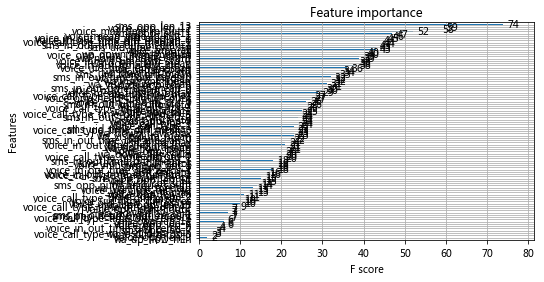

In [162]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 seed=27)

modelfit(xgb2, train_X, train_y)

## Step 4: Tune subsample and colsample_bytree

In [164]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=158, max_depth=5,
    min_child_weight=5, gamma=0, 
    objective= 'binary:logistic', seed=27), 
    param_grid = param_test4, scoring=gridSearch_scorer, cv=5)

gsearch4.fit(train_X, train_y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=158,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(metric_gridSearch, needs_proba=True), verbose=0)

/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.75853, std: 0.03197, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.75920, std: 0.03457, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.75480, std: 0.03339, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.75792, std: 0.02964, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.74699, std: 0.03072, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.75653, std: 0.03003, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.75302, std: 0.02836, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.75391, std: 0.02330, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.75269, std: 0.03610, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.76040, std: 0.03105, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.76300, std: 0.03284, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.76258, std: 0.03279, params: {'colsample_bytree': 0.8, 'subsample'

In [165]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=158, max_depth=5,
    min_child_weight=5, gamma=0, 
    objective= 'binary:logistic', seed=27), 
    param_grid = param_test5, scoring=gridSearch_scorer, cv=5)

gsearch5.fit(train_X, train_y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=158,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.75, 0.8, 0.85]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(metric_gridSearch, needs_proba=True), verbose=0)

/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.74866, std: 0.03195, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.75391, std: 0.03179, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.75430, std: 0.03406, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.75816, std: 0.03288, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.76300, std: 0.03284, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.75960, std: 0.03238, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.75549, std: 0.03409, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.75459, std: 0.03338, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.75499, std: 0.02786, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.7630049025878749)

## Step 5: Tuning Regularization Parameters

In [166]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=158, max_depth=5,
    min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', seed=27), 
    param_grid = param_test6, scoring=gridSearch_scorer, cv=5)

gsearch6.fit(train_X, train_y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=158,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(metric_gridSearch, needs_proba=True), verbose=0)

/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76300, std: 0.03284, params: {'reg_alpha': 1e-05},
  mean: 0.75482, std: 0.03231, params: {'reg_alpha': 0.01},
  mean: 0.75643, std: 0.03357, params: {'reg_alpha': 0.1},
  mean: 0.75922, std: 0.03431, params: {'reg_alpha': 1},
  mean: 0.58987, std: 0.04668, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.7630049025878749)

In [168]:
param_test7 = {
 'reg_alpha':[0, 0.0001, 0.00001, 0.000001, 0.000005]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=158, max_depth=5,
    min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', seed=27), 
    param_grid = param_test7, scoring=gridSearch_scorer, cv=5)

gsearch7.fit(train_X, train_y)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=158,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reg_alpha': [0, 0.0001, 1e-05, 1e-06, 5e-06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(metric_gridSearch, needs_proba=True), verbose=0)

/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76300, std: 0.03284, params: {'reg_alpha': 0},
  mean: 0.76208, std: 0.03368, params: {'reg_alpha': 0.0001},
  mean: 0.76300, std: 0.03284, params: {'reg_alpha': 1e-05},
  mean: 0.76300, std: 0.03284, params: {'reg_alpha': 1e-06},
  mean: 0.76300, std: 0.03284, params: {'reg_alpha': 5e-06}],
 {'reg_alpha': 0},
 0.7630049025878749)

## Step 6: Reducing Learning Rate

[0]	train-error:0.132476	train-metric_xgb:0.750802	test-error:0.154033	test-metric_xgb:0.691233
[1]	train-error:0.125175	train-metric_xgb:0.771052	test-error:0.152032	test-metric_xgb:0.709386
[2]	train-error:0.125975	train-metric_xgb:0.771027	test-error:0.146631	test-metric_xgb:0.718842
[3]	train-error:0.123925	train-metric_xgb:0.774721	test-error:0.146831	test-metric_xgb:0.719889
[4]	train-error:0.122274	train-metric_xgb:0.778837	test-error:0.149232	test-metric_xgb:0.717357
[5]	train-error:0.120774	train-metric_xgb:0.782565	test-error:0.147431	test-metric_xgb:0.721817
[6]	train-error:0.120724	train-metric_xgb:0.784945	test-error:0.146631	test-metric_xgb:0.724224
[7]	train-error:0.120724	train-metric_xgb:0.784191	test-error:0.14583	test-metric_xgb:0.723218
[8]	train-error:0.119624	train-metric_xgb:0.786228	test-error:0.145031	test-metric_xgb:0.725492
[9]	train-error:0.119674	train-metric_xgb:0.787903	test-error:0.144631	test-metric_xgb:0.728419
[10]	train-error:0.118774	train-metric_xg

[85]	train-error:0.0765652	train-metric_xgb:0.884984	test-error:0.132225	test-metric_xgb:0.770471
[86]	train-error:0.0763652	train-metric_xgb:0.885564	test-error:0.132025	test-metric_xgb:0.770546
[87]	train-error:0.0758652	train-metric_xgb:0.886565	test-error:0.130824	test-metric_xgb:0.772619
[88]	train-error:0.0755652	train-metric_xgb:0.887153	test-error:0.131625	test-metric_xgb:0.771452
[89]	train-error:0.075265	train-metric_xgb:0.887876	test-error:0.132025	test-metric_xgb:0.770865
[90]	train-error:0.074865	train-metric_xgb:0.888592	test-error:0.132225	test-metric_xgb:0.770521
[91]	train-error:0.0743146	train-metric_xgb:0.889598	test-error:0.131625	test-metric_xgb:0.771919
[92]	train-error:0.0739646	train-metric_xgb:0.890338	test-error:0.131025	test-metric_xgb:0.77338
[93]	train-error:0.0732646	train-metric_xgb:0.8916	test-error:0.130825	test-metric_xgb:0.773849
[94]	train-error:0.0730646	train-metric_xgb:0.891852	test-error:0.130825	test-metric_xgb:0.774138
[95]	train-error:0.072714

[169]	train-error:0.0422584	train-metric_xgb:0.943358	test-error:0.129624	test-metric_xgb:0.784064
[170]	train-error:0.0420086	train-metric_xgb:0.943751	test-error:0.129024	test-metric_xgb:0.784576
[171]	train-error:0.0415086	train-metric_xgb:0.944487	test-error:0.129224	test-metric_xgb:0.784839
[172]	train-error:0.0410082	train-metric_xgb:0.945207	test-error:0.129424	test-metric_xgb:0.784491
[173]	train-error:0.0407082	train-metric_xgb:0.945706	test-error:0.129225	test-metric_xgb:0.784806
[174]	train-error:0.0405582	train-metric_xgb:0.945941	test-error:0.129625	test-metric_xgb:0.784243
[175]	train-error:0.0407582	train-metric_xgb:0.945747	test-error:0.129025	test-metric_xgb:0.784868
[176]	train-error:0.0403082	train-metric_xgb:0.946394	test-error:0.129825	test-metric_xgb:0.783399
[177]	train-error:0.039808	train-metric_xgb:0.947095	test-error:0.129425	test-metric_xgb:0.784008
[178]	train-error:0.039908	train-metric_xgb:0.947061	test-error:0.129025	test-metric_xgb:0.784869
[179]	train-

[253]	train-error:0.0218546	train-metric_xgb:0.972759	test-error:0.126425	test-metric_xgb:0.789903
[254]	train-error:0.0217044	train-metric_xgb:0.972957	test-error:0.126825	test-metric_xgb:0.789845
[255]	train-error:0.0215044	train-metric_xgb:0.973237	test-error:0.126625	test-metric_xgb:0.789905
[256]	train-error:0.0212044	train-metric_xgb:0.973603	test-error:0.127225	test-metric_xgb:0.788893
[257]	train-error:0.0207542	train-metric_xgb:0.974187	test-error:0.127825	test-metric_xgb:0.788247
[258]	train-error:0.0206542	train-metric_xgb:0.97431	test-error:0.127826	test-metric_xgb:0.788469
[259]	train-error:0.0206042	train-metric_xgb:0.974417	test-error:0.127226	test-metric_xgb:0.78875
[260]	train-error:0.0204042	train-metric_xgb:0.974677	test-error:0.127026	test-metric_xgb:0.789358
[261]	train-error:0.019654	train-metric_xgb:0.975612	test-error:0.127225	test-metric_xgb:0.789218
[262]	train-error:0.0195542	train-metric_xgb:0.975739	test-error:0.126625	test-metric_xgb:0.79031
[263]	train-er

[337]	train-error:0.0100024	train-metric_xgb:0.988103	test-error:0.127225	test-metric_xgb:0.788923
[338]	train-error:0.0099522	train-metric_xgb:0.988168	test-error:0.127225	test-metric_xgb:0.789535
[339]	train-error:0.0098024	train-metric_xgb:0.988344	test-error:0.127025	test-metric_xgb:0.789891
[340]	train-error:0.0098524	train-metric_xgb:0.988297	test-error:0.127025	test-metric_xgb:0.790129
[341]	train-error:0.0094522	train-metric_xgb:0.988771	test-error:0.126624	test-metric_xgb:0.790606
[342]	train-error:0.009202	train-metric_xgb:0.98907	test-error:0.126424	test-metric_xgb:0.790789
[343]	train-error:0.009202	train-metric_xgb:0.989079	test-error:0.126624	test-metric_xgb:0.790178
[344]	train-error:0.009102	train-metric_xgb:0.989199	test-error:0.126624	test-metric_xgb:0.790154
[345]	train-error:0.0089518	train-metric_xgb:0.989382	test-error:0.126624	test-metric_xgb:0.790181
[346]	train-error:0.0090018	train-metric_xgb:0.989329	test-error:0.126624	test-metric_xgb:0.790118
[347]	train-er

[421]	train-error:0.0042508	train-metric_xgb:0.995081	test-error:0.124424	test-metric_xgb:0.792836
[422]	train-error:0.0042008	train-metric_xgb:0.995139	test-error:0.124824	test-metric_xgb:0.792562
[423]	train-error:0.0042008	train-metric_xgb:0.995141	test-error:0.125024	test-metric_xgb:0.792224
[424]	train-error:0.0041508	train-metric_xgb:0.9952	test-error:0.125025	test-metric_xgb:0.792407
[425]	train-error:0.0041008	train-metric_xgb:0.995258	test-error:0.124825	test-metric_xgb:0.792743
[426]	train-error:0.0041008	train-metric_xgb:0.995262	test-error:0.125225	test-metric_xgb:0.792502
[427]	train-error:0.0041008	train-metric_xgb:0.995262	test-error:0.125025	test-metric_xgb:0.792667
[428]	train-error:0.0040008	train-metric_xgb:0.995376	test-error:0.124824	test-metric_xgb:0.792641
[429]	train-error:0.0040508	train-metric_xgb:0.995321	test-error:0.125024	test-metric_xgb:0.792716
[430]	train-error:0.0039008	train-metric_xgb:0.995491	test-error:0.125225	test-metric_xgb:0.792704
[431]	train-

[504]	train-error:0.0017002	train-metric_xgb:0.998067	test-error:0.125025	test-metric_xgb:0.792553
[505]	train-error:0.0017002	train-metric_xgb:0.998068	test-error:0.124825	test-metric_xgb:0.792894
[506]	train-error:0.0017004	train-metric_xgb:0.998069	test-error:0.124224	test-metric_xgb:0.79365
[507]	train-error:0.0018004	train-metric_xgb:0.997957	test-error:0.124424	test-metric_xgb:0.793452
[508]	train-error:0.0018004	train-metric_xgb:0.997958	test-error:0.124624	test-metric_xgb:0.793102
[509]	train-error:0.0017002	train-metric_xgb:0.99807	test-error:0.124625	test-metric_xgb:0.793099
[510]	train-error:0.0018004	train-metric_xgb:0.997959	test-error:0.124224	test-metric_xgb:0.793449
[511]	train-error:0.0018004	train-metric_xgb:0.99796	test-error:0.124224	test-metric_xgb:0.793462
[512]	train-error:0.0018004	train-metric_xgb:0.997961	test-error:0.124424	test-metric_xgb:0.793275
[513]	train-error:0.0018004	train-metric_xgb:0.997961	test-error:0.124024	test-metric_xgb:0.793959
[514]	train-e

[588]	train-error:0.00105	train-metric_xgb:0.998827	test-error:0.125024	test-metric_xgb:0.792255
[589]	train-error:0.00105	train-metric_xgb:0.998827	test-error:0.125024	test-metric_xgb:0.792223
[590]	train-error:0.001	train-metric_xgb:0.998883	test-error:0.125424	test-metric_xgb:0.791292
[591]	train-error:0.001	train-metric_xgb:0.998883	test-error:0.125224	test-metric_xgb:0.791649
[592]	train-error:0.001	train-metric_xgb:0.998883	test-error:0.125224	test-metric_xgb:0.791856
[593]	train-error:0.00095	train-metric_xgb:0.998939	test-error:0.125024	test-metric_xgb:0.791975
[594]	train-error:0.00095	train-metric_xgb:0.998939	test-error:0.125224	test-metric_xgb:0.791899
[595]	train-error:0.0009	train-metric_xgb:0.998995	test-error:0.125024	test-metric_xgb:0.792261
[596]	train-error:0.0009	train-metric_xgb:0.998995	test-error:0.124824	test-metric_xgb:0.792639
[597]	train-error:0.00085	train-metric_xgb:0.999051	test-error:0.124624	test-metric_xgb:0.792745
[598]	train-error:0.00085	train-metric

/home/xuegsh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9966
AUC+F1 Score (Train): 0.996111


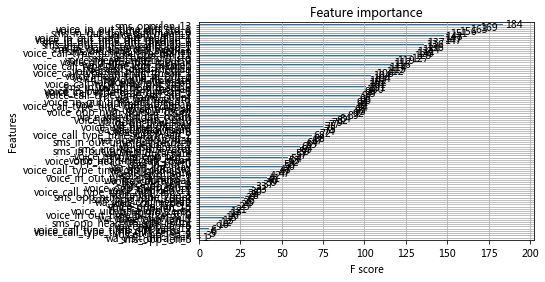

In [29]:
xgb4 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    objective='binary:logistic',
    seed=27)

modelfit(xgb4, train_X, train_y)

# 训练

In [59]:
paras = {
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_child_weight': 5,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'seed': 27
}
model = xgb.train(paras, dtrain, num_boost_round=1000, early_stopping_rounds=100,  feval=metric_xgb, maximize=True, evals=[(dtrain, 'here')])

[0]	here-error:0.106221	here-metric_xgb:0.83711
Multiple eval metrics have been passed: 'here-metric_xgb' will be used for early stopping.

Will train until here-metric_xgb hasn't improved in 100 rounds.
[1]	here-error:0.103821	here-metric_xgb:0.845084
[2]	here-error:0.10082	here-metric_xgb:0.834701
[3]	here-error:0.095219	here-metric_xgb:0.852707
[4]	here-error:0.096419	here-metric_xgb:0.8506
[5]	here-error:0.09862	here-metric_xgb:0.845559
[6]	here-error:0.095019	here-metric_xgb:0.850436
[7]	here-error:0.092619	here-metric_xgb:0.854612
[8]	here-error:0.093419	here-metric_xgb:0.855072
[9]	here-error:0.090618	here-metric_xgb:0.86183
[10]	here-error:0.092418	here-metric_xgb:0.860264
[11]	here-error:0.090418	here-metric_xgb:0.866089
[12]	here-error:0.089618	here-metric_xgb:0.866151
[13]	here-error:0.090418	here-metric_xgb:0.86377
[14]	here-error:0.091018	here-metric_xgb:0.864167
[15]	here-error:0.091218	here-metric_xgb:0.865251
[16]	here-error:0.090418	here-metric_xgb:0.866662
[17]	here-e

[161]	here-error:0.032607	here-metric_xgb:0.958067
[162]	here-error:0.032206	here-metric_xgb:0.958715
[163]	here-error:0.032006	here-metric_xgb:0.958964
[164]	here-error:0.031606	here-metric_xgb:0.959491
[165]	here-error:0.031006	here-metric_xgb:0.960224
[166]	here-error:0.030806	here-metric_xgb:0.960475
[167]	here-error:0.030606	here-metric_xgb:0.960767
[168]	here-error:0.031006	here-metric_xgb:0.960451
[169]	here-error:0.031006	here-metric_xgb:0.960483
[170]	here-error:0.030606	here-metric_xgb:0.961001
[171]	here-error:0.030406	here-metric_xgb:0.961308
[172]	here-error:0.030806	here-metric_xgb:0.960883
[173]	here-error:0.031006	here-metric_xgb:0.960658
[174]	here-error:0.030406	here-metric_xgb:0.961461
[175]	here-error:0.030606	here-metric_xgb:0.961245
[176]	here-error:0.029606	here-metric_xgb:0.962457
[177]	here-error:0.029806	here-metric_xgb:0.962242
[178]	here-error:0.029806	here-metric_xgb:0.962257
[179]	here-error:0.029606	here-metric_xgb:0.962569
[180]	here-error:0.029606	here-

[322]	here-error:0.010202	here-metric_xgb:0.988043
[323]	here-error:0.010202	here-metric_xgb:0.988043
[324]	here-error:0.010202	here-metric_xgb:0.988041
[325]	here-error:0.009802	here-metric_xgb:0.988495
[326]	here-error:0.010002	here-metric_xgb:0.988284
[327]	here-error:0.009802	here-metric_xgb:0.988519
[328]	here-error:0.009602	here-metric_xgb:0.988749
[329]	here-error:0.009602	here-metric_xgb:0.988755
[330]	here-error:0.009602	here-metric_xgb:0.988764
[331]	here-error:0.009402	here-metric_xgb:0.989
[332]	here-error:0.009202	here-metric_xgb:0.989244
[333]	here-error:0.009002	here-metric_xgb:0.989475
[334]	here-error:0.008802	here-metric_xgb:0.989701
[335]	here-error:0.008802	here-metric_xgb:0.989723
[336]	here-error:0.008602	here-metric_xgb:0.989956
[337]	here-error:0.008402	here-metric_xgb:0.990182
[338]	here-error:0.008402	here-metric_xgb:0.99018
[339]	here-error:0.008402	here-metric_xgb:0.990187
[340]	here-error:0.008402	here-metric_xgb:0.990192
[341]	here-error:0.008602	here-metr

[485]	here-error:0.0016	here-metric_xgb:0.998153
[486]	here-error:0.0016	here-metric_xgb:0.998154
[487]	here-error:0.0016	here-metric_xgb:0.998155
[488]	here-error:0.0016	here-metric_xgb:0.998155
[489]	here-error:0.0016	here-metric_xgb:0.998157
[490]	here-error:0.0016	here-metric_xgb:0.998159
[491]	here-error:0.0016	here-metric_xgb:0.99816
[492]	here-error:0.0016	here-metric_xgb:0.998162
[493]	here-error:0.0016	here-metric_xgb:0.998164
[494]	here-error:0.0016	here-metric_xgb:0.998163
[495]	here-error:0.0016	here-metric_xgb:0.998165
[496]	here-error:0.0016	here-metric_xgb:0.998165
[497]	here-error:0.0014	here-metric_xgb:0.998391
[498]	here-error:0.0014	here-metric_xgb:0.998391
[499]	here-error:0.0014	here-metric_xgb:0.998391
[500]	here-error:0.0014	here-metric_xgb:0.998392
[501]	here-error:0.0014	here-metric_xgb:0.998392
[502]	here-error:0.0014	here-metric_xgb:0.998394
[503]	here-error:0.0014	here-metric_xgb:0.998396
[504]	here-error:0.0014	here-metric_xgb:0.998396
[505]	here-error:0.00

[654]	here-error:0.0006	here-metric_xgb:0.999332
[655]	here-error:0.0006	here-metric_xgb:0.999332
[656]	here-error:0.0006	here-metric_xgb:0.999332
[657]	here-error:0.0006	here-metric_xgb:0.999332
[658]	here-error:0.0006	here-metric_xgb:0.999332
[659]	here-error:0.0006	here-metric_xgb:0.999332
[660]	here-error:0.0006	here-metric_xgb:0.999332
[661]	here-error:0.0006	here-metric_xgb:0.999332
[662]	here-error:0.0006	here-metric_xgb:0.999332
[663]	here-error:0.0006	here-metric_xgb:0.999332
[664]	here-error:0.0006	here-metric_xgb:0.999332
[665]	here-error:0.0006	here-metric_xgb:0.999332
[666]	here-error:0.0006	here-metric_xgb:0.999332
[667]	here-error:0.0004	here-metric_xgb:0.999555
[668]	here-error:0.0004	here-metric_xgb:0.999555
[669]	here-error:0.0004	here-metric_xgb:0.999555
[670]	here-error:0.0004	here-metric_xgb:0.999555
[671]	here-error:0.0006	here-metric_xgb:0.999332
[672]	here-error:0.0004	here-metric_xgb:0.999555
[673]	here-error:0.0004	here-metric_xgb:0.999555
[674]	here-error:0.0

[846]	here-error:0	here-metric_xgb:1
Stopping. Best iteration:
[746]	here-error:0	here-metric_xgb:1



In [24]:
dtest

In [60]:
pred=model.predict(dtest)

In [61]:
res =pd.DataFrame({'uid':test_uids,'label':pred})


In [62]:
res=res.sort_values(by='label',ascending=False)
res.label=res.label.map(lambda x: 1 if x>=0.5 else 0)
res.label = res.label.map(lambda x: int(x))

In [63]:
res.to_csv('../result/xgb-final.csv',index=False,header=False,sep=',',columns=['uid','label'])